# PropCare: Экспериментальный ноутбук

## Общее описание

Этот ноутбук содержит структурированный набор экспериментов с моделью **PropCare**.  
Здесь собраны исследования по абляции признаков, подбору гиперпараметров и многое другое, что поможет исследовать модель.

Цель — создать воспроизводимую, прозрачную и удобную экспериментальную среду для анализа и улучшения PropCare.

---

## Содержание ноутбука

1. **Пример работы модели** 
    быстрый старт как запустить, сохранить модель

2. **Абляционные эксперименты**  
   Исследование влияния отдельных компонент модели или входных признаков на итоговые метрики.  

3. **Подбор гиперпараметров**  
   Анализ параметров $\lambda_1$ и $\lambda_2$

4. **Анализ выходов модели**  
   Детальное изучение предсказаний модели

---

## Воспроизводимость

Все эксперименты выполнены с:
- фиксированными случайными зернами,
- едиными шагами предобработки данных,
- явным указанием ячеек, отвечающих за загрузку данных, конфигурацию моделей и расчёт метрик.

---

## Итог

Этот ноутбук является основой для анализа PropCare, позволяет сравнивать подходы, отлаживать модель и качественно документировать процесс разработки.


## Импорт необходимых библиотек

На этом этапе подключаем все модули, которые понадобятся в процессе работы — 
для обработки данных, визуализации, моделирования и вспомогательных операций.


In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm

from src import *

2025-11-20 17:21:49.595435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 17:21:49.606940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763648509.618258    1297 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763648509.621935    1297 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763648509.632323    1297 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Загрузка датасетов

Загружаем необходимые данные с помощью функции `get_dataset`.


In [3]:
DATASETS = ['CO', 'CP']
all_datasets = {}

# Загрузка
for name in tqdm(DATASETS):
    train_df, vali_df, test_df, num_users, num_items, item_pop = get_dataset(name, path_to_data=".")
    all_datasets[name] = {
        "train": train_df,
        "vali": vali_df,
        "test": test_df,
        "num_users": num_users,
        "num_items": num_items,
        "item_popularity": item_pop, 
    }


100%|██████████| 2/2 [00:31<00:00, 15.85s/it]


In [4]:
evaluator = Evaluator()
metrics = ['CPrec_10', 'CPrec_100', 'CDCG_100', 'CDCG']

## Пример обучения PropCare

В этом разделе приведён базовый пример запуска обучения модели **PropCare**.  
Для начала необходимо определить аргументы и конфигурацию модели —  
они задают архитектуру, параметры обучения, используемые признаки и прочие настройки, 
влияющие на поведение и качество PropCare.

### Основные параметры модели PropCare

| Параметр | Источник / значение | Описание |
|---------|---------------------|----------|
| **dimension** | `args.dimension` | Размерность эмбеддингов пользователей и объектов. Определяет глубину информационного представления. |
| **embedding_layer_units** | `args.embedding_layer_units` | Список размеров слоёв для общей (shared) MLP, обрабатывающей конкатенацию эмбеддингов. |
| **estimator_layer_units** | `args.estimator_layer_units` | Архитектура MLP для двух веток: propensity (p) и relevance (r). Определяет глубину и ширину «голов» модели. |
| **lambda_1** | `args.lambda_1` | Параметр, контролирующий силу популярностного штрафа через компоненту $\mathcal{L}_{pop}$ в функции потерь. Он регулирует, насколько модель должна учитывать популярность предметов при обучении. |
| **lambda_2** | `args.lambda_2` (по умолчанию `1e-4`) | Параметр, отвечает за силу регуляризации склонностей к показу через компоненту $\mathcal{L}_{reg}$ в функции потерь. |
| **lr** | `args.lr` | Скорость обучения (learning rate). Передаётся в оптимизатор SGD. |
| **ablation_mode** | `args.ablation_mode` (по умолчанию `"default"`) | Режим абляции модели: `"NEG"`, `"S1"`, `"NO_P"`, `"NO_R"`, `"NO_P_R"`. Позволяет отключать части модели для экспериментов. |


In [ ]:
class Args:
    dimension = 128
    embedding_layer_units = [256, 128, 64]
    estimator_layer_units = [64, 32, 16, 8]
    lambda_1 = 0.1
    lr = 0.01

args = Args()

Теперь выбираем, на каком из доступных датасетов будет происходить обучение PropCare.  
Для примера используем датасет **CO**, взяв параметры пользователей, предметов и популярности из заранее подготовленного словаря `all_datasets`.

После выбора конфигурации создаём экземпляр модели **PropCare**, передаём ей необходимые аргументы и запускаем процесс обучения.


In [ ]:
# Инициализация модели PropCare на датасете CO
model = PropCare(
    all_datasets['CO']['num_users'],
    all_datasets['CO']['num_items'],
    args=args,
    item_popularity=all_datasets['CO']['item_popularity'],
    device='cuda'
)

# Обучение модели
model.fit(
    all_datasets['CO']['train'],
    all_datasets['CO']['vali'],
    batch_size=4096,
    epochs=25
)


## Сохранение обученной модели (опционально)

После завершения обучения модель можно сохранить на диск.  
Это полезно для дальнейшего инференса, повторного использования модели, 
а также для воспроизводимости экспериментов.

Для сохранения необходимо указать путь, по которому будут записаны веса модели.


In [ ]:
model.save_model("saved_models/propcare/propcare_model")

Model saved to: saved_models/propcare/propcare_model


## Графики обучения и метрики на валидации

После завершения обучения можно визуализировать динамику функции потерь и качество модели на валидации.  
Это помогает понять:
- насколько стабильно шло обучение,
- была ли пере/недообученность,
- в какой момент модель достигла оптимума.

Ниже представлены графики изменения loss и метрик по эпохам.


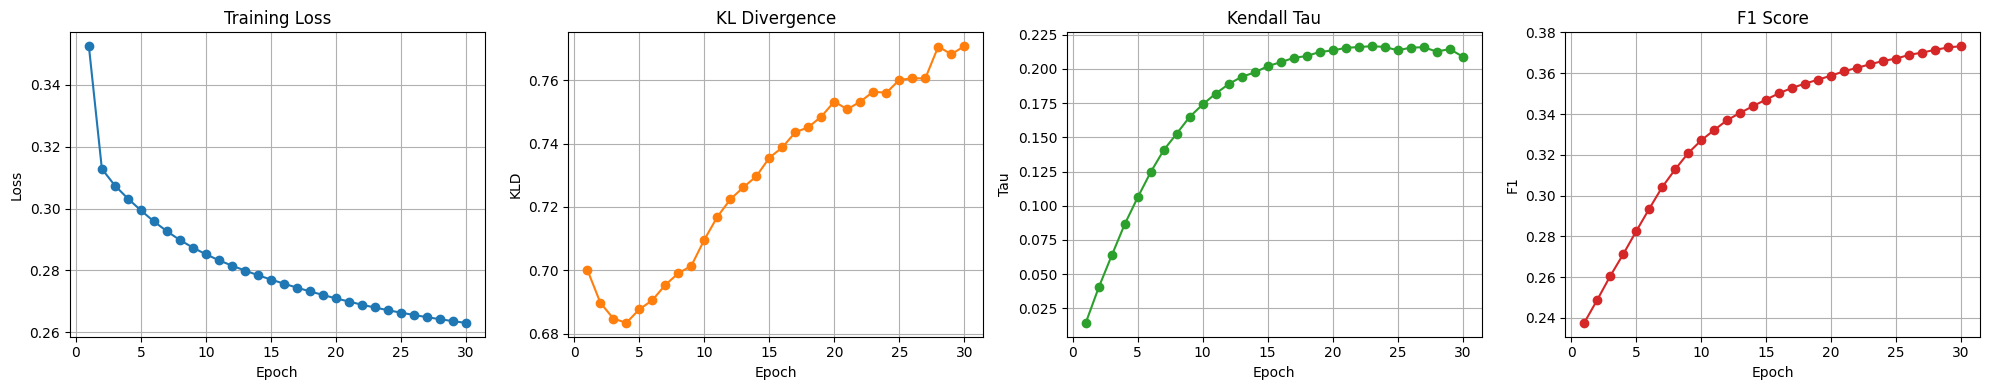

In [8]:
model.plot_curve()

## Предсказания на тестовом наборе и вычисление метрик

На финальном этапе оценим качество модели **PropCare** на тестовом датасете.  
Сначала получим предсказания для тестовых пользователей, затем вычислим целевые метрики


In [ ]:
model_name = 'PropCare'
all_datasets['CO']['test'][f"{model_name}_pred"] = model.predict(all_datasets['CO']['test'])

value = model.get_metrics(all_datasets['CO']['test'].rename(columns={f"{model_name}_pred": "pred"}), epsilon=0.2)
value["model"] = model_name

## Итоговое распределение предсказаний и реальных propensity

В завершение сравним распределения предсказанных моделью значений **propensity** 
с реальными значениями из тестового набора.

Сравнение распределений позволяет понять:

- не смещены ли предсказания модели относительно реальных значений;
- не «заваливается» ли модель в слишком узкий диапазон;
- насколько хорошо модель передаёт форму исходного распределения.

Ниже представлены графики распределений для реальных и предсказанных значений для затюниной модели на датасете CP


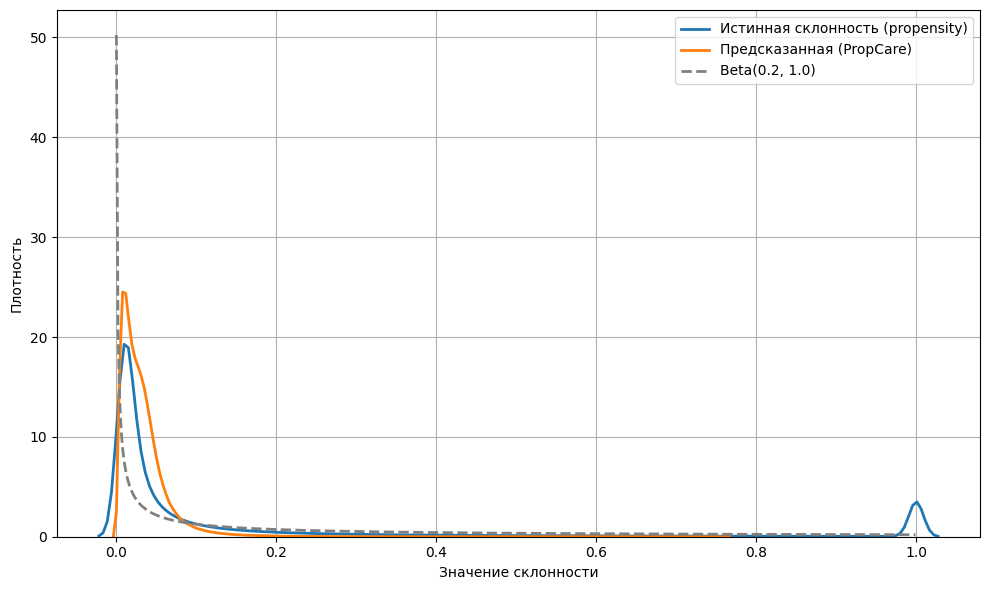

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

model = PropCare.load_model(dir_path=f"saved_models/propcare/best_CP", model_name=f"model_{1}", device='cuda')
model_name = "PropCare"
all_datasets['CP']['test'][f"{model_name}_pred"] = model.predict(all_datasets['CP']['test'])

p_hat_test = all_datasets['CP']['test']['PropCare_pred']
p_true_test = all_datasets['CP']['test']['propensity']

x = np.linspace(0.001, 0.999, 500)
alpha, beta_param = 0.2, 1.0
beta_pdf = beta.pdf(x, alpha, beta_param)

plt.figure(figsize=(10, 6))
sns.kdeplot(p_true_test, label="Истинная склонность (propensity)", linewidth=2)
sns.kdeplot(p_hat_test, label="Предсказанная (PropCare)", linewidth=2)
plt.plot(x, beta_pdf, label=f"Beta({alpha}, {beta_param})", color='gray', linestyle='--', linewidth=2)

plt.xlabel("Значение склонности")
plt.ylabel("Плотность")
# plt.title("Сравнение распределений: истинная, предсказанная и априорная Beta(0.2, 1.0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Эксперименты

В отдельном ноутбуке `tune_models` был проведён подбор гиперпараметров для модели **PropCare**.  
В рамках серии экспериментов перебирались размеры эмбеддингов, архитектура слоёв и другие параметры.  
По результатам поиска были получены следующие оптимальные значения гиперпараметров:

```python
class Args:
    dimension = 200
    embedding_layer_units = [512, 256]
    estimator_layer_units = [64, 32, 16]
    lambda_1 = 0.1
    lr = 0.0085

Их мы и будем использовать для дальнейших эксперементов

## Лямбда 1


В этом разделе рассматривается влияние параметра **λ₁** на обучение модели PropCare.  
Этот параметр определяет, насколько сильно модель должна учитывать популярность объектов при формировании функции потерь.  
Фактически λ₁ регулирует вклад популярностного ограничения, которое основано на **Предположении 1**:  
более популярные объекты имеют более высокую склонность к показу (propensity).


Параметр $ \lambda_1 $ управляет весом популярностного компонента в функции потерь — слагаемого $ \mathcal{L}_{\text{pop}}$.  
Суть этого компонента заключается в том, что модель обучается на парах объектов, отдавая предпочтение более популярным с точки зрения склонности к показу.  

Если:

- **λ₁ слишком мало (близко к 0)**  
  Модель почти не учитывает популярность объектов.  
  Она фокусируется только на минимизации ошибки предсказания событий, что может приводить к переобучению и игнорированию поведенческих закономерностей.

- **λ₁ слишком велико**  
  Модель чрезмерно подстраивается под популярность.  
  Это может искажать реальные предпочтения пользователей, увеличивать смещение в пользу популярных объектов и ухудшать итоговые метрики.

  
---

Чтобы определить оптимальное значение параметра $ \lambda_1 $, мы проводим серию экспериментов, в которых систематически изменяем этот гиперпараметр и наблюдаем, как меняются ключевые метрики качества (KLD, Kendall’s tau, F1). Итогом является выбор такого значения λ₁, которое обеспечивает наилучший баланс между учётом популярности и точностью оценки склонности.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lambda_values = np.logspace(-2, 1, 10)
metrics_results = {
    'lambda_1': [],
    'kld': [],
    'tau': [],
    'f1': []
}

for lmb in lambda_values:
    class Args:
        dimension = 200
        embedding_layer_units = [512, 256]
        estimator_layer_units = [64, 32, 16]
        lambda_1 = lmb
        lr = 0.0085
        

    args = Args()
    
    model = PropCare(all_datasets['CP']['num_users'], all_datasets['CP']['num_items'], args=args, item_popularity=all_datasets['CP']['item_popularity'], device='cuda')

    model.fit(all_datasets['CP']['train'], all_datasets['CP']['vali'], batch_size=4096, epochs=25)
    model.save_model(dir_path=f"saved_models/propcare/lambda1_CP", model_name=f"model_lmb{lmb}")
    val_metrics = model.get_metrics(all_datasets['CP']['vali'])


    metrics_results['lambda_1'].append(lmb)
    metrics_results['kld'].append(val_metrics['kld'])
    metrics_results['tau'].append(val_metrics['tau'])
    metrics_results['f1'].append(val_metrics['f1'])


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 136.77batch/s]


Epoch 0: train loss = 0.2432 | val corr = {'kld': np.float64(1.1026043894142987), 'tau': np.float64(0.07284683433772353), 'f1': 0.23954269751753796}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 128.48batch/s]


Epoch 1: train loss = 0.2103 | val corr = {'kld': np.float64(1.0421391133283504), 'tau': np.float64(0.12116985942275535), 'f1': 0.2546609985628122}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 134.37batch/s]


Epoch 2: train loss = 0.2069 | val corr = {'kld': np.float64(0.9974537641107261), 'tau': np.float64(0.1599702437609936), 'f1': 0.26965734445034023}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 141.40batch/s]


Epoch 3: train loss = 0.2053 | val corr = {'kld': np.float64(0.9621414527460501), 'tau': np.float64(0.19276209629244487), 'f1': 0.28344897765124477}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 134.25batch/s]


Epoch 4: train loss = 0.2041 | val corr = {'kld': np.float64(0.9334689883704373), 'tau': np.float64(0.2203286929377267), 'f1': 0.29620980858342383}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.38batch/s]


Epoch 5: train loss = 0.2032 | val corr = {'kld': np.float64(0.908488127460809), 'tau': np.float64(0.24483597444223995), 'f1': 0.3084851023353499}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.93batch/s]


Epoch 6: train loss = 0.2023 | val corr = {'kld': np.float64(0.8873725712274996), 'tau': np.float64(0.2654939566217525), 'f1': 0.3188420109833927}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 147.05batch/s]


Epoch 7: train loss = 0.2016 | val corr = {'kld': np.float64(0.8692511668133566), 'tau': np.float64(0.2845628938618062), 'f1': 0.3282291220308754}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.07batch/s]


Epoch 8: train loss = 0.2008 | val corr = {'kld': np.float64(0.8522477071921053), 'tau': np.float64(0.30163575849022), 'f1': 0.33690371707716554}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.24batch/s]


Epoch 9: train loss = 0.2002 | val corr = {'kld': np.float64(0.8385558028280105), 'tau': np.float64(0.31637667944185305), 'f1': 0.3444957123028071}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.51batch/s]


Epoch 10: train loss = 0.1996 | val corr = {'kld': np.float64(0.8254222376111527), 'tau': np.float64(0.33065684010259355), 'f1': 0.3507630355230988}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.53batch/s]


Epoch 11: train loss = 0.1990 | val corr = {'kld': np.float64(0.8143015288546013), 'tau': np.float64(0.3420533179726023), 'f1': 0.3561351070165358}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.14batch/s]


Epoch 12: train loss = 0.1984 | val corr = {'kld': np.float64(0.8044596725553382), 'tau': np.float64(0.35338231873197223), 'f1': 0.36123261486264374}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.19batch/s]


Epoch 13: train loss = 0.1978 | val corr = {'kld': np.float64(0.7958957503318841), 'tau': np.float64(0.36348099069247275), 'f1': 0.3653940647461462}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.04batch/s]


Epoch 14: train loss = 0.1973 | val corr = {'kld': np.float64(0.7893117701348094), 'tau': np.float64(0.3717340068925291), 'f1': 0.3690771389971873}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.50batch/s]


Epoch 15: train loss = 0.1967 | val corr = {'kld': np.float64(0.7821529019155862), 'tau': np.float64(0.38027722291905036), 'f1': 0.37250302968889154}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.50batch/s]


Epoch 16: train loss = 0.1962 | val corr = {'kld': np.float64(0.7768674934398092), 'tau': np.float64(0.3871017155462437), 'f1': 0.37553034987983563}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.78batch/s]


Epoch 17: train loss = 0.1957 | val corr = {'kld': np.float64(0.7722181376275489), 'tau': np.float64(0.39376458658084), 'f1': 0.3777756196196495}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.80batch/s]


Epoch 18: train loss = 0.1952 | val corr = {'kld': np.float64(0.7689919120375674), 'tau': np.float64(0.39904108142477707), 'f1': 0.37973119058684}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 138.66batch/s]


Epoch 19: train loss = 0.1947 | val corr = {'kld': np.float64(0.7652578052302655), 'tau': np.float64(0.40440754023102576), 'f1': 0.381766986574887}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.89batch/s]


Epoch 20: train loss = 0.1942 | val corr = {'kld': np.float64(0.7628924058455652), 'tau': np.float64(0.4085696974970192), 'f1': 0.3836752206226793}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 139.22batch/s]


Epoch 21: train loss = 0.1937 | val corr = {'kld': np.float64(0.7614546283524114), 'tau': np.float64(0.4125280915175347), 'f1': 0.38488236267247555}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.90batch/s]


Epoch 22: train loss = 0.1933 | val corr = {'kld': np.float64(0.7598631447961861), 'tau': np.float64(0.4164889233866376), 'f1': 0.38577461971930405}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.62batch/s]


Epoch 23: train loss = 0.1928 | val corr = {'kld': np.float64(0.7585314625240899), 'tau': np.float64(0.419612113918354), 'f1': 0.38717704639075384}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 139.42batch/s]


Epoch 24: train loss = 0.1923 | val corr = {'kld': np.float64(0.7583428203840279), 'tau': np.float64(0.4223517668367259), 'f1': 0.3878164964199672}
Model saved to: saved_models/propcare/lambda_CP/model_lmb0.01


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 141.87batch/s]


Epoch 0: train loss = 0.2593 | val corr = {'kld': np.float64(1.1031134908820874), 'tau': np.float64(0.0726614803344289), 'f1': 0.2424916004453122}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.97batch/s]


Epoch 1: train loss = 0.2263 | val corr = {'kld': np.float64(1.0427994311565159), 'tau': np.float64(0.12102569581529736), 'f1': 0.26109882758274655}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.81batch/s]


Epoch 2: train loss = 0.2229 | val corr = {'kld': np.float64(0.9971211626923602), 'tau': np.float64(0.1608025545801034), 'f1': 0.2797807866528561}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.72batch/s]


Epoch 3: train loss = 0.2212 | val corr = {'kld': np.float64(0.9612294064918612), 'tau': np.float64(0.19435444252497763), 'f1': 0.29778657575424317}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.79batch/s]


Epoch 4: train loss = 0.2200 | val corr = {'kld': np.float64(0.9311361424610795), 'tau': np.float64(0.22359315603832786), 'f1': 0.31428469562460126}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.74batch/s]


Epoch 5: train loss = 0.2190 | val corr = {'kld': np.float64(0.9053181113822627), 'tau': np.float64(0.2497090231455157), 'f1': 0.3288844147296652}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.63batch/s]


Epoch 6: train loss = 0.2181 | val corr = {'kld': np.float64(0.8826128090614518), 'tau': np.float64(0.2720062639568383), 'f1': 0.3433504678004721}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.52batch/s]


Epoch 7: train loss = 0.2172 | val corr = {'kld': np.float64(0.8625019965432243), 'tau': np.float64(0.2923768858746839), 'f1': 0.355614710372976}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 141.08batch/s]


Epoch 8: train loss = 0.2165 | val corr = {'kld': np.float64(0.8458097313674302), 'tau': np.float64(0.3099516331404894), 'f1': 0.36635785061384724}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 149.58batch/s]


Epoch 9: train loss = 0.2157 | val corr = {'kld': np.float64(0.8293691434656946), 'tau': np.float64(0.3263820546155228), 'f1': 0.37621120066267416}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 139.79batch/s]


Epoch 10: train loss = 0.2151 | val corr = {'kld': np.float64(0.8159686545705902), 'tau': np.float64(0.34093392778737386), 'f1': 0.3843720587564359}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.74batch/s]


Epoch 11: train loss = 0.2144 | val corr = {'kld': np.float64(0.8042462981207278), 'tau': np.float64(0.35411084148081234), 'f1': 0.3916536865181414}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.75batch/s]


Epoch 12: train loss = 0.2138 | val corr = {'kld': np.float64(0.7936413564168726), 'tau': np.float64(0.3656226534747624), 'f1': 0.3983602480210629}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.99batch/s]


Epoch 13: train loss = 0.2132 | val corr = {'kld': np.float64(0.7840212113539193), 'tau': np.float64(0.3766529889837191), 'f1': 0.403446164460351}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 139.42batch/s]


Epoch 14: train loss = 0.2126 | val corr = {'kld': np.float64(0.7769017300136591), 'tau': np.float64(0.3855703181891603), 'f1': 0.4085365166371729}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.34batch/s]


Epoch 15: train loss = 0.2120 | val corr = {'kld': np.float64(0.7698386365628697), 'tau': np.float64(0.3944832965775521), 'f1': 0.4119938840102722}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.64batch/s]


Epoch 16: train loss = 0.2115 | val corr = {'kld': np.float64(0.7651391894094967), 'tau': np.float64(0.401451189946671), 'f1': 0.41623115035497044}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.61batch/s]


Epoch 17: train loss = 0.2109 | val corr = {'kld': np.float64(0.7596793850931142), 'tau': np.float64(0.40876856776359954), 'f1': 0.4191536646917792}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.81batch/s]


Epoch 18: train loss = 0.2104 | val corr = {'kld': np.float64(0.7556415361375888), 'tau': np.float64(0.41423315257790516), 'f1': 0.4226158186436899}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 125.84batch/s]


Epoch 19: train loss = 0.2098 | val corr = {'kld': np.float64(0.7515851012687318), 'tau': np.float64(0.41996836740436394), 'f1': 0.4248103384026943}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.98batch/s]


Epoch 20: train loss = 0.2093 | val corr = {'kld': np.float64(0.7499340153754729), 'tau': np.float64(0.42449564579151067), 'f1': 0.4267813684587064}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:16<00:00, 117.15batch/s]


Epoch 21: train loss = 0.2088 | val corr = {'kld': np.float64(0.7488757322559021), 'tau': np.float64(0.4284118305157638), 'f1': 0.42897406050356185}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 134.87batch/s]


Epoch 22: train loss = 0.2083 | val corr = {'kld': np.float64(0.7461275766637915), 'tau': np.float64(0.43268173200817306), 'f1': 0.430810689422861}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.40batch/s]


Epoch 23: train loss = 0.2078 | val corr = {'kld': np.float64(0.7456913943808356), 'tau': np.float64(0.4357954701809617), 'f1': 0.432743230800333}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.33batch/s]


Epoch 24: train loss = 0.2073 | val corr = {'kld': np.float64(0.7449655125205531), 'tau': np.float64(0.4389694125611724), 'f1': 0.4333944724039665}
Model saved to: saved_models/propcare/lambda_CP/model_lmb0.021544346900318832


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 147.27batch/s]


Epoch 0: train loss = 0.2937 | val corr = {'kld': np.float64(1.103579102566129), 'tau': np.float64(0.07285229370480843), 'f1': 0.2501525964282263}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 133.97batch/s]


Epoch 1: train loss = 0.2606 | val corr = {'kld': np.float64(1.0412886639124708), 'tau': np.float64(0.12413134960562049), 'f1': 0.27648328855728604}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 143.79batch/s]


Epoch 2: train loss = 0.2570 | val corr = {'kld': np.float64(0.9916645469468423), 'tau': np.float64(0.1687836044570573), 'f1': 0.3026170198621688}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.96batch/s]


Epoch 3: train loss = 0.2551 | val corr = {'kld': np.float64(0.9514810184937816), 'tau': np.float64(0.20643763785141825), 'f1': 0.3272837869453326}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.45batch/s]


Epoch 4: train loss = 0.2536 | val corr = {'kld': np.float64(0.9161245037139933), 'tau': np.float64(0.24050755800555418), 'f1': 0.35021543756616896}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.25batch/s]


Epoch 5: train loss = 0.2523 | val corr = {'kld': np.float64(0.8858392602458195), 'tau': np.float64(0.26989127932438506), 'f1': 0.37051045085144996}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.46batch/s]


Epoch 6: train loss = 0.2512 | val corr = {'kld': np.float64(0.8590138035147703), 'tau': np.float64(0.2959738427017865), 'f1': 0.3884904957650481}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.97batch/s]


Epoch 7: train loss = 0.2501 | val corr = {'kld': np.float64(0.8352770997471023), 'tau': np.float64(0.3196208385519369), 'f1': 0.40327538466930707}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.76batch/s]


Epoch 8: train loss = 0.2491 | val corr = {'kld': np.float64(0.8156037175710951), 'tau': np.float64(0.3396301811132783), 'f1': 0.41648588478167864}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.16batch/s]


Epoch 9: train loss = 0.2482 | val corr = {'kld': np.float64(0.7986352470297254), 'tau': np.float64(0.3576594085223048), 'f1': 0.4272248034711633}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.51batch/s]


Epoch 10: train loss = 0.2473 | val corr = {'kld': np.float64(0.7831207011504013), 'tau': np.float64(0.3739977877042525), 'f1': 0.4368966491168355}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.67batch/s]


Epoch 11: train loss = 0.2464 | val corr = {'kld': np.float64(0.7707926716394469), 'tau': np.float64(0.3883467687746243), 'f1': 0.44551297214872937}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.45batch/s]


Epoch 12: train loss = 0.2456 | val corr = {'kld': np.float64(0.7606198122724535), 'tau': np.float64(0.4009754910294932), 'f1': 0.4522057618862113}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 138.58batch/s]


Epoch 13: train loss = 0.2449 | val corr = {'kld': np.float64(0.7517372992846539), 'tau': np.float64(0.41224345205428314), 'f1': 0.4586035210452494}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.45batch/s]


Epoch 14: train loss = 0.2441 | val corr = {'kld': np.float64(0.7456806129954823), 'tau': np.float64(0.4214042022913681), 'f1': 0.4641748355581174}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.48batch/s]


Epoch 15: train loss = 0.2433 | val corr = {'kld': np.float64(0.7395622882826665), 'tau': np.float64(0.4299358522492624), 'f1': 0.46934546769417695}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.80batch/s]


Epoch 16: train loss = 0.2426 | val corr = {'kld': np.float64(0.7351466867571864), 'tau': np.float64(0.43780641699950285), 'f1': 0.4734998294642274}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 121.65batch/s]


Epoch 17: train loss = 0.2419 | val corr = {'kld': np.float64(0.7318607942397939), 'tau': np.float64(0.4445215222867401), 'f1': 0.4770253213233864}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 121.00batch/s]


Epoch 18: train loss = 0.2412 | val corr = {'kld': np.float64(0.7296409500145908), 'tau': np.float64(0.45042027362636583), 'f1': 0.4807923039507107}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.33batch/s]


Epoch 19: train loss = 0.2405 | val corr = {'kld': np.float64(0.7298819931768024), 'tau': np.float64(0.45450524110117885), 'f1': 0.483651964892123}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.89batch/s]


Epoch 20: train loss = 0.2399 | val corr = {'kld': np.float64(0.7287674163636497), 'tau': np.float64(0.4589688999940936), 'f1': 0.4861439136425456}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.93batch/s]


Epoch 21: train loss = 0.2392 | val corr = {'kld': np.float64(0.7302331238935881), 'tau': np.float64(0.4617770444549154), 'f1': 0.4888293317122738}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.96batch/s]


Epoch 22: train loss = 0.2386 | val corr = {'kld': np.float64(0.7316700864518685), 'tau': np.float64(0.4642775128842305), 'f1': 0.49082184007303054}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.92batch/s]


Epoch 23: train loss = 0.2379 | val corr = {'kld': np.float64(0.7325950212300893), 'tau': np.float64(0.4668395214946414), 'f1': 0.492880112666349}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 143.62batch/s]


Epoch 24: train loss = 0.2373 | val corr = {'kld': np.float64(0.7340423604413954), 'tau': np.float64(0.468963256737935), 'f1': 0.4947303759410356}
Model saved to: saved_models/propcare/lambda_CP/model_lmb0.046415888336127774


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.95batch/s]


Epoch 0: train loss = 0.3678 | val corr = {'kld': np.float64(1.1028802073912352), 'tau': np.float64(0.07566267715683268), 'f1': 0.26527286678215745}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 143.55batch/s]


Epoch 1: train loss = 0.3338 | val corr = {'kld': np.float64(1.030407640062892), 'tau': np.float64(0.1393028675054971), 'f1': 0.30685904159947636}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.05batch/s]


Epoch 2: train loss = 0.3291 | val corr = {'kld': np.float64(0.9656690662626239), 'tau': np.float64(0.19800669234154736), 'f1': 0.3465055078664068}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 148.71batch/s]


Epoch 3: train loss = 0.3260 | val corr = {'kld': np.float64(0.911814150355331), 'tau': np.float64(0.24735330843198314), 'f1': 0.3808218635303765}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.47batch/s]


Epoch 4: train loss = 0.3232 | val corr = {'kld': np.float64(0.8677403499685352), 'tau': np.float64(0.2883721288082204), 'f1': 0.4097208285502511}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.30batch/s]


Epoch 5: train loss = 0.3207 | val corr = {'kld': np.float64(0.831641482270022), 'tau': np.float64(0.32398242761482177), 'f1': 0.4334567545476458}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 136.03batch/s]


Epoch 6: train loss = 0.3183 | val corr = {'kld': np.float64(0.8032046569074583), 'tau': np.float64(0.3541086723524802), 'f1': 0.45397752075816633}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 153.64batch/s]


Epoch 7: train loss = 0.3160 | val corr = {'kld': np.float64(0.7815008688716777), 'tau': np.float64(0.37970772230395133), 'f1': 0.4718991510087438}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.15batch/s]


Epoch 8: train loss = 0.3138 | val corr = {'kld': np.float64(0.7672250966009401), 'tau': np.float64(0.4001597801171094), 'f1': 0.4870993274085532}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 147.38batch/s]


Epoch 9: train loss = 0.3117 | val corr = {'kld': np.float64(0.758587027902442), 'tau': np.float64(0.4175696349676932), 'f1': 0.4992573457037982}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 139.29batch/s]


Epoch 10: train loss = 0.3097 | val corr = {'kld': np.float64(0.7534333057028818), 'tau': np.float64(0.43237328015305787), 'f1': 0.5089530924835451}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.89batch/s]


Epoch 11: train loss = 0.3079 | val corr = {'kld': np.float64(0.7490655284263261), 'tau': np.float64(0.44440380200222274), 'f1': 0.5168381567455278}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:16<00:00, 113.18batch/s]


Epoch 12: train loss = 0.3061 | val corr = {'kld': np.float64(0.7535932023122244), 'tau': np.float64(0.45275511808783053), 'f1': 0.5222413980087734}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.00batch/s]


Epoch 13: train loss = 0.3044 | val corr = {'kld': np.float64(0.7521174279435274), 'tau': np.float64(0.4615244809421558), 'f1': 0.5269554982577808}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.14batch/s]


Epoch 14: train loss = 0.3029 | val corr = {'kld': np.float64(0.7580426993664987), 'tau': np.float64(0.46648854804702683), 'f1': 0.5303095680096332}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 123.76batch/s]


Epoch 15: train loss = 0.3014 | val corr = {'kld': np.float64(0.7612094282700377), 'tau': np.float64(0.4714640412475629), 'f1': 0.5329135813122948}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 138.75batch/s]


Epoch 16: train loss = 0.3000 | val corr = {'kld': np.float64(0.7671431413350742), 'tau': np.float64(0.4743397749621526), 'f1': 0.5348170213813562}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.69batch/s]


Epoch 17: train loss = 0.2986 | val corr = {'kld': np.float64(0.774053682188886), 'tau': np.float64(0.47540548024036955), 'f1': 0.5363463202056672}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.80batch/s]


Epoch 18: train loss = 0.2974 | val corr = {'kld': np.float64(0.786169328074699), 'tau': np.float64(0.47326433827324044), 'f1': 0.5379454825271741}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 141.06batch/s]


Epoch 19: train loss = 0.2962 | val corr = {'kld': np.float64(0.7870905495197005), 'tau': np.float64(0.4771165391137883), 'f1': 0.5393821904332434}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.57batch/s]


Epoch 20: train loss = 0.2950 | val corr = {'kld': np.float64(0.794270459770204), 'tau': np.float64(0.4759940624091527), 'f1': 0.5402396017589723}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.38batch/s]


Epoch 21: train loss = 0.2939 | val corr = {'kld': np.float64(0.8076925304940021), 'tau': np.float64(0.4718223561471982), 'f1': 0.540739053332131}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.75batch/s]


Epoch 22: train loss = 0.2928 | val corr = {'kld': np.float64(0.8122258451913656), 'tau': np.float64(0.47177269898815793), 'f1': 0.5412782851336515}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.93batch/s]


Epoch 23: train loss = 0.2918 | val corr = {'kld': np.float64(0.8239110975931727), 'tau': np.float64(0.46745569334966147), 'f1': 0.5417546159660518}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.10batch/s]


Epoch 24: train loss = 0.2908 | val corr = {'kld': np.float64(0.8276711953958091), 'tau': np.float64(0.467003075515014), 'f1': 0.5419702666274816}
Model saved to: saved_models/propcare/lambda_CP/model_lmb0.1


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 147.50batch/s]


Epoch 0: train loss = 0.5258 | val corr = {'kld': np.float64(1.0946723263337765), 'tau': np.float64(0.09176429419726448), 'f1': 0.2994344827487557}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.91batch/s]


Epoch 1: train loss = 0.4863 | val corr = {'kld': np.float64(0.988643946693447), 'tau': np.float64(0.1886541785288325), 'f1': 0.368726958496738}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 148.00batch/s]


Epoch 2: train loss = 0.4746 | val corr = {'kld': np.float64(0.9026180095342505), 'tau': np.float64(0.2684180242225869), 'f1': 0.42583581341948945}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.31batch/s]


Epoch 3: train loss = 0.4646 | val corr = {'kld': np.float64(0.844967465744966), 'tau': np.float64(0.32890376387095854), 'f1': 0.47243060146840127}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 148.76batch/s]


Epoch 4: train loss = 0.4556 | val corr = {'kld': np.float64(0.8202669005666006), 'tau': np.float64(0.3721215100402096), 'f1': 0.5038530289682778}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.83batch/s]


Epoch 5: train loss = 0.4478 | val corr = {'kld': np.float64(0.8178370563177662), 'tau': np.float64(0.40058575642892663), 'f1': 0.5227680897925246}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.40batch/s]


Epoch 6: train loss = 0.4409 | val corr = {'kld': np.float64(0.823507642075677), 'tau': np.float64(0.41998048929305587), 'f1': 0.5336927223719676}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.33batch/s]


Epoch 7: train loss = 0.4349 | val corr = {'kld': np.float64(0.8371709196040188), 'tau': np.float64(0.430634468712068), 'f1': 0.5397788499265428}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 149.38batch/s]


Epoch 8: train loss = 0.4298 | val corr = {'kld': np.float64(0.8571420179586937), 'tau': np.float64(0.4336484187437041), 'f1': 0.5422660670516876}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.13batch/s]


Epoch 9: train loss = 0.4255 | val corr = {'kld': np.float64(0.8736160416486999), 'tau': np.float64(0.435469001010376), 'f1': 0.5436950709115111}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.74batch/s]


Epoch 10: train loss = 0.4217 | val corr = {'kld': np.float64(0.8950291794300874), 'tau': np.float64(0.43090059491874505), 'f1': 0.5435248957328592}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.14batch/s]


Epoch 11: train loss = 0.4185 | val corr = {'kld': np.float64(0.9083258294228158), 'tau': np.float64(0.43005795497484983), 'f1': 0.5431479207660441}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 120.06batch/s]


Epoch 12: train loss = 0.4158 | val corr = {'kld': np.float64(0.9290230146624959), 'tau': np.float64(0.4209516044845625), 'f1': 0.5423279569577029}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 132.40batch/s]


Epoch 13: train loss = 0.4136 | val corr = {'kld': np.float64(0.9636355410062335), 'tau': np.float64(0.40307569816724065), 'f1': 0.5411659262948784}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 143.54batch/s]


Epoch 14: train loss = 0.4116 | val corr = {'kld': np.float64(1.0002150075621772), 'tau': np.float64(0.38304723537889923), 'f1': 0.5400836933915154}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.48batch/s]


Epoch 15: train loss = 0.4098 | val corr = {'kld': np.float64(1.0345886193301055), 'tau': np.float64(0.36524381442575327), 'f1': 0.5386004594576418}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.26batch/s]


Epoch 16: train loss = 0.4081 | val corr = {'kld': np.float64(1.0639350633635398), 'tau': np.float64(0.35500354205062257), 'f1': 0.5379362612037832}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.06batch/s]


Epoch 17: train loss = 0.4066 | val corr = {'kld': np.float64(1.0979341331762722), 'tau': np.float64(0.3427246931142191), 'f1': 0.5368369019506954}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.84batch/s]


Epoch 18: train loss = 0.4052 | val corr = {'kld': np.float64(1.174341476044996), 'tau': np.float64(0.3104188119117963), 'f1': 0.5352179775839463}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 138.06batch/s]


Epoch 19: train loss = 0.4037 | val corr = {'kld': np.float64(1.248979602358812), 'tau': np.float64(0.2925460476294679), 'f1': 0.5340529039307447}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.62batch/s]


Epoch 20: train loss = 0.4020 | val corr = {'kld': np.float64(1.3569178756967484), 'tau': np.float64(0.269786446634306), 'f1': 0.5327730600332705}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.33batch/s]


Epoch 21: train loss = 0.4000 | val corr = {'kld': np.float64(1.4929084814998452), 'tau': np.float64(0.2662087136424489), 'f1': 0.5312740644486076}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.36batch/s]


Epoch 22: train loss = 0.3972 | val corr = {'kld': np.float64(1.7042547576595983), 'tau': np.float64(0.2615938761986165), 'f1': 0.5278439108829232}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.92batch/s]


Epoch 23: train loss = 0.3924 | val corr = {'kld': np.float64(2.00783005139962), 'tau': np.float64(0.24048286785671222), 'f1': 0.5218808999370673}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.99batch/s]


Epoch 24: train loss = 0.3848 | val corr = {'kld': np.float64(2.3146571192890018), 'tau': np.float64(0.2037542249791277), 'f1': 0.5141751643243985}
Model saved to: saved_models/propcare/lambda_CP/model_lmb0.21544346900318834


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.78batch/s]


Epoch 0: train loss = 0.8563 | val corr = {'kld': np.float64(1.077658932244255), 'tau': np.float64(0.13202680717608398), 'f1': 0.37102735703958784}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 149.92batch/s]


Epoch 1: train loss = 0.7802 | val corr = {'kld': np.float64(0.9577213804460168), 'tau': np.float64(0.27357070679834444), 'f1': 0.4806415440996185}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.07batch/s]


Epoch 2: train loss = 0.7404 | val corr = {'kld': np.float64(0.9573334902334806), 'tau': np.float64(0.3394909648974047), 'f1': 0.5272501653611559}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.13batch/s]


Epoch 3: train loss = 0.7123 | val corr = {'kld': np.float64(0.990156674534978), 'tau': np.float64(0.36686129778747945), 'f1': 0.5378792010568544}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.70batch/s]


Epoch 4: train loss = 0.6935 | val corr = {'kld': np.float64(1.0478669342465474), 'tau': np.float64(0.3609141567892285), 'f1': 0.5373521883030888}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 147.43batch/s]


Epoch 5: train loss = 0.6809 | val corr = {'kld': np.float64(1.1013182341630443), 'tau': np.float64(0.3518673315510093), 'f1': 0.5349748212681448}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:16<00:00, 114.41batch/s]


Epoch 6: train loss = 0.6711 | val corr = {'kld': np.float64(1.3296992303087969), 'tau': np.float64(0.29513121002535403), 'f1': 0.5308513028617339}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.74batch/s]


Epoch 7: train loss = 0.6581 | val corr = {'kld': np.float64(2.071815817356599), 'tau': np.float64(0.21409203972451582), 'f1': 0.5186910253721955}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 129.91batch/s]


Epoch 8: train loss = 0.6176 | val corr = {'kld': np.float64(3.103033137304831), 'tau': np.float64(-0.009163092740360293), 'f1': 0.5011714280185107}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 140.76batch/s]


Epoch 9: train loss = 0.4935 | val corr = {'kld': np.float64(3.3459414275972468), 'tau': np.float64(-0.28445033348066207), 'f1': 0.5286632135887545}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.98batch/s]


Epoch 10: train loss = 0.4051 | val corr = {'kld': np.float64(3.2235698185908768), 'tau': np.float64(-0.28825059118165935), 'f1': 0.5348472366587788}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.73batch/s]


Epoch 11: train loss = 0.3807 | val corr = {'kld': np.float64(3.1464614409496994), 'tau': np.float64(-0.2758110536730091), 'f1': 0.5382223507923132}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.25batch/s]


Epoch 12: train loss = 0.3701 | val corr = {'kld': np.float64(3.186341942780078), 'tau': np.float64(-0.2611311201145398), 'f1': 0.541702365060073}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 141.37batch/s]


Epoch 13: train loss = 0.3628 | val corr = {'kld': np.float64(3.1383106097910334), 'tau': np.float64(-0.2507013840563121), 'f1': 0.5442426350927837}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.21batch/s]


Epoch 14: train loss = 0.3560 | val corr = {'kld': np.float64(3.191452120761582), 'tau': np.float64(-0.23743971155914947), 'f1': 0.5468048593531316}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.23batch/s]


Epoch 15: train loss = 0.3478 | val corr = {'kld': np.float64(2.994777961586434), 'tau': np.float64(-0.21571759300738783), 'f1': 0.551718931040927}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.89batch/s]


Epoch 16: train loss = 0.3382 | val corr = {'kld': np.float64(2.9870080912807384), 'tau': np.float64(-0.18957362441525621), 'f1': 0.5555253575607532}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.58batch/s]


Epoch 17: train loss = 0.3292 | val corr = {'kld': np.float64(2.8870181465812954), 'tau': np.float64(-0.16377159964370805), 'f1': 0.5601933061408514}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 138.08batch/s]


Epoch 18: train loss = 0.3214 | val corr = {'kld': np.float64(2.846155402261904), 'tau': np.float64(-0.1327715037173081), 'f1': 0.5625168456667397}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.59batch/s]


Epoch 19: train loss = 0.3162 | val corr = {'kld': np.float64(2.688832861840846), 'tau': np.float64(-0.12560899306520074), 'f1': 0.563926337402709}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.38batch/s]


Epoch 20: train loss = 0.3141 | val corr = {'kld': np.float64(2.793019510264604), 'tau': np.float64(-0.11745054650512166), 'f1': 0.5643017481587219}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.80batch/s]


Epoch 21: train loss = 0.3120 | val corr = {'kld': np.float64(2.891979298665437), 'tau': np.float64(-0.11945874293319896), 'f1': 0.5658289436648035}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.78batch/s]


Epoch 22: train loss = 0.3093 | val corr = {'kld': np.float64(2.707739059031846), 'tau': np.float64(-0.09917927119040035), 'f1': 0.5679221846208016}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.21batch/s]


Epoch 23: train loss = 0.3068 | val corr = {'kld': np.float64(2.7746117966445962), 'tau': np.float64(-0.0920731268081526), 'f1': 0.5691957161528736}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.47batch/s]


Epoch 24: train loss = 0.3021 | val corr = {'kld': np.float64(2.776771247553279), 'tau': np.float64(-0.0891811703277465), 'f1': 0.5706576482243282}
Model saved to: saved_models/propcare/lambda_CP/model_lmb0.46415888336127775


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.16batch/s]


Epoch 0: train loss = 1.5069 | val corr = {'kld': np.float64(1.2437363170739089), 'tau': np.float64(0.18606177651898168), 'f1': 0.4923072424647911}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.27batch/s]


Epoch 1: train loss = 1.3036 | val corr = {'kld': np.float64(2.0134903980814385), 'tau': np.float64(0.1963582867021399), 'f1': 0.5179214351995051}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.98batch/s]


Epoch 2: train loss = 1.1153 | val corr = {'kld': np.float64(3.897490438539122), 'tau': np.float64(-0.1642411531548945), 'f1': 0.5102218681409755}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:15<00:00, 123.46batch/s]


Epoch 3: train loss = 0.6806 | val corr = {'kld': np.float64(3.597751154709566), 'tau': np.float64(-0.28668431639055053), 'f1': 0.5498593177039631}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:16<00:00, 111.68batch/s]


Epoch 4: train loss = 0.5594 | val corr = {'kld': np.float64(3.3715363952588806), 'tau': np.float64(-0.25004362017660403), 'f1': 0.5561619603713985}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.74batch/s]


Epoch 5: train loss = 0.5271 | val corr = {'kld': np.float64(3.2306166617427636), 'tau': np.float64(-0.23026111208705002), 'f1': 0.5622021036445983}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.63batch/s]


Epoch 6: train loss = 0.4959 | val corr = {'kld': np.float64(3.1877173187146064), 'tau': np.float64(-0.1908724214535173), 'f1': 0.5665910329291401}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 136.01batch/s]


Epoch 7: train loss = 0.4690 | val corr = {'kld': np.float64(3.042721965534963), 'tau': np.float64(-0.15786900217589334), 'f1': 0.5713519837884679}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.32batch/s]


Epoch 8: train loss = 0.4483 | val corr = {'kld': np.float64(2.95401091648582), 'tau': np.float64(-0.13300817319584576), 'f1': 0.574262890865805}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.12batch/s]


Epoch 9: train loss = 0.4357 | val corr = {'kld': np.float64(2.8322443281442564), 'tau': np.float64(-0.09631536500287186), 'f1': 0.5786579881211062}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.23batch/s]


Epoch 10: train loss = 0.4153 | val corr = {'kld': np.float64(2.739046937770945), 'tau': np.float64(-0.07173073148868955), 'f1': 0.5797757993693671}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.10batch/s]


Epoch 11: train loss = 0.4039 | val corr = {'kld': np.float64(2.8931539841360037), 'tau': np.float64(-0.09943861005372563), 'f1': 0.5810264130846673}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 143.21batch/s]


Epoch 12: train loss = 0.3961 | val corr = {'kld': np.float64(2.774699105340051), 'tau': np.float64(-0.02576011142113659), 'f1': 0.5814953174896321}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.13batch/s]


Epoch 13: train loss = 0.3936 | val corr = {'kld': np.float64(2.862218344374665), 'tau': np.float64(-0.04234168926121177), 'f1': 0.5817962457643494}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.44batch/s]


Epoch 14: train loss = 0.3897 | val corr = {'kld': np.float64(2.675112578847902), 'tau': np.float64(-0.004858300409089295), 'f1': 0.5817668684037048}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.28batch/s]


Epoch 15: train loss = 0.3864 | val corr = {'kld': np.float64(2.609112922214407), 'tau': np.float64(-0.021234148496846423), 'f1': 0.581590709383238}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.41batch/s]


Epoch 16: train loss = 0.3828 | val corr = {'kld': np.float64(2.723228209693789), 'tau': np.float64(-0.0038412445258737293), 'f1': 0.5814256763554657}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 138.21batch/s]


Epoch 17: train loss = 0.3787 | val corr = {'kld': np.float64(2.548444864520235), 'tau': np.float64(-0.002003033781761993), 'f1': 0.5808310002153647}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.28batch/s]


Epoch 18: train loss = 0.3774 | val corr = {'kld': np.float64(2.663470768897147), 'tau': np.float64(0.025015263382965613), 'f1': 0.5805891561395911}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.05batch/s]


Epoch 19: train loss = 0.3755 | val corr = {'kld': np.float64(2.7617334556086175), 'tau': np.float64(0.02376974749297698), 'f1': 0.5804554125516143}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.45batch/s]


Epoch 20: train loss = 0.3745 | val corr = {'kld': np.float64(2.6898317526066573), 'tau': np.float64(-0.002551131353724308), 'f1': 0.5804957698029007}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.75batch/s]


Epoch 21: train loss = 0.3722 | val corr = {'kld': np.float64(2.621872593140308), 'tau': np.float64(0.028579164266513708), 'f1': 0.580133172384253}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.02batch/s]


Epoch 22: train loss = 0.3702 | val corr = {'kld': np.float64(2.6674307564367807), 'tau': np.float64(0.027822002816786786), 'f1': 0.5798753450811803}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.13batch/s]


Epoch 23: train loss = 0.3685 | val corr = {'kld': np.float64(2.6137335537807), 'tau': np.float64(0.04401454007845165), 'f1': 0.5803300228912504}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.27batch/s]


Epoch 24: train loss = 0.3648 | val corr = {'kld': np.float64(2.450697895617791), 'tau': np.float64(0.05681037381176836), 'f1': 0.5806208437127158}
Model saved to: saved_models/propcare/lambda_CP/model_lmb1.0


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 134.62batch/s]


Epoch 0: train loss = 2.4935 | val corr = {'kld': np.float64(3.986456412487066), 'tau': np.float64(-0.010774094256743694), 'f1': 0.4318279814503909}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.65batch/s]


Epoch 1: train loss = 1.0957 | val corr = {'kld': np.float64(3.2998898221186708), 'tau': np.float64(-0.21533922371739014), 'f1': 0.5464376402814684}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.92batch/s]


Epoch 2: train loss = 0.7758 | val corr = {'kld': np.float64(3.2963737956565473), 'tau': np.float64(-0.19262541881631035), 'f1': 0.5566971934493525}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.64batch/s]


Epoch 3: train loss = 0.7056 | val corr = {'kld': np.float64(2.988178087488165), 'tau': np.float64(-0.14808335939348075), 'f1': 0.5593996308512458}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 130.38batch/s]


Epoch 4: train loss = 0.6741 | val corr = {'kld': np.float64(2.8603976834934244), 'tau': np.float64(-0.1224094134023395), 'f1': 0.5593768496563848}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.06batch/s]


Epoch 5: train loss = 0.6631 | val corr = {'kld': np.float64(2.7914251420757275), 'tau': np.float64(-0.11107207440720096), 'f1': 0.5628174622963432}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.01batch/s]


Epoch 6: train loss = 0.6514 | val corr = {'kld': np.float64(2.8648256236501113), 'tau': np.float64(-0.10809635852395387), 'f1': 0.566513946680226}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.70batch/s]


Epoch 7: train loss = 0.6429 | val corr = {'kld': np.float64(2.577438118432949), 'tau': np.float64(-0.080702138880949), 'f1': 0.566363522664332}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.63batch/s]


Epoch 8: train loss = 0.6354 | val corr = {'kld': np.float64(2.6107597614295637), 'tau': np.float64(-0.058300025334857584), 'f1': 0.5699432054908669}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.33batch/s]


Epoch 9: train loss = 0.6258 | val corr = {'kld': np.float64(2.5257172133895995), 'tau': np.float64(-0.04513082542464947), 'f1': 0.5718164832004461}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.71batch/s]


Epoch 10: train loss = 0.6175 | val corr = {'kld': np.float64(2.464208268113782), 'tau': np.float64(-0.03910448356023254), 'f1': 0.5692884288507625}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.11batch/s]


Epoch 11: train loss = 0.6093 | val corr = {'kld': np.float64(2.4548352178954134), 'tau': np.float64(-0.02859446017345052), 'f1': 0.5710750817177638}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 139.50batch/s]


Epoch 12: train loss = 0.6020 | val corr = {'kld': np.float64(2.485021060808385), 'tau': np.float64(-0.012262943188640478), 'f1': 0.5688395336687838}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.56batch/s]


Epoch 13: train loss = 0.5953 | val corr = {'kld': np.float64(2.376607656721564), 'tau': np.float64(-0.0009406386805591091), 'f1': 0.5688447183404218}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.61batch/s]


Epoch 14: train loss = 0.5882 | val corr = {'kld': np.float64(2.4831555255672084), 'tau': np.float64(-0.007134809985190321), 'f1': 0.5631474627585872}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.02batch/s]


Epoch 15: train loss = 0.5823 | val corr = {'kld': np.float64(2.4715751835476225), 'tau': np.float64(0.0052071197208364535), 'f1': 0.5623488890389681}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 141.56batch/s]


Epoch 16: train loss = 0.5765 | val corr = {'kld': np.float64(2.4990354276285642), 'tau': np.float64(0.008152040997954003), 'f1': 0.5578126936384433}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.53batch/s]


Epoch 17: train loss = 0.5708 | val corr = {'kld': np.float64(2.4340890320837403), 'tau': np.float64(0.023229871793486335), 'f1': 0.5552813404502772}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.53batch/s]


Epoch 18: train loss = 0.5658 | val corr = {'kld': np.float64(2.4325569968958196), 'tau': np.float64(0.03080828033378361), 'f1': 0.5587976599574538}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.29batch/s]


Epoch 19: train loss = 0.5610 | val corr = {'kld': np.float64(2.422825675749321), 'tau': np.float64(0.029892602326190107), 'f1': 0.5578884015960639}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.88batch/s]


Epoch 20: train loss = 0.5568 | val corr = {'kld': np.float64(2.492284589779116), 'tau': np.float64(0.03995332561727304), 'f1': 0.5537325070933435}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.27batch/s]


Epoch 21: train loss = 0.5529 | val corr = {'kld': np.float64(2.397628044798463), 'tau': np.float64(0.03520456412148073), 'f1': 0.5541200669595415}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.33batch/s]


Epoch 22: train loss = 0.5485 | val corr = {'kld': np.float64(2.479078342747996), 'tau': np.float64(0.05071803109897833), 'f1': 0.5524824693871542}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.63batch/s]


Epoch 23: train loss = 0.5455 | val corr = {'kld': np.float64(2.4496523593276613), 'tau': np.float64(0.05799119954364822), 'f1': 0.5502538870031753}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 132.67batch/s]


Epoch 24: train loss = 0.5417 | val corr = {'kld': np.float64(2.4086169523595524), 'tau': np.float64(0.06189625235485886), 'f1': 0.5505323414963272}
Model saved to: saved_models/propcare/lambda_CP/model_lmb2.154434690031882


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.48batch/s]


Epoch 0: train loss = 3.7068 | val corr = {'kld': np.float64(3.9047677869835558), 'tau': np.float64(-0.14932773906824204), 'f1': 0.4923843796406154}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.75batch/s]


Epoch 1: train loss = 1.3597 | val corr = {'kld': np.float64(2.401811142308447), 'tau': np.float64(-0.14397445788287724), 'f1': 0.5326608757462544}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 140.97batch/s]


Epoch 2: train loss = 1.1466 | val corr = {'kld': np.float64(2.573240814383599), 'tau': np.float64(-0.10595318851647727), 'f1': 0.5281517538001316}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 134.20batch/s]


Epoch 3: train loss = 1.0260 | val corr = {'kld': np.float64(2.7389352953786053), 'tau': np.float64(-0.12700190833821784), 'f1': 0.492109528507033}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 141.30batch/s]


Epoch 4: train loss = 0.9354 | val corr = {'kld': np.float64(2.8634315945489046), 'tau': np.float64(-0.27454123771393596), 'f1': 0.48125103166673905}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.92batch/s]


Epoch 5: train loss = 0.8510 | val corr = {'kld': np.float64(3.059650893109016), 'tau': np.float64(-0.23620836154224917), 'f1': 0.49549616805565927}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 148.45batch/s]


Epoch 6: train loss = 0.7916 | val corr = {'kld': np.float64(3.0552251766792398), 'tau': np.float64(-0.24034954319341642), 'f1': 0.4954158838350738}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.08batch/s]


Epoch 7: train loss = 0.7519 | val corr = {'kld': np.float64(3.135328768091014), 'tau': np.float64(-0.25438437682660786), 'f1': 0.4955501909142484}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.98batch/s]


Epoch 8: train loss = 0.7215 | val corr = {'kld': np.float64(2.983380237475369), 'tau': np.float64(-0.2211253095924837), 'f1': 0.4955475968678831}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 136.99batch/s]


Epoch 9: train loss = 0.6983 | val corr = {'kld': np.float64(2.968963169553148), 'tau': np.float64(-0.2501830041990426), 'f1': 0.4955173161079778}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.08batch/s]


Epoch 10: train loss = 0.6800 | val corr = {'kld': np.float64(2.979983648471857), 'tau': np.float64(-0.24454307386898916), 'f1': 0.4955379420624542}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.66batch/s]


Epoch 11: train loss = 0.6649 | val corr = {'kld': np.float64(3.065269819968755), 'tau': np.float64(-0.24094533099123652), 'f1': 0.49554793460226454}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.90batch/s]


Epoch 12: train loss = 0.6522 | val corr = {'kld': np.float64(3.027109776341067), 'tau': np.float64(-0.24635080113705643), 'f1': 0.4955514960997048}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.33batch/s]


Epoch 13: train loss = 0.6419 | val corr = {'kld': np.float64(2.963874510753053), 'tau': np.float64(-0.2607749476820844), 'f1': 0.4954892865434251}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 143.27batch/s]


Epoch 14: train loss = 0.6325 | val corr = {'kld': np.float64(3.0051343723530657), 'tau': np.float64(-0.21525377178574984), 'f1': 0.4955709338148981}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 132.50batch/s]


Epoch 15: train loss = 0.6244 | val corr = {'kld': np.float64(3.001823363319665), 'tau': np.float64(-0.22370255638500366), 'f1': 0.49557370614799967}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.98batch/s]


Epoch 16: train loss = 0.6176 | val corr = {'kld': np.float64(3.0392844801187127), 'tau': np.float64(-0.2072643760589055), 'f1': 0.49558353846952463}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.78batch/s]


Epoch 17: train loss = 0.6109 | val corr = {'kld': np.float64(3.040779245715264), 'tau': np.float64(-0.2139782079394529), 'f1': 0.4955673718499199}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.82batch/s]


Epoch 18: train loss = 0.6053 | val corr = {'kld': np.float64(3.027525825426985), 'tau': np.float64(-0.20511983271026588), 'f1': 0.49557143351504146}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 124.92batch/s]


Epoch 19: train loss = 0.5998 | val corr = {'kld': np.float64(3.0122373970045753), 'tau': np.float64(-0.199512097089614), 'f1': 0.49556640466699997}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 139.25batch/s]


Epoch 20: train loss = 0.5949 | val corr = {'kld': np.float64(2.968995577110844), 'tau': np.float64(-0.19554474997766186), 'f1': 0.4955623430246006}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 129.30batch/s]


Epoch 21: train loss = 0.5903 | val corr = {'kld': np.float64(3.055293799019849), 'tau': np.float64(-0.19507596260319976), 'f1': 0.495569531490477}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 139.64batch/s]


Epoch 22: train loss = 0.5862 | val corr = {'kld': np.float64(2.945972056962474), 'tau': np.float64(-0.19179155576024717), 'f1': 0.4955704502404196}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.80batch/s]


Epoch 23: train loss = 0.5824 | val corr = {'kld': np.float64(3.0562579833051466), 'tau': np.float64(-0.20110195207073067), 'f1': 0.49557007961927}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.20batch/s]


Epoch 24: train loss = 0.5788 | val corr = {'kld': np.float64(3.060671732871559), 'tau': np.float64(-0.1920967395190259), 'f1': 0.49556285896675856}
Model saved to: saved_models/propcare/lambda_CP/model_lmb4.6415888336127775


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.14batch/s]


Epoch 0: train loss = 5.6949 | val corr = {'kld': np.float64(2.7113250591204383), 'tau': np.float64(-0.13662663768873046), 'f1': 0.37604424003417664}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.29batch/s]


Epoch 1: train loss = 1.6901 | val corr = {'kld': np.float64(2.63587432414232), 'tau': np.float64(-0.19492944103988505), 'f1': 0.4680130017782701}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.93batch/s]


Epoch 2: train loss = 1.0719 | val corr = {'kld': np.float64(2.899097004349968), 'tau': np.float64(-0.18362757657653805), 'f1': 0.4735620659003605}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.96batch/s]


Epoch 3: train loss = 0.9040 | val corr = {'kld': np.float64(2.9417174883571184), 'tau': np.float64(-0.17969543875626187), 'f1': 0.4739323853302762}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 136.09batch/s]


Epoch 4: train loss = 0.8253 | val corr = {'kld': np.float64(2.9278151554024046), 'tau': np.float64(-0.19394354606007178), 'f1': 0.4739950671437132}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 152.19batch/s]


Epoch 5: train loss = 0.7791 | val corr = {'kld': np.float64(2.8781326264502347), 'tau': np.float64(-0.2014070435656162), 'f1': 0.47401604413294346}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.70batch/s]


Epoch 6: train loss = 0.7482 | val corr = {'kld': np.float64(2.9786803428000383), 'tau': np.float64(-0.19739582634321035), 'f1': 0.47401989933625654}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 152.23batch/s]


Epoch 7: train loss = 0.7238 | val corr = {'kld': np.float64(3.0133643323438744), 'tau': np.float64(-0.18949674901891903), 'f1': 0.47402999784181526}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.40batch/s]


Epoch 8: train loss = 0.7056 | val corr = {'kld': np.float64(3.017476665132488), 'tau': np.float64(-0.2043116744390948), 'f1': 0.4740309722094862}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.55batch/s]


Epoch 9: train loss = 0.6904 | val corr = {'kld': np.float64(2.855982118044358), 'tau': np.float64(-0.19932680499484212), 'f1': 0.4740048755909246}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.72batch/s]


Epoch 10: train loss = 0.6777 | val corr = {'kld': np.float64(2.986236890841753), 'tau': np.float64(-0.20209368753306975), 'f1': 0.47401955653695355}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.35batch/s]


Epoch 11: train loss = 0.6681 | val corr = {'kld': np.float64(2.984796474050766), 'tau': np.float64(-0.21134937472839851), 'f1': 0.4740065778932032}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.73batch/s]


Epoch 12: train loss = 0.6611 | val corr = {'kld': np.float64(2.6184697134167485), 'tau': np.float64(-0.20757656383959658), 'f1': 0.47399321477559947}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.57batch/s]


Epoch 13: train loss = 0.6525 | val corr = {'kld': np.float64(2.8126498835046245), 'tau': np.float64(-0.21946395705363053), 'f1': 0.47403824421909097}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.51batch/s]


Epoch 14: train loss = 0.6446 | val corr = {'kld': np.float64(2.9218648710798636), 'tau': np.float64(-0.22970682904601586), 'f1': 0.4740356096828993}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.31batch/s]


Epoch 15: train loss = 0.6382 | val corr = {'kld': np.float64(2.870418118854548), 'tau': np.float64(-0.23711085480541289), 'f1': 0.4740369269473347}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.57batch/s]


Epoch 16: train loss = 0.6325 | val corr = {'kld': np.float64(2.9681082727038777), 'tau': np.float64(-0.22718092933318895), 'f1': 0.47403297517599113}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.13batch/s]


Epoch 17: train loss = 0.6275 | val corr = {'kld': np.float64(3.035811068674237), 'tau': np.float64(-0.2468812290132993), 'f1': 0.4740264852693404}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.42batch/s]


Epoch 18: train loss = 0.6228 | val corr = {'kld': np.float64(3.1069616664544775), 'tau': np.float64(-0.23106085808136648), 'f1': 0.4740212165082329}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 141.56batch/s]


Epoch 19: train loss = 0.6182 | val corr = {'kld': np.float64(2.9988635059796414), 'tau': np.float64(-0.23918539488367482), 'f1': 0.47402551089877243}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.92batch/s]


Epoch 20: train loss = 0.6140 | val corr = {'kld': np.float64(2.9843707227706973), 'tau': np.float64(-0.24599550239873644), 'f1': 0.47402165556718506}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.60batch/s]


Epoch 21: train loss = 0.6102 | val corr = {'kld': np.float64(3.0644140910025786), 'tau': np.float64(-0.23564841564837058), 'f1': 0.47402331556785615}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.78batch/s]


Epoch 22: train loss = 0.6067 | val corr = {'kld': np.float64(3.052724059255691), 'tau': np.float64(-0.2414236057128966), 'f1': 0.47403517059638106}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 131.26batch/s]


Epoch 23: train loss = 0.6033 | val corr = {'kld': np.float64(3.032700844552953), 'tau': np.float64(-0.2446815629951295), 'f1': 0.47403034069836586}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.18batch/s]


Epoch 24: train loss = 0.6002 | val corr = {'kld': np.float64(3.0435845933440144), 'tau': np.float64(-0.23530448060193904), 'f1': 0.47403077977593655}
Model saved to: saved_models/propcare/lambda_CP/model_lmb10.0


### График влияния λ₁

Ниже приведён график зависимости метрик KLD, Kendall’s tau и F1 от значения λ₁ на датасете **Category-Personalized (CP)**:

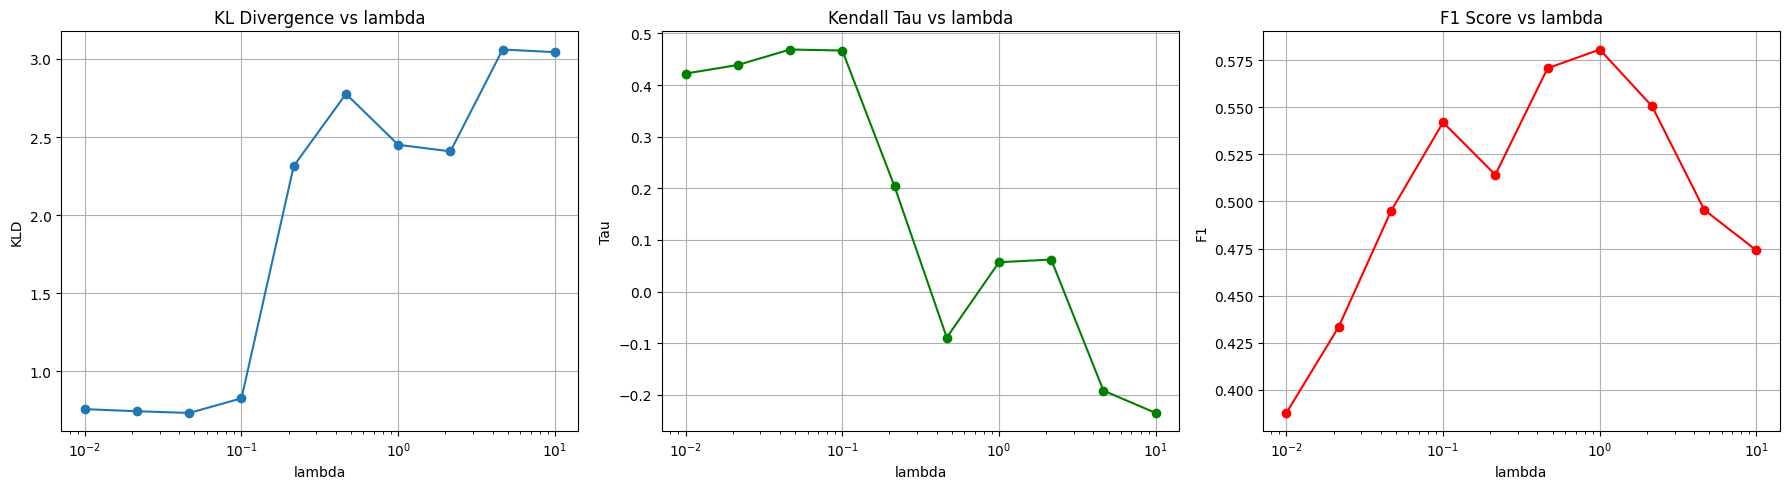

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(metrics_results['lambda_1'], metrics_results['kld'], marker='o')
ax[0].set_xscale('log')
ax[0].set_title("KL Divergence vs lambda_1")
ax[0].set_xlabel("lambda_1")
ax[0].set_ylabel("KLD")
ax[0].grid(True)

ax[1].plot(metrics_results['lambda_1'], metrics_results['tau'], marker='o', color='green')
ax[1].set_xscale('log')
ax[1].set_title("Kendall Tau vs lambda_1")
ax[1].set_xlabel("lambda_1")
ax[1].set_ylabel("Tau")
ax[1].grid(True)

ax[2].plot(metrics_results['lambda_1'], metrics_results['f1'], marker='o', color='red')
ax[2].set_xscale('log')
ax[2].set_title("F1 Score vs lambda_1")
ax[2].set_xlabel("lambda_1")
ax[2].set_ylabel("F1")
ax[2].grid(True)

plt.tight_layout()
plt.show()


### Анализ

Эксперимент демонстрирует:

- при **λ₁ < 0.1** метрики показывают оптимальное сочетание:  
  - **низкая KLD**,  
  - **высокий Kendall’s tau**,  
  - **устойчивый рост F1**.

- при **λ₁ > 0.1** наблюдается деградация качества:  
  - KLD резко увеличивается,  
  - tau падает,  
  - происходит переоценка роли популярности и потеря качества по предпочтениям.


# Лямбда 2

Теперь проанализируем влияние параметра **λ₂** в модели PropCare.

Параметр $ \lambda_2 $ отвечает за силу регуляризации склонностей к показу через компоненту $ \mathcal{L}_{\text{reg}} $ в итоговой функции потерь модели PropCare. Регуляризатор основан на KL-дивергенции между распределением предсказанных склонностей $ \hat{p}_{ui} $ и фиксированным априорным бета-распределением, обычно  $ \text{Beta}(\alpha = 0.2, \beta = 1.0) $.

Цель этой регуляризации — **стабилизировать оценки склонности**, подавляя шум,  
особенно в условиях ограниченного числа наблюдений.

---

### Как влияет λ₂?

Если:

- **λ₂ слишком мало (близко к 0)**  
  Регуляризация почти не действует.  
  Модель начинает подстраиваться под шум и аномалии, что ведёт к нестабильности и снижению обобщающей способности.

- **λ₂ слишком велико**  
  Модель начинает чрезмерно следовать априорному распределению.  
  Она игнорирует реальные данные, склонности становятся слишком сглаженными,  
  теряется способность точно восстанавливать вероятность показа.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lambda_values = np.logspace(-6, 0, 7)
metrics_results = {
    'lambda_2': [],
    'kld': [],
    'tau': [],
    'f1': []
}

for lmb in lambda_values:
    class Args:
        dimension = 200
        embedding_layer_units = [512, 256]
        estimator_layer_units = [64, 32, 16]
        lambda_1 = 0.1
        lambda_2 = lmb
        lr = 0.0085
        

    args = Args()
    
    model = PropCare(all_datasets['CP']['num_users'], all_datasets['CP']['num_items'], args=args, item_popularity=all_datasets['CP']['item_popularity'], device='cuda')

    model.fit(all_datasets['CP']['train'], all_datasets['CP']['vali'], batch_size=4096, epochs=25)
    model.save_model(dir_path=f"saved_models/propcare/lambda2_CP", model_name=f"model_lmb{lmb}")
    val_metrics = model.get_metrics(all_datasets['CP']['vali'])


    metrics_results['lambda_2'].append(lmb)
    metrics_results['kld'].append(val_metrics['kld'])
    metrics_results['tau'].append(val_metrics['tau'])
    metrics_results['f1'].append(val_metrics['f1'])


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.77batch/s]


Epoch 0: train loss = 0.3678 | val corr = {'kld': np.float64(1.1030104063474602), 'tau': np.float64(0.07573043290567211), 'f1': 0.2657991364250635}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 138.82batch/s]


Epoch 1: train loss = 0.3338 | val corr = {'kld': np.float64(1.0300827853884995), 'tau': np.float64(0.13925359284157157), 'f1': 0.3069892680954066}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.34batch/s]


Epoch 2: train loss = 0.3291 | val corr = {'kld': np.float64(0.965121009725936), 'tau': np.float64(0.19802200642436465), 'f1': 0.3460684115051492}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.68batch/s]


Epoch 3: train loss = 0.3260 | val corr = {'kld': np.float64(0.9112726702482695), 'tau': np.float64(0.24721818141954144), 'f1': 0.3810056588241886}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.34batch/s]


Epoch 4: train loss = 0.3233 | val corr = {'kld': np.float64(0.8661254395753162), 'tau': np.float64(0.2890511478420487), 'f1': 0.4094864391039596}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.79batch/s]


Epoch 5: train loss = 0.3207 | val corr = {'kld': np.float64(0.8317595767436134), 'tau': np.float64(0.3236429723413457), 'f1': 0.43329696053173716}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.97batch/s]


Epoch 6: train loss = 0.3183 | val corr = {'kld': np.float64(0.8040743427236015), 'tau': np.float64(0.35332704575884927), 'f1': 0.45384820613123317}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:15<00:00, 125.08batch/s]


Epoch 7: train loss = 0.3161 | val corr = {'kld': np.float64(0.7821474429347275), 'tau': np.float64(0.37900351568047314), 'f1': 0.47147017532700597}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.94batch/s]


Epoch 8: train loss = 0.3139 | val corr = {'kld': np.float64(0.7669643348516296), 'tau': np.float64(0.4004340013605332), 'f1': 0.4865638760558501}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 130.24batch/s]


Epoch 9: train loss = 0.3118 | val corr = {'kld': np.float64(0.7567790412797004), 'tau': np.float64(0.4185597394586916), 'f1': 0.4988674003632867}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 139.85batch/s]


Epoch 10: train loss = 0.3098 | val corr = {'kld': np.float64(0.7535991508935485), 'tau': np.float64(0.4322542523199788), 'f1': 0.5085670930894223}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.29batch/s]


Epoch 11: train loss = 0.3079 | val corr = {'kld': np.float64(0.750035414490263), 'tau': np.float64(0.44429512780439634), 'f1': 0.5162226811579086}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.18batch/s]


Epoch 12: train loss = 0.3061 | val corr = {'kld': np.float64(0.7502422092239898), 'tau': np.float64(0.45410847647118363), 'f1': 0.5222508986845553}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 134.84batch/s]


Epoch 13: train loss = 0.3045 | val corr = {'kld': np.float64(0.7533318382006654), 'tau': np.float64(0.46110411284749486), 'f1': 0.5268963927390333}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.56batch/s]


Epoch 14: train loss = 0.3029 | val corr = {'kld': np.float64(0.7557491625208141), 'tau': np.float64(0.46766612895124804), 'f1': 0.5305453954456272}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.55batch/s]


Epoch 15: train loss = 0.3014 | val corr = {'kld': np.float64(0.7576814709570419), 'tau': np.float64(0.4730864601351424), 'f1': 0.5332079112317321}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.08batch/s]


Epoch 16: train loss = 0.3000 | val corr = {'kld': np.float64(0.7698051845028134), 'tau': np.float64(0.47264187842249994), 'f1': 0.5349603821169027}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 141.00batch/s]


Epoch 17: train loss = 0.2986 | val corr = {'kld': np.float64(0.7726066117224323), 'tau': np.float64(0.47694518492894206), 'f1': 0.5361945910514985}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.50batch/s]


Epoch 18: train loss = 0.2974 | val corr = {'kld': np.float64(0.7849056283046768), 'tau': np.float64(0.4748260574930231), 'f1': 0.5377175953175992}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.91batch/s]


Epoch 19: train loss = 0.2961 | val corr = {'kld': np.float64(0.7863155691850306), 'tau': np.float64(0.477700564650075), 'f1': 0.5395373191624009}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 152.78batch/s]


Epoch 20: train loss = 0.2950 | val corr = {'kld': np.float64(0.7973084600947486), 'tau': np.float64(0.4750860895892672), 'f1': 0.5398705129654187}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.14batch/s]


Epoch 21: train loss = 0.2939 | val corr = {'kld': np.float64(0.804201128171758), 'tau': np.float64(0.47461227178370297), 'f1': 0.5407070231706497}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.12batch/s]


Epoch 22: train loss = 0.2928 | val corr = {'kld': np.float64(0.8123751433511618), 'tau': np.float64(0.47301761737074743), 'f1': 0.541251120419277}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 132.00batch/s]


Epoch 23: train loss = 0.2918 | val corr = {'kld': np.float64(0.8244717501691587), 'tau': np.float64(0.4682178868662675), 'f1': 0.5413560417091979}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.35batch/s]


Epoch 24: train loss = 0.2908 | val corr = {'kld': np.float64(0.8315679443903731), 'tau': np.float64(0.4651910888526474), 'f1': 0.5424412367455498}
Model saved to: saved_models/propcare/lambda2_CP/model_lmb1e-06


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 133.22batch/s]


Epoch 0: train loss = 0.3678 | val corr = {'kld': np.float64(1.1028470506518622), 'tau': np.float64(0.07536936335677817), 'f1': 0.26539551492248814}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.98batch/s]


Epoch 1: train loss = 0.3338 | val corr = {'kld': np.float64(1.0305799773317805), 'tau': np.float64(0.13889247543463965), 'f1': 0.306647531513113}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:15<00:00, 124.46batch/s]


Epoch 2: train loss = 0.3291 | val corr = {'kld': np.float64(0.9666016553268126), 'tau': np.float64(0.19690619104589438), 'f1': 0.3457740487861954}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.32batch/s]


Epoch 3: train loss = 0.3260 | val corr = {'kld': np.float64(0.9124620737967257), 'tau': np.float64(0.24657336300580968), 'f1': 0.37981918204513654}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:18<00:00, 103.53batch/s]


Epoch 4: train loss = 0.3233 | val corr = {'kld': np.float64(0.8677825936731685), 'tau': np.float64(0.2880345063791895), 'f1': 0.4087666809814092}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:15<00:00, 125.18batch/s]


Epoch 5: train loss = 0.3207 | val corr = {'kld': np.float64(0.8319527265869832), 'tau': np.float64(0.3229879330141689), 'f1': 0.433315540643587}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.01batch/s]


Epoch 6: train loss = 0.3183 | val corr = {'kld': np.float64(0.8043946612601781), 'tau': np.float64(0.3530396403822991), 'f1': 0.4537102062054486}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.61batch/s]


Epoch 7: train loss = 0.3160 | val corr = {'kld': np.float64(0.7813254205548747), 'tau': np.float64(0.3795318321823886), 'f1': 0.47174972717351765}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 130.22batch/s]


Epoch 8: train loss = 0.3138 | val corr = {'kld': np.float64(0.7703047461944711), 'tau': np.float64(0.3994546297755904), 'f1': 0.4865870956208976}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.89batch/s]


Epoch 9: train loss = 0.3117 | val corr = {'kld': np.float64(0.7567641802571742), 'tau': np.float64(0.4182661037330757), 'f1': 0.4993644364923326}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 127.72batch/s]


Epoch 10: train loss = 0.3097 | val corr = {'kld': np.float64(0.7533822164080999), 'tau': np.float64(0.43256422480788265), 'f1': 0.5088298116300994}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.60batch/s]


Epoch 11: train loss = 0.3078 | val corr = {'kld': np.float64(0.7496055219816614), 'tau': np.float64(0.4450661526602984), 'f1': 0.516927606048441}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.14batch/s]


Epoch 12: train loss = 0.3060 | val corr = {'kld': np.float64(0.7507575172254137), 'tau': np.float64(0.45383381976325243), 'f1': 0.5228381538482678}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 145.07batch/s]


Epoch 13: train loss = 0.3044 | val corr = {'kld': np.float64(0.7527034007799038), 'tau': np.float64(0.4621440304549112), 'f1': 0.5269343614836304}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.16batch/s]


Epoch 14: train loss = 0.3028 | val corr = {'kld': np.float64(0.7601391069190541), 'tau': np.float64(0.46656445829404053), 'f1': 0.530344794154864}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.54batch/s]


Epoch 15: train loss = 0.3013 | val corr = {'kld': np.float64(0.761191617833482), 'tau': np.float64(0.4720023084379208), 'f1': 0.5333830833395521}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.54batch/s]


Epoch 16: train loss = 0.2999 | val corr = {'kld': np.float64(0.7674734755075082), 'tau': np.float64(0.4741699233247212), 'f1': 0.5353067680348299}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.04batch/s]


Epoch 17: train loss = 0.2985 | val corr = {'kld': np.float64(0.7719733664095303), 'tau': np.float64(0.47747086998796917), 'f1': 0.5370589489001741}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.44batch/s]


Epoch 18: train loss = 0.2973 | val corr = {'kld': np.float64(0.7864828994844647), 'tau': np.float64(0.47384183398740065), 'f1': 0.5380252043189878}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.41batch/s]


Epoch 19: train loss = 0.2960 | val corr = {'kld': np.float64(0.793084472512859), 'tau': np.float64(0.47479397752830177), 'f1': 0.5389164348096296}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.84batch/s]


Epoch 20: train loss = 0.2949 | val corr = {'kld': np.float64(0.7964886808192083), 'tau': np.float64(0.47623487056623587), 'f1': 0.540141116385994}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.07batch/s]


Epoch 21: train loss = 0.2938 | val corr = {'kld': np.float64(0.8082439180212948), 'tau': np.float64(0.47200025406239376), 'f1': 0.5405133676672754}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.41batch/s]


Epoch 22: train loss = 0.2927 | val corr = {'kld': np.float64(0.8175675037454673), 'tau': np.float64(0.46952742431822675), 'f1': 0.5411602500915755}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.23batch/s]


Epoch 23: train loss = 0.2917 | val corr = {'kld': np.float64(0.830109778497336), 'tau': np.float64(0.46516189857908224), 'f1': 0.5412894660642383}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:16<00:00, 114.91batch/s]


Epoch 24: train loss = 0.2907 | val corr = {'kld': np.float64(0.8368536304732657), 'tau': np.float64(0.46243019862261914), 'f1': 0.5419344798070189}
Model saved to: saved_models/propcare/lambda2_CP/model_lmb1e-05


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 126.29batch/s]


Epoch 0: train loss = 0.3678 | val corr = {'kld': np.float64(1.1031481363273468), 'tau': np.float64(0.07585433333543583), 'f1': 0.26563663746523786}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 126.50batch/s]


Epoch 1: train loss = 0.3339 | val corr = {'kld': np.float64(1.0305530923969322), 'tau': np.float64(0.13924774237697782), 'f1': 0.3065480054755289}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.31batch/s]


Epoch 2: train loss = 0.3291 | val corr = {'kld': np.float64(0.96628489673088), 'tau': np.float64(0.1971831340510889), 'f1': 0.34653294896260506}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 129.10batch/s]


Epoch 3: train loss = 0.3260 | val corr = {'kld': np.float64(0.9119321367541449), 'tau': np.float64(0.24661387618067163), 'f1': 0.3812642422887412}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.71batch/s]


Epoch 4: train loss = 0.3233 | val corr = {'kld': np.float64(0.867982771555327), 'tau': np.float64(0.28775687918265996), 'f1': 0.4094351471506517}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.80batch/s]


Epoch 5: train loss = 0.3207 | val corr = {'kld': np.float64(0.8326294547369799), 'tau': np.float64(0.3231838848298216), 'f1': 0.4331916911282996}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.21batch/s]


Epoch 6: train loss = 0.3183 | val corr = {'kld': np.float64(0.8038732248937388), 'tau': np.float64(0.35306672739256173), 'f1': 0.45420531288519056}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 129.06batch/s]


Epoch 7: train loss = 0.3160 | val corr = {'kld': np.float64(0.7830925081766638), 'tau': np.float64(0.37867967706467953), 'f1': 0.47197933569439876}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.14batch/s]


Epoch 8: train loss = 0.3139 | val corr = {'kld': np.float64(0.7668129822935491), 'tau': np.float64(0.40036842460207017), 'f1': 0.486800075286625}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 130.37batch/s]


Epoch 9: train loss = 0.3118 | val corr = {'kld': np.float64(0.7572825437607126), 'tau': np.float64(0.41872151026892557), 'f1': 0.4990197383011754}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.70batch/s]


Epoch 10: train loss = 0.3097 | val corr = {'kld': np.float64(0.7516490105992389), 'tau': np.float64(0.4322341384727263), 'f1': 0.5090323548355788}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 134.85batch/s]


Epoch 11: train loss = 0.3079 | val corr = {'kld': np.float64(0.7484339009089259), 'tau': np.float64(0.444792370418893), 'f1': 0.5165481273217759}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.77batch/s]


Epoch 12: train loss = 0.3061 | val corr = {'kld': np.float64(0.7530714748135472), 'tau': np.float64(0.45281173869853464), 'f1': 0.5225959864154547}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.48batch/s]


Epoch 13: train loss = 0.3045 | val corr = {'kld': np.float64(0.7518695702272046), 'tau': np.float64(0.46244212790664535), 'f1': 0.5266119645297694}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.75batch/s]


Epoch 14: train loss = 0.3029 | val corr = {'kld': np.float64(0.754320000906665), 'tau': np.float64(0.4682899450613734), 'f1': 0.5306652605913241}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.99batch/s]


Epoch 15: train loss = 0.3014 | val corr = {'kld': np.float64(0.7632398296191071), 'tau': np.float64(0.4707405321454393), 'f1': 0.5331237550419764}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.90batch/s]


Epoch 16: train loss = 0.3000 | val corr = {'kld': np.float64(0.7682352501429044), 'tau': np.float64(0.4733873630501113), 'f1': 0.5351589917237185}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.78batch/s]


Epoch 17: train loss = 0.2987 | val corr = {'kld': np.float64(0.772296729496398), 'tau': np.float64(0.477233942677984), 'f1': 0.5368296544082835}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.52batch/s]


Epoch 18: train loss = 0.2974 | val corr = {'kld': np.float64(0.7798145560525722), 'tau': np.float64(0.47703246138169814), 'f1': 0.5378564849243516}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.44batch/s]


Epoch 19: train loss = 0.2962 | val corr = {'kld': np.float64(0.7885419782057721), 'tau': np.float64(0.47586471361923177), 'f1': 0.5391845863493192}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.05batch/s]


Epoch 20: train loss = 0.2950 | val corr = {'kld': np.float64(0.8019165922442963), 'tau': np.float64(0.47246322269181473), 'f1': 0.5398483887932911}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:16<00:00, 112.53batch/s]


Epoch 21: train loss = 0.2939 | val corr = {'kld': np.float64(0.8048089233141448), 'tau': np.float64(0.4738561332128578), 'f1': 0.5409777666349572}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 124.74batch/s]


Epoch 22: train loss = 0.2928 | val corr = {'kld': np.float64(0.8172324310184969), 'tau': np.float64(0.4686962033205408), 'f1': 0.5409022546947951}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 119.17batch/s]


Epoch 23: train loss = 0.2918 | val corr = {'kld': np.float64(0.8252550327672169), 'tau': np.float64(0.46703362009641525), 'f1': 0.5417402506881982}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.73batch/s]


Epoch 24: train loss = 0.2909 | val corr = {'kld': np.float64(0.8377548905551169), 'tau': np.float64(0.4629946455992192), 'f1': 0.5413525195048801}
Model saved to: saved_models/propcare/lambda2_CP/model_lmb0.0001


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.53batch/s]


Epoch 0: train loss = 0.3679 | val corr = {'kld': np.float64(1.1025167724658484), 'tau': np.float64(0.07570674150623738), 'f1': 0.26568881639702724}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.52batch/s]


Epoch 1: train loss = 0.3340 | val corr = {'kld': np.float64(1.0302930115061495), 'tau': np.float64(0.13895088492094962), 'f1': 0.30672411728435006}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.88batch/s]


Epoch 2: train loss = 0.3293 | val corr = {'kld': np.float64(0.9662116859860742), 'tau': np.float64(0.19686550659000396), 'f1': 0.34598831560074644}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.34batch/s]


Epoch 3: train loss = 0.3262 | val corr = {'kld': np.float64(0.9125953441174618), 'tau': np.float64(0.24601943356178432), 'f1': 0.3810296254228245}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 133.61batch/s]


Epoch 4: train loss = 0.3235 | val corr = {'kld': np.float64(0.8684949306936248), 'tau': np.float64(0.28703077461563375), 'f1': 0.4097655693316232}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 145.09batch/s]


Epoch 5: train loss = 0.3210 | val corr = {'kld': np.float64(0.8317548653768903), 'tau': np.float64(0.32290147547023945), 'f1': 0.43338792833209416}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 133.09batch/s]


Epoch 6: train loss = 0.3186 | val corr = {'kld': np.float64(0.8046654193090024), 'tau': np.float64(0.3527089963885163), 'f1': 0.45370292985853977}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.76batch/s]


Epoch 7: train loss = 0.3163 | val corr = {'kld': np.float64(0.7824187907734004), 'tau': np.float64(0.3784096167822095), 'f1': 0.47159155160200944}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.14batch/s]


Epoch 8: train loss = 0.3142 | val corr = {'kld': np.float64(0.7683024516899923), 'tau': np.float64(0.39967989937585113), 'f1': 0.4867999570031173}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.37batch/s]


Epoch 9: train loss = 0.3121 | val corr = {'kld': np.float64(0.7597951055292516), 'tau': np.float64(0.41691971705601666), 'f1': 0.4987919334646391}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 132.14batch/s]


Epoch 10: train loss = 0.3101 | val corr = {'kld': np.float64(0.752461594758883), 'tau': np.float64(0.43212171377307984), 'f1': 0.5084389812918969}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.94batch/s]


Epoch 11: train loss = 0.3082 | val corr = {'kld': np.float64(0.7511031601724417), 'tau': np.float64(0.44392081988436877), 'f1': 0.5162497679098065}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 134.95batch/s]


Epoch 12: train loss = 0.3065 | val corr = {'kld': np.float64(0.7504796212749372), 'tau': np.float64(0.453236308289564), 'f1': 0.522332702763574}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.97batch/s]


Epoch 13: train loss = 0.3048 | val corr = {'kld': np.float64(0.7540328464057926), 'tau': np.float64(0.4597761709678551), 'f1': 0.5271188348111425}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 131.21batch/s]


Epoch 14: train loss = 0.3033 | val corr = {'kld': np.float64(0.7627129522145507), 'tau': np.float64(0.46375870213716885), 'f1': 0.5298265161413352}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.70batch/s]


Epoch 15: train loss = 0.3018 | val corr = {'kld': np.float64(0.7651504089347424), 'tau': np.float64(0.4689953050933342), 'f1': 0.5322724886193825}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 131.15batch/s]


Epoch 16: train loss = 0.3004 | val corr = {'kld': np.float64(0.7688258357371937), 'tau': np.float64(0.4727085262592367), 'f1': 0.5339795850137888}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.76batch/s]


Epoch 17: train loss = 0.2991 | val corr = {'kld': np.float64(0.7752151228077031), 'tau': np.float64(0.4742714179966733), 'f1': 0.535904403826825}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 124.99batch/s]


Epoch 18: train loss = 0.2978 | val corr = {'kld': np.float64(0.7875504652692091), 'tau': np.float64(0.4728140469556792), 'f1': 0.5367155099145616}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.06batch/s]


Epoch 19: train loss = 0.2966 | val corr = {'kld': np.float64(0.7894918013384915), 'tau': np.float64(0.4743010249075468), 'f1': 0.5386550792254643}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 127.81batch/s]


Epoch 20: train loss = 0.2955 | val corr = {'kld': np.float64(0.7954437110261365), 'tau': np.float64(0.4738063272069748), 'f1': 0.5394826220979034}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.48batch/s]


Epoch 21: train loss = 0.2943 | val corr = {'kld': np.float64(0.8074572744146071), 'tau': np.float64(0.4711977780331405), 'f1': 0.5398693036551578}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.35batch/s]


Epoch 22: train loss = 0.2933 | val corr = {'kld': np.float64(0.8194769104291125), 'tau': np.float64(0.4674521159817162), 'f1': 0.5402463361080083}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.65batch/s]


Epoch 23: train loss = 0.2923 | val corr = {'kld': np.float64(0.8303101137858804), 'tau': np.float64(0.4620939819080986), 'f1': 0.5401571861798302}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 129.99batch/s]


Epoch 24: train loss = 0.2913 | val corr = {'kld': np.float64(0.8359356499026876), 'tau': np.float64(0.46039895826867805), 'f1': 0.540714470798897}
Model saved to: saved_models/propcare/lambda2_CP/model_lmb0.001


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.01batch/s]


Epoch 0: train loss = 0.3690 | val corr = {'kld': np.float64(1.1029757232647284), 'tau': np.float64(0.07521701853457337), 'f1': 0.2654929323110768}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.18batch/s]


Epoch 1: train loss = 0.3358 | val corr = {'kld': np.float64(1.0336918827513724), 'tau': np.float64(0.13602354910879585), 'f1': 0.3059766734957385}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.02batch/s]


Epoch 2: train loss = 0.3312 | val corr = {'kld': np.float64(0.9726933855302377), 'tau': np.float64(0.1927443811949946), 'f1': 0.34455513623897965}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.34batch/s]


Epoch 3: train loss = 0.3282 | val corr = {'kld': np.float64(0.9214015890078012), 'tau': np.float64(0.24086714428166112), 'f1': 0.3786519260898968}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 151.54batch/s]


Epoch 4: train loss = 0.3255 | val corr = {'kld': np.float64(0.8780423938192798), 'tau': np.float64(0.2825713820192183), 'f1': 0.40764375402195574}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 134.61batch/s]


Epoch 5: train loss = 0.3231 | val corr = {'kld': np.float64(0.8439118945096846), 'tau': np.float64(0.3178901917950411), 'f1': 0.43149833438466983}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 148.86batch/s]


Epoch 6: train loss = 0.3208 | val corr = {'kld': np.float64(0.8167761059051614), 'tau': np.float64(0.3480485950958445), 'f1': 0.4519814270356627}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.03batch/s]


Epoch 7: train loss = 0.3186 | val corr = {'kld': np.float64(0.7984622294177117), 'tau': np.float64(0.37276989402271915), 'f1': 0.46950498335968416}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 149.21batch/s]


Epoch 8: train loss = 0.3166 | val corr = {'kld': np.float64(0.7833933778462785), 'tau': np.float64(0.39410595508909624), 'f1': 0.4846376680945785}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.01batch/s]


Epoch 9: train loss = 0.3146 | val corr = {'kld': np.float64(0.7736246351087143), 'tau': np.float64(0.41157402890798245), 'f1': 0.4960236404964709}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 143.53batch/s]


Epoch 10: train loss = 0.3128 | val corr = {'kld': np.float64(0.766639392190965), 'tau': np.float64(0.42666564979939325), 'f1': 0.5050733453076189}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 132.45batch/s]


Epoch 11: train loss = 0.3111 | val corr = {'kld': np.float64(0.7656261459807717), 'tau': np.float64(0.4374279701936509), 'f1': 0.5118246758900327}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.47batch/s]


Epoch 12: train loss = 0.3095 | val corr = {'kld': np.float64(0.7628518137500988), 'tau': np.float64(0.44729588676678395), 'f1': 0.5170835475873091}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 127.27batch/s]


Epoch 13: train loss = 0.3080 | val corr = {'kld': np.float64(0.7703233589036037), 'tau': np.float64(0.4511738815394979), 'f1': 0.5204099346136289}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 131.85batch/s]


Epoch 14: train loss = 0.3066 | val corr = {'kld': np.float64(0.7731900141858242), 'tau': np.float64(0.4567154687711884), 'f1': 0.5230043990521221}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 125.09batch/s]


Epoch 15: train loss = 0.3053 | val corr = {'kld': np.float64(0.7794920665925478), 'tau': np.float64(0.458641270034736), 'f1': 0.5248240611111633}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.66batch/s]


Epoch 16: train loss = 0.3040 | val corr = {'kld': np.float64(0.7816222320411051), 'tau': np.float64(0.46191467100734274), 'f1': 0.5264139375868561}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 125.47batch/s]


Epoch 17: train loss = 0.3028 | val corr = {'kld': np.float64(0.7918211355676286), 'tau': np.float64(0.46114260988689926), 'f1': 0.526747733359392}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 141.06batch/s]


Epoch 18: train loss = 0.3016 | val corr = {'kld': np.float64(0.7902803156973932), 'tau': np.float64(0.46468026965231535), 'f1': 0.5282110252221502}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 125.54batch/s]


Epoch 19: train loss = 0.3005 | val corr = {'kld': np.float64(0.810529556580648), 'tau': np.float64(0.4552899323835153), 'f1': 0.5279978645728284}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.99batch/s]


Epoch 20: train loss = 0.2994 | val corr = {'kld': np.float64(0.812564133574824), 'tau': np.float64(0.4561944927674458), 'f1': 0.5288675336992945}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.26batch/s]


Epoch 21: train loss = 0.2984 | val corr = {'kld': np.float64(0.8211154739336016), 'tau': np.float64(0.45253443410282096), 'f1': 0.5284922222796435}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 143.42batch/s]


Epoch 22: train loss = 0.2974 | val corr = {'kld': np.float64(0.8300688870748423), 'tau': np.float64(0.4483619529250392), 'f1': 0.5288991348533149}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 131.21batch/s]


Epoch 23: train loss = 0.2964 | val corr = {'kld': np.float64(0.8484143732330497), 'tau': np.float64(0.4378296412470767), 'f1': 0.5286501566127911}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.66batch/s]


Epoch 24: train loss = 0.2955 | val corr = {'kld': np.float64(0.8487204857306566), 'tau': np.float64(0.4387019067789521), 'f1': 0.5284349022638593}
Model saved to: saved_models/propcare/lambda2_CP/model_lmb0.01


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 134.16batch/s]


Epoch 0: train loss = 0.3761 | val corr = {'kld': np.float64(1.1096940088804625), 'tau': np.float64(0.063930621073831), 'f1': 0.26211390371923365}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 145.06batch/s]


Epoch 1: train loss = 0.3426 | val corr = {'kld': np.float64(1.0610079213738575), 'tau': np.float64(0.10538556824231111), 'f1': 0.29402543941500076}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.42batch/s]


Epoch 2: train loss = 0.3337 | val corr = {'kld': np.float64(1.0213095154754686), 'tau': np.float64(0.1445224986681293), 'f1': 0.3235335027582365}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.27batch/s]


Epoch 3: train loss = 0.3269 | val corr = {'kld': np.float64(0.9857946891161173), 'tau': np.float64(0.18266747730124466), 'f1': 0.35066210530345476}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 130.14batch/s]


Epoch 4: train loss = 0.3212 | val corr = {'kld': np.float64(0.9566567415646196), 'tau': np.float64(0.2165756198869822), 'f1': 0.3746259841695138}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 148.92batch/s]


Epoch 5: train loss = 0.3165 | val corr = {'kld': np.float64(0.9322223983617457), 'tau': np.float64(0.24701282401468366), 'f1': 0.3945522028576676}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.59batch/s]


Epoch 6: train loss = 0.3126 | val corr = {'kld': np.float64(0.9130435026114658), 'tau': np.float64(0.2722480437729205), 'f1': 0.41010680291871016}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.98batch/s]


Epoch 7: train loss = 0.3095 | val corr = {'kld': np.float64(0.8976328347229694), 'tau': np.float64(0.293832042871818), 'f1': 0.4219001567005098}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.46batch/s]


Epoch 8: train loss = 0.3070 | val corr = {'kld': np.float64(0.8839694182158747), 'tau': np.float64(0.3132731777254619), 'f1': 0.430523468550776}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 145.38batch/s]


Epoch 9: train loss = 0.3049 | val corr = {'kld': np.float64(0.8733514221442683), 'tau': np.float64(0.3286913482173647), 'f1': 0.43673846456835747}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 134.89batch/s]


Epoch 10: train loss = 0.3032 | val corr = {'kld': np.float64(0.8631708114389968), 'tau': np.float64(0.34232945091575806), 'f1': 0.44108119948473073}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.03batch/s]


Epoch 11: train loss = 0.3017 | val corr = {'kld': np.float64(0.8533649683492579), 'tau': np.float64(0.35479925938484436), 'f1': 0.44349647405404763}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 129.01batch/s]


Epoch 12: train loss = 0.3005 | val corr = {'kld': np.float64(0.84695518322515), 'tau': np.float64(0.3634141020551871), 'f1': 0.4453707313293891}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 143.54batch/s]


Epoch 13: train loss = 0.2994 | val corr = {'kld': np.float64(0.8381930666130768), 'tau': np.float64(0.3738239344014379), 'f1': 0.4465468558594727}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 126.51batch/s]


Epoch 14: train loss = 0.2984 | val corr = {'kld': np.float64(0.8323722420377776), 'tau': np.float64(0.3806804502455823), 'f1': 0.4471476910448046}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.74batch/s]


Epoch 15: train loss = 0.2976 | val corr = {'kld': np.float64(0.8270550308686198), 'tau': np.float64(0.3875850659667288), 'f1': 0.44661525439448135}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 124.37batch/s]


Epoch 16: train loss = 0.2968 | val corr = {'kld': np.float64(0.8219109267280552), 'tau': np.float64(0.39429597388242826), 'f1': 0.44631606516948596}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 138.66batch/s]


Epoch 17: train loss = 0.2961 | val corr = {'kld': np.float64(0.8180739129370689), 'tau': np.float64(0.3984935785349962), 'f1': 0.44555037674155734}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 128.60batch/s]


Epoch 18: train loss = 0.2954 | val corr = {'kld': np.float64(0.8134321486313054), 'tau': np.float64(0.4036400547932597), 'f1': 0.44491452107032714}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.92batch/s]


Epoch 19: train loss = 0.2947 | val corr = {'kld': np.float64(0.8106171496238888), 'tau': np.float64(0.4065965724375276), 'f1': 0.4440353209532739}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.65batch/s]


Epoch 20: train loss = 0.2941 | val corr = {'kld': np.float64(0.8078012263558935), 'tau': np.float64(0.4103838876836484), 'f1': 0.44283371619019796}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.84batch/s]


Epoch 21: train loss = 0.2935 | val corr = {'kld': np.float64(0.8061050534283933), 'tau': np.float64(0.4125406871446536), 'f1': 0.44200451346385033}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.35batch/s]


Epoch 22: train loss = 0.2930 | val corr = {'kld': np.float64(0.8027024189850765), 'tau': np.float64(0.41619757189027445), 'f1': 0.4405745335714557}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.28batch/s]


Epoch 23: train loss = 0.2924 | val corr = {'kld': np.float64(0.8014178777472922), 'tau': np.float64(0.41863707271075995), 'f1': 0.43977198725164207}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 136.03batch/s]


Epoch 24: train loss = 0.2919 | val corr = {'kld': np.float64(0.7994777995722445), 'tau': np.float64(0.4203484488506218), 'f1': 0.43874159511934785}
Model saved to: saved_models/propcare/lambda2_CP/model_lmb0.1


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.37batch/s]


Epoch 0: train loss = 0.2672 | val corr = {'kld': np.float64(1.1294890954802532), 'tau': np.float64(0.04511993494462777), 'f1': 0.24729945763416225}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.33batch/s]


Epoch 1: train loss = 0.1097 | val corr = {'kld': np.float64(1.0843974743149651), 'tau': np.float64(0.07719628283221748), 'f1': 0.2528396775387809}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.12batch/s]


Epoch 2: train loss = 0.0749 | val corr = {'kld': np.float64(1.0445491138871519), 'tau': np.float64(0.10839423178604009), 'f1': 0.2536665832557508}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.61batch/s]


Epoch 3: train loss = 0.0637 | val corr = {'kld': np.float64(1.0136170384042862), 'tau': np.float64(0.13507809923630645), 'f1': 0.25405023086983214}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.81batch/s]


Epoch 4: train loss = 0.0589 | val corr = {'kld': np.float64(0.9886529271738534), 'tau': np.float64(0.15831421003874777), 'f1': 0.254195127527794}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 132.20batch/s]


Epoch 5: train loss = 0.0563 | val corr = {'kld': np.float64(0.9661584157306355), 'tau': np.float64(0.17958328117125064), 'f1': 0.25439012283392803}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 141.35batch/s]


Epoch 6: train loss = 0.0543 | val corr = {'kld': np.float64(0.9471037204157872), 'tau': np.float64(0.19870570382204525), 'f1': 0.25429717075139824}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 130.06batch/s]


Epoch 7: train loss = 0.0529 | val corr = {'kld': np.float64(0.9304483691285897), 'tau': np.float64(0.2157924960831846), 'f1': 0.25404065905266493}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.23batch/s]


Epoch 8: train loss = 0.0518 | val corr = {'kld': np.float64(0.9151722757082194), 'tau': np.float64(0.23140791412087633), 'f1': 0.25399480507411837}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:15<00:00, 125.18batch/s]


Epoch 9: train loss = 0.0510 | val corr = {'kld': np.float64(0.9018169993260935), 'tau': np.float64(0.24567839068938188), 'f1': 0.2541343823621196}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.53batch/s]


Epoch 10: train loss = 0.0502 | val corr = {'kld': np.float64(0.8895652586737206), 'tau': np.float64(0.2582163759749856), 'f1': 0.25388071524892813}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 123.38batch/s]


Epoch 11: train loss = 0.0494 | val corr = {'kld': np.float64(0.8792645568943999), 'tau': np.float64(0.2693974079382156), 'f1': 0.2539104447855618}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.69batch/s]


Epoch 12: train loss = 0.0487 | val corr = {'kld': np.float64(0.8691835702816106), 'tau': np.float64(0.2813111862921661), 'f1': 0.253837027484971}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.63batch/s]


Epoch 13: train loss = 0.0482 | val corr = {'kld': np.float64(0.8604033732869171), 'tau': np.float64(0.2902899176134785), 'f1': 0.2537050040235452}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.99batch/s]


Epoch 14: train loss = 0.0476 | val corr = {'kld': np.float64(0.8525308496479874), 'tau': np.float64(0.2997150493274156), 'f1': 0.2536062694244075}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 127.96batch/s]


Epoch 15: train loss = 0.0469 | val corr = {'kld': np.float64(0.8458614999829277), 'tau': np.float64(0.3078080877542131), 'f1': 0.253539043086489}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.86batch/s]


Epoch 16: train loss = 0.0465 | val corr = {'kld': np.float64(0.8399222830321041), 'tau': np.float64(0.31535411534238994), 'f1': 0.2535698467023781}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.44batch/s]


Epoch 17: train loss = 0.0460 | val corr = {'kld': np.float64(0.8345809413483015), 'tau': np.float64(0.32232717037870406), 'f1': 0.25342361411779796}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.66batch/s]


Epoch 18: train loss = 0.0454 | val corr = {'kld': np.float64(0.8292432578439407), 'tau': np.float64(0.3291369724297622), 'f1': 0.2533175834050416}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 129.51batch/s]


Epoch 19: train loss = 0.0449 | val corr = {'kld': np.float64(0.8257376367513279), 'tau': np.float64(0.3350585185157194), 'f1': 0.2531263451865935}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.91batch/s]


Epoch 20: train loss = 0.0444 | val corr = {'kld': np.float64(0.8219927938219923), 'tau': np.float64(0.34025949916283077), 'f1': 0.25304946563341946}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.15batch/s]


Epoch 21: train loss = 0.0438 | val corr = {'kld': np.float64(0.8201216539031535), 'tau': np.float64(0.3452141835736531), 'f1': 0.2527292655680673}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.64batch/s]


Epoch 22: train loss = 0.0434 | val corr = {'kld': np.float64(0.817128883674135), 'tau': np.float64(0.34966145971960244), 'f1': 0.25283243292368396}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 125.77batch/s]


Epoch 23: train loss = 0.0429 | val corr = {'kld': np.float64(0.8156703650243654), 'tau': np.float64(0.3532402667086026), 'f1': 0.25260197299517223}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.16batch/s]


Epoch 24: train loss = 0.0424 | val corr = {'kld': np.float64(0.813406829304558), 'tau': np.float64(0.35728917491006595), 'f1': 0.2524443092678403}
Model saved to: saved_models/propcare/lambda2_CP/model_lmb1.0


### График поведения метрик при разных λ₂

Ниже показано, как изменяются ключевые метрики (KLD, Kendall’s Tau, F1)  при разных значениях параметра на датасете **CP**:

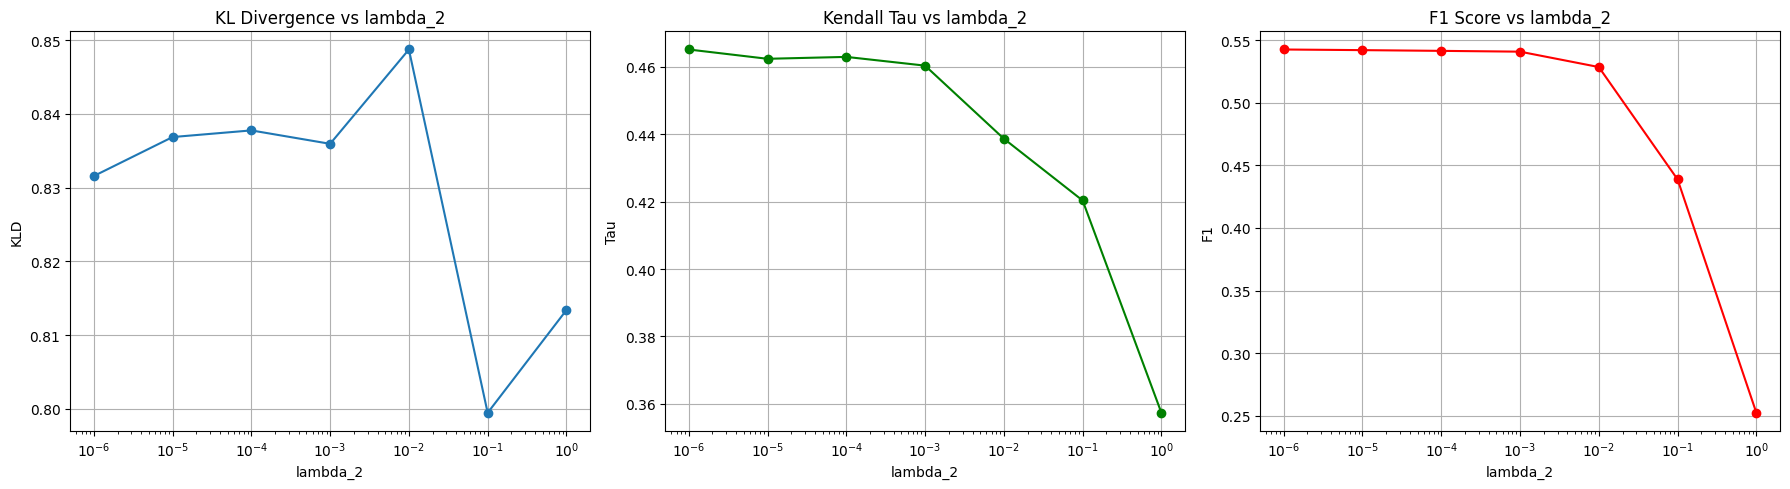

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(metrics_results['lambda_2'], metrics_results['kld'], marker='o')
ax[0].set_xscale('log')
ax[0].set_title("KL Divergence vs lambda_2")
ax[0].set_xlabel("lambda_2")
ax[0].set_ylabel("KLD")
ax[0].grid(True)

ax[1].plot(metrics_results['lambda_2'], metrics_results['tau'], marker='o', color='green')
ax[1].set_xscale('log')
ax[1].set_title("Kendall Tau vs lambda_2")
ax[1].set_xlabel("lambda_2")
ax[1].set_ylabel("Tau")
ax[1].grid(True)

ax[2].plot(metrics_results['lambda_2'], metrics_results['f1'], marker='o', color='red')
ax[2].set_xscale('log')
ax[2].set_title("F1 Score vs lambda_2")
ax[2].set_xlabel("lambda_2")
ax[2].set_ylabel("F1")
ax[2].grid(True)

plt.tight_layout()
plt.show()


Из графика видно:

- при $ \lambda_2 \le 10^{-4} $ все три метрики находятся на хорошем уровне;  
- при $ \lambda_2 > 10^{-3} $ наблюдается провал:  
  - падает Tau → ухудшается качество ранжирования,  
  - резко падает F1 → модель хуже предсказывает бинарные экспозиции,  
  - KLD возрастает → распределение склонностей искажается.


# Абляционный тест

В этом разделе проводится абляционный анализ модели **PropCare**, позволяющий понять вклад ключевых механизмов модели в итоговое качество.  Суть абляционного теста заключается в последовательном отключении отдельных компонент функции потерь и архитектуры, чтобы оценить, какие части действительно важны, а какие могут быть упрощены без значительной потери качества. Ниже представлено описание всех тестируемых режимов.

---

## Таблица режимов абляции

| Режим | Что отключено / изменено | Смысл и назначение |
|-------|---------------------------|---------------------|
| **default** | Ничего | Полная модель: используется кросс-энтропия, $ \mathcal{L}_{pop} $, $ \mathcal{L}_{reg} $. Эталон для сравнения. |
| **NO\_P** | Популярностный компонент $ \mathcal{L}_{pop} $ | Модель сравнивает только релевантности, игнорируя гипотезу о связи популярности и propensity. |
| **NO\_R** | Вклад релевантности в $ \mathcal{L}_{pop} $ | Сравниваются только склонности к показу: модель игнорирует предпочтения пользователей. |
| **NO\_P\_R** | Компонента $ \mathcal{L}_{pop} $ полностью | Остаются только кросс-энтропия и регуляризация. Самый «обрезанный» вариант модели. |
| **NEG** | Инвертируется знак популярности: $ \text{sgn}_{ij} \rightarrow -\text{sgn}_{ij} $ | Проверка устойчивости модели при нарушении ключевой гипотезы: «менее популярные объекты имеют более высокую склонность». |
| **S1** | Веса пар фиксируются: $ \kappa_{u,i,j} = 1 $ | Все пары имеют одинаковую важность. Отключение механизма адаптивного взвешивания по неопределённости. |


In [20]:
metrics_results = {
    'dataset': [],
    'mode': [],
    'kld': [],
    'tau': [],
    'f1': []
}

for dataset in ['CP']:        
    for mode in ["default", "NEG", "S1", "NO_P", "NO_R", "NO_P_R"]:
         
        class Args:
            dimension = 200
            embedding_layer_units = [512, 256]
            estimator_layer_units = [64, 32, 16]
            lambda_1 = 0.1
            lambda_2 = 1e-4
            lr = 0.0085
            ablation_mode = mode

        args = Args()
        
        model = PropCare(
            num_users=all_datasets[dataset]['num_users'],
            num_items=all_datasets[dataset]['num_items'],
            args=args,
            item_popularity=all_datasets[dataset]['item_popularity'],
            device='cuda'
        )

        model.fit(all_datasets[dataset]['train'], all_datasets[dataset]['vali'], batch_size=4096, epochs=25) 
        model.save_model(dir_path=f"saved_models/propcare/ablation", model_name=f"model_{dataset}_{mode}")
        val_metrics = model.get_metrics(all_datasets[dataset]['vali'])

        metrics_results['dataset'].append(dataset)
        metrics_results['mode'].append(mode)
        metrics_results['kld'].append(val_metrics['kld'])
        metrics_results['tau'].append(val_metrics['tau'])
        metrics_results['f1'].append(val_metrics['f1'])

df_results = pd.DataFrame(metrics_results)


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 127.28batch/s]


Epoch 0: train loss = 0.3678 | val corr = {'kld': np.float64(1.1030281650426583), 'tau': np.float64(0.07552803367693736), 'f1': 0.2654800873785}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.46batch/s]


Epoch 1: train loss = 0.3338 | val corr = {'kld': np.float64(1.030832256254435), 'tau': np.float64(0.13877850810438094), 'f1': 0.3069823533571798}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 127.62batch/s]


Epoch 2: train loss = 0.3291 | val corr = {'kld': np.float64(0.9659880983448407), 'tau': np.float64(0.19684937809729694), 'f1': 0.3463161120783531}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.50batch/s]


Epoch 3: train loss = 0.3260 | val corr = {'kld': np.float64(0.9122774556739914), 'tau': np.float64(0.24606716922075808), 'f1': 0.3807964604062347}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 127.24batch/s]


Epoch 4: train loss = 0.3232 | val corr = {'kld': np.float64(0.8669240961583695), 'tau': np.float64(0.28839782252129653), 'f1': 0.40967894020622975}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 149.71batch/s]


Epoch 5: train loss = 0.3207 | val corr = {'kld': np.float64(0.8320719908324736), 'tau': np.float64(0.32306477880299667), 'f1': 0.4335436740394461}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:15<00:00, 122.22batch/s]


Epoch 6: train loss = 0.3183 | val corr = {'kld': np.float64(0.8041122620618052), 'tau': np.float64(0.35269418829710086), 'f1': 0.4539127259448603}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 141.67batch/s]


Epoch 7: train loss = 0.3160 | val corr = {'kld': np.float64(0.7826325700321823), 'tau': np.float64(0.3785361280780999), 'f1': 0.4722507703457916}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.14batch/s]


Epoch 8: train loss = 0.3138 | val corr = {'kld': np.float64(0.7679817327075251), 'tau': np.float64(0.39990483232488405), 'f1': 0.48708675128142104}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 144.91batch/s]


Epoch 9: train loss = 0.3117 | val corr = {'kld': np.float64(0.7574175618238833), 'tau': np.float64(0.4178429476961719), 'f1': 0.49932878014365084}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 127.03batch/s]


Epoch 10: train loss = 0.3097 | val corr = {'kld': np.float64(0.7499769911207748), 'tau': np.float64(0.43329820156624804), 'f1': 0.5092974239289633}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.81batch/s]


Epoch 11: train loss = 0.3079 | val corr = {'kld': np.float64(0.7500589541942148), 'tau': np.float64(0.44423786164653933), 'f1': 0.5168039943107533}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 122.61batch/s]


Epoch 12: train loss = 0.3061 | val corr = {'kld': np.float64(0.7518753559587052), 'tau': np.float64(0.45364938126708604), 'f1': 0.522814561152808}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.69batch/s]


Epoch 13: train loss = 0.3044 | val corr = {'kld': np.float64(0.7550103369182842), 'tau': np.float64(0.460468945194802), 'f1': 0.5274590542187089}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 131.84batch/s]


Epoch 14: train loss = 0.3029 | val corr = {'kld': np.float64(0.7551642145895376), 'tau': np.float64(0.4673364971088837), 'f1': 0.5308310631398184}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 153.39batch/s]


Epoch 15: train loss = 0.3014 | val corr = {'kld': np.float64(0.7656547548206166), 'tau': np.float64(0.46979282922826293), 'f1': 0.5331604598126947}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 132.29batch/s]


Epoch 16: train loss = 0.3000 | val corr = {'kld': np.float64(0.7710817762547176), 'tau': np.float64(0.47252115704127756), 'f1': 0.535533290759161}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 141.33batch/s]


Epoch 17: train loss = 0.2986 | val corr = {'kld': np.float64(0.7765481316787594), 'tau': np.float64(0.4745428372643227), 'f1': 0.5367028399795273}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 127.83batch/s]


Epoch 18: train loss = 0.2973 | val corr = {'kld': np.float64(0.7847091288076267), 'tau': np.float64(0.47491613031502206), 'f1': 0.5381980190990096}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.36batch/s]


Epoch 19: train loss = 0.2961 | val corr = {'kld': np.float64(0.7874120447714427), 'tau': np.float64(0.4769983840628355), 'f1': 0.5396183168710432}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 131.40batch/s]


Epoch 20: train loss = 0.2949 | val corr = {'kld': np.float64(0.800259484369294), 'tau': np.float64(0.47366739463567614), 'f1': 0.5403930400714705}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 151.13batch/s]


Epoch 21: train loss = 0.2938 | val corr = {'kld': np.float64(0.8047811058592453), 'tau': np.float64(0.4733357893298851), 'f1': 0.5409792349865556}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 129.05batch/s]


Epoch 22: train loss = 0.2928 | val corr = {'kld': np.float64(0.8198099593405282), 'tau': np.float64(0.46790599977063985), 'f1': 0.5406247645123207}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 151.40batch/s]


Epoch 23: train loss = 0.2917 | val corr = {'kld': np.float64(0.8304167763978225), 'tau': np.float64(0.46431038332177804), 'f1': 0.5413258173936077}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.70batch/s]


Epoch 24: train loss = 0.2908 | val corr = {'kld': np.float64(0.8363001266423294), 'tau': np.float64(0.4631641610372626), 'f1': 0.5417260736275142}
Model saved to: saved_models/propcare/ablation/model_CP_default


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 151.72batch/s]


Epoch 0: train loss = 0.3669 | val corr = {'kld': np.float64(1.0904479038108317), 'tau': np.float64(0.08448799493066474), 'f1': 0.20977495125629989}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 129.93batch/s]


Epoch 1: train loss = 0.3324 | val corr = {'kld': np.float64(1.0109565305793955), 'tau': np.float64(0.14806059148343914), 'f1': 0.19544159576310924}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 152.52batch/s]


Epoch 2: train loss = 0.3276 | val corr = {'kld': np.float64(0.9489539090250321), 'tau': np.float64(0.19932358684895154), 'f1': 0.1821707307388567}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:15<00:00, 121.80batch/s]


Epoch 3: train loss = 0.3247 | val corr = {'kld': np.float64(0.8997415726183682), 'tau': np.float64(0.24261272183456706), 'f1': 0.16921050934187612}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.79batch/s]


Epoch 4: train loss = 0.3222 | val corr = {'kld': np.float64(0.8606845932394698), 'tau': np.float64(0.279651414636107), 'f1': 0.1572886990805735}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 130.16batch/s]


Epoch 5: train loss = 0.3199 | val corr = {'kld': np.float64(0.8288621251464519), 'tau': np.float64(0.31249787910738785), 'f1': 0.14595915697530598}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 149.06batch/s]


Epoch 6: train loss = 0.3177 | val corr = {'kld': np.float64(0.8060688978110178), 'tau': np.float64(0.3405248736708974), 'f1': 0.1351425559078008}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 128.98batch/s]


Epoch 7: train loss = 0.3156 | val corr = {'kld': np.float64(0.7892618100414175), 'tau': np.float64(0.3646578731611061), 'f1': 0.1246780503729518}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 153.84batch/s]


Epoch 8: train loss = 0.3136 | val corr = {'kld': np.float64(0.7765346097499132), 'tau': np.float64(0.38506626661386373), 'f1': 0.11473435165029425}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.28batch/s]


Epoch 9: train loss = 0.3117 | val corr = {'kld': np.float64(0.7684999940666553), 'tau': np.float64(0.40221613224361624), 'f1': 0.10621703633022118}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.61batch/s]


Epoch 10: train loss = 0.3099 | val corr = {'kld': np.float64(0.7619378105604988), 'tau': np.float64(0.4175055536433093), 'f1': 0.0987368198299753}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 131.17batch/s]


Epoch 11: train loss = 0.3081 | val corr = {'kld': np.float64(0.7673518428443128), 'tau': np.float64(0.4260727778196247), 'f1': 0.09233339113755162}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.14batch/s]


Epoch 12: train loss = 0.3064 | val corr = {'kld': np.float64(0.7654088656250617), 'tau': np.float64(0.43728997690128557), 'f1': 0.08705142674033793}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.37batch/s]


Epoch 13: train loss = 0.3048 | val corr = {'kld': np.float64(0.7678387554652668), 'tau': np.float64(0.4442698709048458), 'f1': 0.08270080277372437}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.81batch/s]


Epoch 14: train loss = 0.3032 | val corr = {'kld': np.float64(0.7737796455479017), 'tau': np.float64(0.4496767147082637), 'f1': 0.07891350950939355}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.36batch/s]


Epoch 15: train loss = 0.3017 | val corr = {'kld': np.float64(0.7785638047987378), 'tau': np.float64(0.4547793389370448), 'f1': 0.07572213759135037}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.15batch/s]


Epoch 16: train loss = 0.3003 | val corr = {'kld': np.float64(0.7835574353927284), 'tau': np.float64(0.45775642748289297), 'f1': 0.0728201861648852}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.38batch/s]


Epoch 17: train loss = 0.2989 | val corr = {'kld': np.float64(0.7948776158586163), 'tau': np.float64(0.4581020407581195), 'f1': 0.07024235722809695}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 153.72batch/s]


Epoch 18: train loss = 0.2976 | val corr = {'kld': np.float64(0.797934438566322), 'tau': np.float64(0.4617614450097365), 'f1': 0.06859791947433422}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.86batch/s]


Epoch 19: train loss = 0.2964 | val corr = {'kld': np.float64(0.8060445614986604), 'tau': np.float64(0.46104625461466675), 'f1': 0.06645212061855238}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 132.88batch/s]


Epoch 20: train loss = 0.2952 | val corr = {'kld': np.float64(0.8190535373896428), 'tau': np.float64(0.4586622883007295), 'f1': 0.06485200279330641}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.95batch/s]


Epoch 21: train loss = 0.2941 | val corr = {'kld': np.float64(0.8312700797351675), 'tau': np.float64(0.45544744101050627), 'f1': 0.06359590483690775}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.77batch/s]


Epoch 22: train loss = 0.2930 | val corr = {'kld': np.float64(0.8312972577605252), 'tau': np.float64(0.45910108696246954), 'f1': 0.06318293109478838}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.60batch/s]


Epoch 23: train loss = 0.2920 | val corr = {'kld': np.float64(0.8486118061811632), 'tau': np.float64(0.45152095172095663), 'f1': 0.06179574528908688}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 124.53batch/s]


Epoch 24: train loss = 0.2910 | val corr = {'kld': np.float64(0.8619945791987359), 'tau': np.float64(0.4477102720067492), 'f1': 0.06144805603910581}
Model saved to: saved_models/propcare/ablation/model_CP_NEG


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 147.57batch/s]


Epoch 0: train loss = 0.3681 | val corr = {'kld': np.float64(1.103802265774322), 'tau': np.float64(0.07367632916040398), 'f1': 0.2646858134535869}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 134.41batch/s]


Epoch 1: train loss = 0.3342 | val corr = {'kld': np.float64(1.0335392467949864), 'tau': np.float64(0.1361391006142485), 'f1': 0.3055450991318369}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 152.52batch/s]


Epoch 2: train loss = 0.3296 | val corr = {'kld': np.float64(0.970378324891236), 'tau': np.float64(0.1937984982887289), 'f1': 0.34470283319167916}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 134.20batch/s]


Epoch 3: train loss = 0.3265 | val corr = {'kld': np.float64(0.9168163215251851), 'tau': np.float64(0.24305193420961327), 'f1': 0.37883520212325245}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 151.09batch/s]


Epoch 4: train loss = 0.3239 | val corr = {'kld': np.float64(0.8715376874073468), 'tau': np.float64(0.2845549856389993), 'f1': 0.4070172247131295}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 137.45batch/s]


Epoch 5: train loss = 0.3214 | val corr = {'kld': np.float64(0.8367141681488718), 'tau': np.float64(0.3195699102775632), 'f1': 0.430835085951538}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 152.15batch/s]


Epoch 6: train loss = 0.3191 | val corr = {'kld': np.float64(0.8097456821001442), 'tau': np.float64(0.34856615531741847), 'f1': 0.45102586780502896}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 133.76batch/s]


Epoch 7: train loss = 0.3168 | val corr = {'kld': np.float64(0.786422435342673), 'tau': np.float64(0.374991285351625), 'f1': 0.46899395061705895}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 153.55batch/s]


Epoch 8: train loss = 0.3147 | val corr = {'kld': np.float64(0.7715566907100091), 'tau': np.float64(0.39680990753621886), 'f1': 0.48418626634556955}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.82batch/s]


Epoch 9: train loss = 0.3125 | val corr = {'kld': np.float64(0.7609061768616041), 'tau': np.float64(0.41447387995151386), 'f1': 0.4971017380636018}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 156.75batch/s]


Epoch 10: train loss = 0.3105 | val corr = {'kld': np.float64(0.7522094802841582), 'tau': np.float64(0.43017236202170406), 'f1': 0.5071923536439665}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.51batch/s]


Epoch 11: train loss = 0.3087 | val corr = {'kld': np.float64(0.7489369396349197), 'tau': np.float64(0.4429282190728077), 'f1': 0.5152400135152478}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 152.13batch/s]


Epoch 12: train loss = 0.3069 | val corr = {'kld': np.float64(0.7522817816349088), 'tau': np.float64(0.4519708512579953), 'f1': 0.5209160608663409}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 155.13batch/s]


Epoch 13: train loss = 0.3052 | val corr = {'kld': np.float64(0.7496171025309784), 'tau': np.float64(0.4614253638331387), 'f1': 0.5260542657666004}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 154.83batch/s]


Epoch 14: train loss = 0.3037 | val corr = {'kld': np.float64(0.7555438907127442), 'tau': np.float64(0.4660124169051225), 'f1': 0.5295764097491008}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 154.25batch/s]


Epoch 15: train loss = 0.3021 | val corr = {'kld': np.float64(0.7587277192934692), 'tau': np.float64(0.4708683830484162), 'f1': 0.5326611507535013}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 135.57batch/s]


Epoch 16: train loss = 0.3008 | val corr = {'kld': np.float64(0.7611075055408064), 'tau': np.float64(0.476015291961212), 'f1': 0.5346257626252847}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.88batch/s]


Epoch 17: train loss = 0.2994 | val corr = {'kld': np.float64(0.7662022039821087), 'tau': np.float64(0.47866900972273374), 'f1': 0.5364189352356462}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.19batch/s]


Epoch 18: train loss = 0.2981 | val corr = {'kld': np.float64(0.777549769188117), 'tau': np.float64(0.47680222840414693), 'f1': 0.5376327747270955}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 151.70batch/s]


Epoch 19: train loss = 0.2969 | val corr = {'kld': np.float64(0.7791528776358888), 'tau': np.float64(0.4805418730096209), 'f1': 0.5389411908546277}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 132.93batch/s]


Epoch 20: train loss = 0.2958 | val corr = {'kld': np.float64(0.7917746428147039), 'tau': np.float64(0.47680950003282585), 'f1': 0.5398689386514741}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 154.49batch/s]


Epoch 21: train loss = 0.2946 | val corr = {'kld': np.float64(0.7994805660437904), 'tau': np.float64(0.4752847941615153), 'f1': 0.5403541982896297}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.97batch/s]


Epoch 22: train loss = 0.2936 | val corr = {'kld': np.float64(0.7990117668522998), 'tau': np.float64(0.4781521166888179), 'f1': 0.5409589433852882}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.83batch/s]


Epoch 23: train loss = 0.2926 | val corr = {'kld': np.float64(0.8190801873999983), 'tau': np.float64(0.4688418935997094), 'f1': 0.541847344361171}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 129.81batch/s]


Epoch 24: train loss = 0.2916 | val corr = {'kld': np.float64(0.8274596121841351), 'tau': np.float64(0.46580282290293556), 'f1': 0.5416974824719699}
Model saved to: saved_models/propcare/ablation/model_CP_S1


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 142.13batch/s]


Epoch 0: train loss = 0.2992 | val corr = {'kld': np.float64(1.1207527178747017), 'tau': np.float64(0.05304470939790056), 'f1': 0.2456907350250873}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 130.11batch/s]


Epoch 1: train loss = 0.2666 | val corr = {'kld': np.float64(1.0694985194264957), 'tau': np.float64(0.09179162413663317), 'f1': 0.2680162058967755}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 149.08batch/s]


Epoch 2: train loss = 0.2633 | val corr = {'kld': np.float64(1.0295917190442163), 'tau': np.float64(0.12683726949624607), 'f1': 0.2897408452764071}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 133.30batch/s]


Epoch 3: train loss = 0.2617 | val corr = {'kld': np.float64(0.9967025764569033), 'tau': np.float64(0.15840745960247754), 'f1': 0.3098623703362153}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 148.04batch/s]


Epoch 4: train loss = 0.2605 | val corr = {'kld': np.float64(0.9679652739913214), 'tau': np.float64(0.18708472309941657), 'f1': 0.3285667264016384}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 128.50batch/s]


Epoch 5: train loss = 0.2595 | val corr = {'kld': np.float64(0.9438721622693073), 'tau': np.float64(0.21231851862206544), 'f1': 0.3458570043119764}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 146.94batch/s]


Epoch 6: train loss = 0.2585 | val corr = {'kld': np.float64(0.9210056579516858), 'tau': np.float64(0.23535326146755944), 'f1': 0.3605837517999995}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 134.87batch/s]


Epoch 7: train loss = 0.2576 | val corr = {'kld': np.float64(0.901886982737088), 'tau': np.float64(0.25519496452150525), 'f1': 0.373899161899694}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 154.44batch/s]


Epoch 8: train loss = 0.2568 | val corr = {'kld': np.float64(0.8841089892130365), 'tau': np.float64(0.27394411857316947), 'f1': 0.38523644752018454}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 150.66batch/s]


Epoch 9: train loss = 0.2560 | val corr = {'kld': np.float64(0.8699083157216818), 'tau': np.float64(0.289791432250999), 'f1': 0.395198261832715}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.82batch/s]


Epoch 10: train loss = 0.2552 | val corr = {'kld': np.float64(0.856777741669058), 'tau': np.float64(0.304349165195255), 'f1': 0.403132648739389}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 141.77batch/s]


Epoch 11: train loss = 0.2544 | val corr = {'kld': np.float64(0.8448344590093986), 'tau': np.float64(0.31790773451552407), 'f1': 0.4098607588384492}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 143.84batch/s]


Epoch 12: train loss = 0.2536 | val corr = {'kld': np.float64(0.8361468454209878), 'tau': np.float64(0.3290344901921568), 'f1': 0.41640080002214597}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 152.32batch/s]


Epoch 13: train loss = 0.2528 | val corr = {'kld': np.float64(0.8268562434997797), 'tau': np.float64(0.3406657164371769), 'f1': 0.4214736029320746}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.06batch/s]


Epoch 14: train loss = 0.2520 | val corr = {'kld': np.float64(0.8207052639429646), 'tau': np.float64(0.3504862417305226), 'f1': 0.42634149202444677}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.54batch/s]


Epoch 15: train loss = 0.2512 | val corr = {'kld': np.float64(0.8131649029168814), 'tau': np.float64(0.3602034519717139), 'f1': 0.4302961060886096}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 133.46batch/s]


Epoch 16: train loss = 0.2503 | val corr = {'kld': np.float64(0.810784346462343), 'tau': np.float64(0.36634069018259385), 'f1': 0.4345151772765915}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 152.71batch/s]


Epoch 17: train loss = 0.2494 | val corr = {'kld': np.float64(0.8049806409877969), 'tau': np.float64(0.37517606666473136), 'f1': 0.43807443446598177}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 120.97batch/s]


Epoch 18: train loss = 0.2485 | val corr = {'kld': np.float64(0.8049481856477724), 'tau': np.float64(0.3801512742202243), 'f1': 0.44122007613478015}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.83batch/s]


Epoch 19: train loss = 0.2476 | val corr = {'kld': np.float64(0.799245613463917), 'tau': np.float64(0.3881688634614067), 'f1': 0.4445642349293603}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 124.66batch/s]


Epoch 20: train loss = 0.2467 | val corr = {'kld': np.float64(0.7989478333916338), 'tau': np.float64(0.39299842812186836), 'f1': 0.44727485262014804}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 137.88batch/s]


Epoch 21: train loss = 0.2458 | val corr = {'kld': np.float64(0.7966987751548021), 'tau': np.float64(0.3990797295068074), 'f1': 0.4497715428458867}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.25batch/s]


Epoch 22: train loss = 0.2449 | val corr = {'kld': np.float64(0.7985667256428469), 'tau': np.float64(0.40217674871878134), 'f1': 0.4522939893815488}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.51batch/s]


Epoch 23: train loss = 0.2440 | val corr = {'kld': np.float64(0.7966441505394197), 'tau': np.float64(0.40783859098930014), 'f1': 0.45446792526922797}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 130.49batch/s]


Epoch 24: train loss = 0.2431 | val corr = {'kld': np.float64(0.7968514402639625), 'tau': np.float64(0.4115200231046261), 'f1': 0.4567072478901091}
Model saved to: saved_models/propcare/ablation/model_CP_NO_P


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 148.47batch/s]


Epoch 0: train loss = 0.2980 | val corr = {'kld': np.float64(1.0861459987119093), 'tau': np.float64(0.09333862630979996), 'f1': 0.2564793735570372}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.57batch/s]


Epoch 1: train loss = 0.2642 | val corr = {'kld': np.float64(1.0103053338314736), 'tau': np.float64(0.15739258289965366), 'f1': 0.28866600515408725}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 152.12batch/s]


Epoch 2: train loss = 0.2600 | val corr = {'kld': np.float64(0.9489133685616603), 'tau': np.float64(0.21178257551723706), 'f1': 0.3217400806121002}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 128.89batch/s]


Epoch 3: train loss = 0.2575 | val corr = {'kld': np.float64(0.8976669129385048), 'tau': np.float64(0.25783124747985603), 'f1': 0.3523224937082615}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 151.20batch/s]


Epoch 4: train loss = 0.2555 | val corr = {'kld': np.float64(0.8548385389736609), 'tau': np.float64(0.296949161968646), 'f1': 0.3798653855626059}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 131.62batch/s]


Epoch 5: train loss = 0.2538 | val corr = {'kld': np.float64(0.8185748193999334), 'tau': np.float64(0.33027835065807665), 'f1': 0.40286202557794515}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 152.68batch/s]


Epoch 6: train loss = 0.2522 | val corr = {'kld': np.float64(0.7875220665361897), 'tau': np.float64(0.3593873396755747), 'f1': 0.4229708233493748}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 135.17batch/s]


Epoch 7: train loss = 0.2507 | val corr = {'kld': np.float64(0.7620056313380994), 'tau': np.float64(0.385109017531403), 'f1': 0.43967764895130396}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 154.49batch/s]


Epoch 8: train loss = 0.2494 | val corr = {'kld': np.float64(0.7406647990175591), 'tau': np.float64(0.40770110083234995), 'f1': 0.45344482821305215}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:14<00:00, 133.79batch/s]


Epoch 9: train loss = 0.2481 | val corr = {'kld': np.float64(0.723604188204306), 'tau': np.float64(0.42697867912121007), 'f1': 0.4655132546272069}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 151.26batch/s]


Epoch 10: train loss = 0.2469 | val corr = {'kld': np.float64(0.7089731820094485), 'tau': np.float64(0.44399010919178555), 'f1': 0.47550451463352655}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 127.62batch/s]


Epoch 11: train loss = 0.2457 | val corr = {'kld': np.float64(0.6983399029436911), 'tau': np.float64(0.4585640917017775), 'f1': 0.48430030320504475}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 152.58batch/s]


Epoch 12: train loss = 0.2447 | val corr = {'kld': np.float64(0.6895368431293829), 'tau': np.float64(0.4714501084158903), 'f1': 0.49196384935503457}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 126.48batch/s]


Epoch 13: train loss = 0.2437 | val corr = {'kld': np.float64(0.6845016832959522), 'tau': np.float64(0.48186660944618254), 'f1': 0.49784907049444826}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.09batch/s]


Epoch 14: train loss = 0.2427 | val corr = {'kld': np.float64(0.6806882805612895), 'tau': np.float64(0.4908675370729055), 'f1': 0.5027383249430574}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:15<00:00, 123.95batch/s]


Epoch 15: train loss = 0.2419 | val corr = {'kld': np.float64(0.6777959430591222), 'tau': np.float64(0.4989052447981795), 'f1': 0.5072661890548337}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 150.54batch/s]


Epoch 16: train loss = 0.2410 | val corr = {'kld': np.float64(0.6753045970400691), 'tau': np.float64(0.5057487914152801), 'f1': 0.5112862875348353}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.53batch/s]


Epoch 17: train loss = 0.2402 | val corr = {'kld': np.float64(0.6757303178025527), 'tau': np.float64(0.5109722238917631), 'f1': 0.5149743940151734}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.02batch/s]


Epoch 18: train loss = 0.2394 | val corr = {'kld': np.float64(0.6760050706065148), 'tau': np.float64(0.5157847324343079), 'f1': 0.517725967540029}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 140.29batch/s]


Epoch 19: train loss = 0.2387 | val corr = {'kld': np.float64(0.6761435447938956), 'tau': np.float64(0.5200469110656619), 'f1': 0.5205116726514206}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.29batch/s]


Epoch 20: train loss = 0.2380 | val corr = {'kld': np.float64(0.6782860418300567), 'tau': np.float64(0.5230817673819476), 'f1': 0.5223929658031266}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.13batch/s]


Epoch 21: train loss = 0.2373 | val corr = {'kld': np.float64(0.6819670271996146), 'tau': np.float64(0.5256412673764824), 'f1': 0.523569505602025}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.71batch/s]


Epoch 22: train loss = 0.2367 | val corr = {'kld': np.float64(0.6829001660688995), 'tau': np.float64(0.528345194211768), 'f1': 0.525193824557622}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 149.22batch/s]


Epoch 23: train loss = 0.2361 | val corr = {'kld': np.float64(0.6867414540992353), 'tau': np.float64(0.5297870300431181), 'f1': 0.5264963190991835}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:14<00:00, 134.57batch/s]


Epoch 24: train loss = 0.2355 | val corr = {'kld': np.float64(0.6900037298019654), 'tau': np.float64(0.5317668690667792), 'f1': 0.5268394746786045}
Model saved to: saved_models/propcare/ablation/model_CP_NO_R


Epoch 0: 100%|██████████████████████████| 1887/1887 [00:11<00:00, 165.82batch/s]


Epoch 0: train loss = 0.2293 | val corr = {'kld': np.float64(1.1018102343211154), 'tau': np.float64(0.07338596177322461), 'f1': 0.2363871364825358}


Epoch 1: 100%|██████████████████████████| 1887/1887 [00:12<00:00, 149.24batch/s]


Epoch 1: train loss = 0.1964 | val corr = {'kld': np.float64(1.0412642267822583), 'tau': np.float64(0.12123752888806238), 'f1': 0.2483775620000778}


Epoch 2: 100%|██████████████████████████| 1887/1887 [00:11<00:00, 163.30batch/s]


Epoch 2: train loss = 0.1930 | val corr = {'kld': np.float64(0.9961308117340154), 'tau': np.float64(0.16009679295865842), 'f1': 0.26004115038424036}


Epoch 3: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 145.14batch/s]


Epoch 3: train loss = 0.1914 | val corr = {'kld': np.float64(0.9613624654641132), 'tau': np.float64(0.1922268933643896), 'f1': 0.27036920025081856}


Epoch 4: 100%|██████████████████████████| 1887/1887 [00:11<00:00, 169.29batch/s]


Epoch 4: train loss = 0.1902 | val corr = {'kld': np.float64(0.9321863774699883), 'tau': np.float64(0.21945198574045038), 'f1': 0.28023830792929544}


Epoch 5: 100%|██████████████████████████| 1887/1887 [00:11<00:00, 168.73batch/s]


Epoch 5: train loss = 0.1893 | val corr = {'kld': np.float64(0.9079301407561583), 'tau': np.float64(0.2434347906951198), 'f1': 0.2877757892476197}


Epoch 6: 100%|██████████████████████████| 1887/1887 [00:11<00:00, 160.49batch/s]


Epoch 6: train loss = 0.1885 | val corr = {'kld': np.float64(0.8875427173498344), 'tau': np.float64(0.2634890910484353), 'f1': 0.2945624195624196}


Epoch 7: 100%|██████████████████████████| 1887/1887 [00:11<00:00, 169.86batch/s]


Epoch 7: train loss = 0.1877 | val corr = {'kld': np.float64(0.8694702214732628), 'tau': np.float64(0.2823427152210169), 'f1': 0.30052686294200975}


Epoch 8: 100%|██████████████████████████| 1887/1887 [00:13<00:00, 139.87batch/s]


Epoch 8: train loss = 0.1871 | val corr = {'kld': np.float64(0.853318808299203), 'tau': np.float64(0.2984753333101288), 'f1': 0.306215951244184}


Epoch 9: 100%|██████████████████████████| 1887/1887 [00:11<00:00, 162.97batch/s]


Epoch 9: train loss = 0.1864 | val corr = {'kld': np.float64(0.83903373395649), 'tau': np.float64(0.3133843226061152), 'f1': 0.31110354742060736}


Epoch 10: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 146.75batch/s]


Epoch 10: train loss = 0.1858 | val corr = {'kld': np.float64(0.8277155078645646), 'tau': np.float64(0.3267102451440568), 'f1': 0.3146752478199524}


Epoch 11: 100%|█████████████████████████| 1887/1887 [00:11<00:00, 166.94batch/s]


Epoch 11: train loss = 0.1852 | val corr = {'kld': np.float64(0.8164475569800561), 'tau': np.float64(0.33835387305223846), 'f1': 0.3180351076734133}


Epoch 12: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.03batch/s]


Epoch 12: train loss = 0.1847 | val corr = {'kld': np.float64(0.8067515507509951), 'tau': np.float64(0.3493302365855513), 'f1': 0.32087863888036444}


Epoch 13: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 147.21batch/s]


Epoch 13: train loss = 0.1841 | val corr = {'kld': np.float64(0.7989151560553696), 'tau': np.float64(0.35902590586805927), 'f1': 0.32312863871562886}


Epoch 14: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 142.48batch/s]


Epoch 14: train loss = 0.1836 | val corr = {'kld': np.float64(0.7912714856726082), 'tau': np.float64(0.3673842386485063), 'f1': 0.32576839459803236}


Epoch 15: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 145.60batch/s]


Epoch 15: train loss = 0.1831 | val corr = {'kld': np.float64(0.7851981696309571), 'tau': np.float64(0.37508800983732354), 'f1': 0.3269057609779691}


Epoch 16: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 154.95batch/s]


Epoch 16: train loss = 0.1826 | val corr = {'kld': np.float64(0.7799234971218235), 'tau': np.float64(0.38189917898774595), 'f1': 0.3285434472522378}


Epoch 17: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 153.94batch/s]


Epoch 17: train loss = 0.1821 | val corr = {'kld': np.float64(0.7754462801359118), 'tau': np.float64(0.388197323277037), 'f1': 0.329833009744771}


Epoch 18: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 155.43batch/s]


Epoch 18: train loss = 0.1816 | val corr = {'kld': np.float64(0.7717945849081056), 'tau': np.float64(0.39392674890007107), 'f1': 0.33048529461987686}


Epoch 19: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 144.48batch/s]


Epoch 19: train loss = 0.1811 | val corr = {'kld': np.float64(0.7686958578358722), 'tau': np.float64(0.3987389391383713), 'f1': 0.33125751595755437}


Epoch 20: 100%|█████████████████████████| 1887/1887 [00:11<00:00, 162.00batch/s]


Epoch 20: train loss = 0.1806 | val corr = {'kld': np.float64(0.7667889079305026), 'tau': np.float64(0.4027632707739593), 'f1': 0.33177885567368753}


Epoch 21: 100%|█████████████████████████| 1887/1887 [00:13<00:00, 141.67batch/s]


Epoch 21: train loss = 0.1801 | val corr = {'kld': np.float64(0.7644812361132205), 'tau': np.float64(0.4070770027928997), 'f1': 0.3323533938380217}


Epoch 22: 100%|█████████████████████████| 1887/1887 [00:11<00:00, 169.67batch/s]


Epoch 22: train loss = 0.1797 | val corr = {'kld': np.float64(0.7637069173603619), 'tau': np.float64(0.4103461197264597), 'f1': 0.33214169391308707}


Epoch 23: 100%|█████████████████████████| 1887/1887 [00:12<00:00, 148.53batch/s]


Epoch 23: train loss = 0.1792 | val corr = {'kld': np.float64(0.7633231395055761), 'tau': np.float64(0.4130949797100731), 'f1': 0.33267770349395087}


Epoch 24: 100%|█████████████████████████| 1887/1887 [00:11<00:00, 168.64batch/s]


Epoch 24: train loss = 0.1787 | val corr = {'kld': np.float64(0.7624736482283936), 'tau': np.float64(0.4162864483292715), 'f1': 0.3332892992446581}
Model saved to: saved_models/propcare/ablation/model_CP_NO_P_R


## Итоговые результаты абляционного теста

По итогам проведённого абляционного анализа модели PropCare мы получаем следующие результаты.  Каждый режим обучения демонстрирует различную зависимость качества как по метрикам склонности (KLD, Kendall’s Tau).

Ниже приведена сводная таблица, отражающая влияние отключения отдельных компонент модели. Она иллюстрирует, какие механизмы вносят наибольший вклад, а какие оказывают минимальное влияние на итоговые показатели.


In [23]:
df_results

,dataset,mode,kld,tau,f1
0,CP,default,0.836300,0.463164,0.541726
1,CP,NEG,0.861995,0.447710,0.061448
2,CP,S1,0.827460,0.465803,0.541697
3,CP,NO_P,0.796851,0.411520,0.456707
4,CP,NO_R,0.690004,0.531767,0.526839
5,CP,NO_P_R,0.762474,0.416286,0.333289


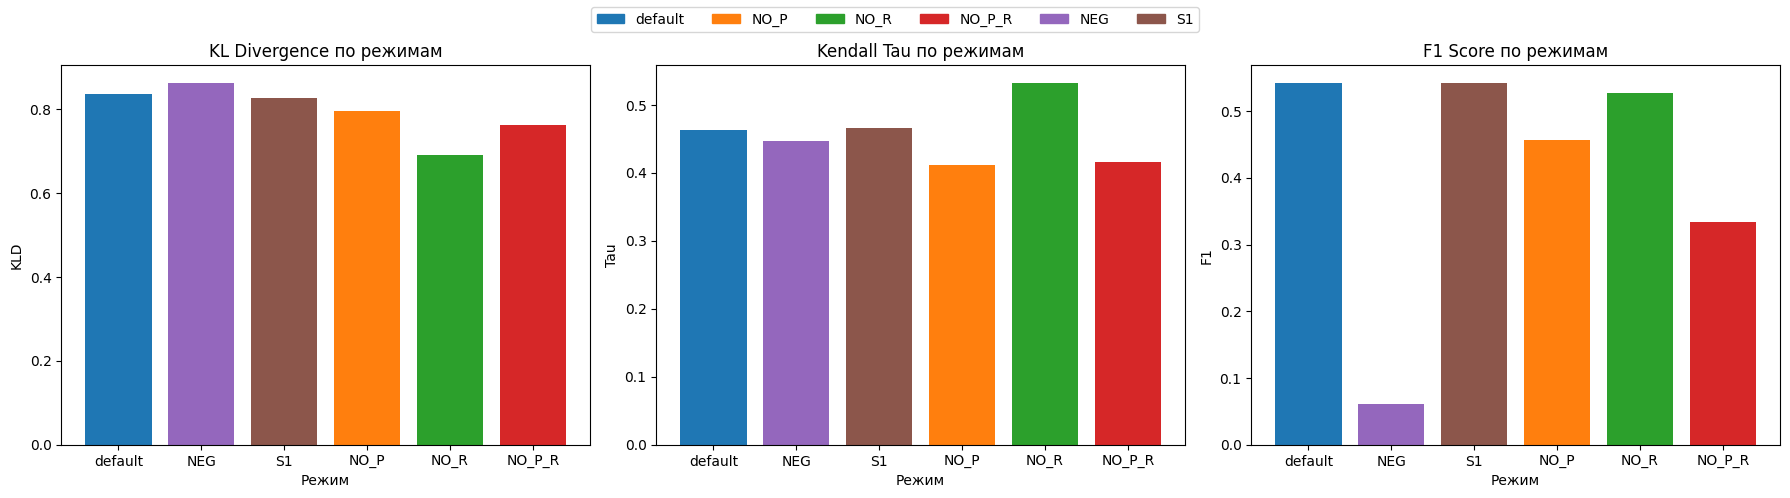

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_hists_abs(df_results, dataset):
    df_metrics = df_results[df_results['dataset'] == dataset]

    color_map = {
        'default': '#1f77b4',
        'NO_P': '#ff7f0e',
        'NO_R': '#2ca02c',
        'NO_P_R': '#d62728',
        'NEG': '#9467bd',
        'S1': '#8c564b'
    }

    modes = df_metrics['mode'].tolist()
    colors = [color_map[mode] for mode in modes]

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # KLD
    ax[0].bar(modes, df_metrics['kld'], color=colors)
    ax[0].set_title("KL Divergence по режимам")
    ax[0].set_ylabel("KLD")
    ax[0].set_xlabel("Режим")

    # Tau
    ax[1].bar(modes, df_metrics['tau'], color=colors)
    ax[1].set_title("Kendall Tau по режимам")
    ax[1].set_ylabel("Tau")
    ax[1].set_xlabel("Режим")

    # F1
    ax[2].bar(modes, df_metrics['f1'], color=colors)
    ax[2].set_title("F1 Score по режимам")
    ax[2].set_ylabel("F1")
    ax[2].set_xlabel("Режим")

    # Общая легенда
    handles = [plt.Rectangle((0,0),1,1, color=color_map[m]) for m in color_map]
    labels = list(color_map.keys())
    fig.legend(handles, labels, loc='upper center', ncol=6)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_hists_abs(df_results, 'CP')

## Поверх PropCare обучаем DLCE для анализа казуальных метрик

После получения результатов PropCare с различными режимами абляции мы переходим ко второму этапу эксперимента — 
оценке качества казуального восстановления экспозиций с использованием модели **DLCE**.

Идея заключается в следующем:

1. На первом этапе PropCare предсказывает **propensity** и **relevance** под различными конфигурациями абляции.  
2. На втором этапе мы фиксируем эти предсказания и подаём их в DLCE в качестве входных признаков.  
3. DLCE обучается оценивать причинно-ориентированные сигналы, такие как:
   - вероятность показа при различных интервенциях,
   - индивидуальный казуальный эффект (ITE),
   - uplift,
   - отклик с учётом скрытых факторов.
4. Это позволяет понять, как каждый из модулей PropCare влияет на способность модели 
   корректно восстанавливать **каузальные метрики**, а не только классические (F1, Tau, KLD).

Таким образом, DLCE выступает как «второй уровень» над PropCare,  
оценяя глубину и качество причинных зависимостей, которые модель смогла выучить в процессе обучения под разными абляциями.


In [ ]:
casual_metrics_results = []

for dataset in ['CP']:        
    for mode in ["default", "NEG", "S1", "NO_P", "NO_R", "NO_P_R"]:
        train_df, vali_df, test_df, num_users, num_items, _ = get_dataset(dataset, "./")
        propcare = PropCare.load_model(dir_path=f"saved_models/propcare/ablation", model_name=f"model_{dataset}_{mode}", device='cuda')

        train_df['propensity'] = propcare.predict(train_df)
        vali_df['propensity'] = propcare.predict(vali_df)
        test_df['propensity'] = propcare.predict(test_df)

        train_df['treated'] = propcare.predict_z(train_df)
        vali_df['treated'] = propcare.predict_z(vali_df)
        test_df['treated'] = propcare.predict_z(test_df)

        df = pd.read_csv(f"results/dlce_optuna_{dataset}.csv")
        best_params = df.iloc[[df['CPrec_10'].idxmax()]].squeeze().to_dict()

        dlce = DLCE(
            num_users=num_users,
            num_items=num_items,
            dim_factor=int(best_params['dim_factor']),
            metric=best_params['metric'],
            learn_rate=best_params['learn_rate'],
            reg_factor=best_params['reg_factor'],
            reg_bias=best_params['reg_bias'],
            omega=best_params['omega'],
            xT=best_params['xT'],
            xC=best_params['xC'],
            tau_mode=best_params['tau_mode'],
            with_bias=bool(best_params['with_bias']),
            with_outcome=bool(best_params['with_outcome']),
            only_treated=bool(best_params['only_treated']),
            device='cuda',
            seed = 42
        )

        # Обучаем модель
        dlce.fit(train_df, vali_df, n_epochs=40, batch_size=512)
        model_name = f'DLCE_PropCare_{mode}'
        all_datasets[dataset]['test'][f"{model_name}_pred"] = dlce.predict(all_datasets[dataset]['test'])

        dlce.save_model(dir_path=f"saved_models/dlce/propcare_ablation", model_name=f"model_{mode}")
        value = evaluator.evaluate(all_datasets[dataset]['test'].rename(columns={f"{model_name}_pred": "pred"}), measures=dlce.measures)

        value['dataset'] = dataset
        value['mode'] = mode
        casual_metrics_results.append(value)

df_results = pd.DataFrame(casual_metrics_results)
df_results

DLCE:   2%|▉                                     | 1/40 [00:09<06:01,  9.26s/it]

Epoch 1/40, Train Loss: 4912.7947, Validation Metrics: {'CPrec_10': np.float64(0.020268514508445214), 'CPrec_100': np.float64(0.014265915980944132), 'CDCG_100': 0.31986437207514357, 'CDCG': 0.861793988236573}


DLCE:   5%|█▉                                    | 2/40 [00:17<05:32,  8.76s/it]

Epoch 2/40, Train Loss: 1899.0778, Validation Metrics: {'CPrec_10': np.float64(0.026418362927674317), 'CPrec_100': np.float64(0.019298397574707665), 'CDCG_100': 0.43193736519003184, 'CDCG': 0.9232683706096817}


DLCE:   8%|██▊                                   | 3/40 [00:25<05:11,  8.42s/it]

Epoch 3/40, Train Loss: 1376.9943, Validation Metrics: {'CPrec_10': np.float64(0.026548289302728453), 'CPrec_100': np.float64(0.020485058466868773), 'CDCG_100': 0.46612277587235923, 'CDCG': 0.9421000752761521}


DLCE:  10%|███▊                                  | 4/40 [00:33<05:00,  8.36s/it]

Epoch 4/40, Train Loss: 1268.7834, Validation Metrics: {'CPrec_10': np.float64(0.031831961888263316), 'CPrec_100': np.float64(0.02176699870073625), 'CDCG_100': 0.5040067172371561, 'CDCG': 0.963471875565355}


DLCE:  12%|████▊                                 | 5/40 [00:43<05:13,  8.95s/it]

Epoch 5/40, Train Loss: 1188.6758, Validation Metrics: {'CPrec_10': np.float64(0.04343871805976613), 'CPrec_100': np.float64(0.022776093546990037), 'CDCG_100': 0.5601844783493857, 'CDCG': 1.005781780266282}


DLCE:  15%|█████▋                                | 6/40 [00:51<04:53,  8.64s/it]

Epoch 6/40, Train Loss: 1133.7640, Validation Metrics: {'CPrec_10': np.float64(0.04534430489389346), 'CPrec_100': np.float64(0.02386314421827631), 'CDCG_100': 0.5968516751246662, 'CDCG': 1.027722248778577}


DLCE:  18%|██████▋                               | 7/40 [01:00<04:39,  8.46s/it]

Epoch 7/40, Train Loss: 1078.1975, Validation Metrics: {'CPrec_10': np.float64(0.05136422693806843), 'CPrec_100': np.float64(0.024733650931139023), 'CDCG_100': 0.6247022861684463, 'CDCG': 1.043022745223856}


DLCE:  20%|███████▌                              | 8/40 [01:08<04:29,  8.44s/it]

Epoch 8/40, Train Loss: 1037.0148, Validation Metrics: {'CPrec_10': np.float64(0.05643135556517973), 'CPrec_100': np.float64(0.025028150714595063), 'CDCG_100': 0.6559754469555918, 'CDCG': 1.06986388609634}


DLCE:  22%|████████▌                             | 9/40 [01:18<04:37,  8.94s/it]

Epoch 9/40, Train Loss: 987.4668, Validation Metrics: {'CPrec_10': np.float64(0.05807708964919879), 'CPrec_100': np.float64(0.0258943265482893), 'CDCG_100': 0.6668326475519023, 'CDCG': 1.0677198235951202}


DLCE:  25%|█████████▎                           | 10/40 [01:25<04:11,  8.40s/it]

Epoch 10/40, Train Loss: 960.3953, Validation Metrics: {'CPrec_10': np.float64(0.06002598527501083), 'CPrec_100': np.float64(0.025695106106539627), 'CDCG_100': 0.6826536155972363, 'CDCG': 1.0869194892962246}


DLCE:  28%|██████████▏                          | 11/40 [01:32<03:53,  8.05s/it]

Epoch 11/40, Train Loss: 934.6503, Validation Metrics: {'CPrec_10': np.float64(0.06582936336076224), 'CPrec_100': np.float64(0.026548289302728453), 'CDCG_100': 0.7127371255869194, 'CDCG': 1.1042058838426525}


DLCE:  30%|███████████                          | 12/40 [01:40<03:38,  7.79s/it]

Epoch 12/40, Train Loss: 910.5390, Validation Metrics: {'CPrec_10': np.float64(0.06513642269380684), 'CPrec_100': np.float64(0.026916414032048506), 'CDCG_100': 0.7301035914205272, 'CDCG': 1.1169790038107563}


DLCE:  32%|████████████                         | 13/40 [01:49<03:44,  8.33s/it]

Epoch 13/40, Train Loss: 885.4747, Validation Metrics: {'CPrec_10': np.float64(0.06951061065396276), 'CPrec_100': np.float64(0.027297531398873972), 'CDCG_100': 0.7472463763855971, 'CDCG': 1.1283705478601351}


DLCE:  35%|████████████▉                        | 14/40 [01:57<03:33,  8.22s/it]

Epoch 14/40, Train Loss: 872.1801, Validation Metrics: {'CPrec_10': np.float64(0.0721957557384149), 'CPrec_100': np.float64(0.02700303161541793), 'CDCG_100': 0.7539384042492715, 'CDCG': 1.1396658146955316}


DLCE:  38%|█████████████▉                       | 15/40 [02:05<03:23,  8.16s/it]

Epoch 15/40, Train Loss: 865.1995, Validation Metrics: {'CPrec_10': np.float64(0.07249891728020788), 'CPrec_100': np.float64(0.027423126894759637), 'CDCG_100': 0.7568030144838488, 'CDCG': 1.1357424950477146}


DLCE:  40%|██████████████▊                      | 16/40 [02:13<03:13,  8.06s/it]

Epoch 16/40, Train Loss: 845.3392, Validation Metrics: {'CPrec_10': np.float64(0.0732784755305327), 'CPrec_100': np.float64(0.027531398873971415), 'CDCG_100': 0.7548584283534442, 'CDCG': 1.132321018227153}


DLCE:  42%|███████████████▋                     | 17/40 [02:20<03:00,  7.86s/it]

Epoch 17/40, Train Loss: 837.6588, Validation Metrics: {'CPrec_10': np.float64(0.06938068427890862), 'CPrec_100': np.float64(0.027739281074058035), 'CDCG_100': 0.7537482900434072, 'CDCG': 1.1280997175948815}


DLCE:  45%|████████████████▋                    | 18/40 [02:30<03:02,  8.28s/it]

Epoch 18/40, Train Loss: 822.7977, Validation Metrics: {'CPrec_10': np.float64(0.06942399307059333), 'CPrec_100': np.float64(0.028297964486790818), 'CDCG_100': 0.7612074592806166, 'CDCG': 1.1278752070568892}


DLCE:  48%|█████████████████▌                   | 19/40 [02:37<02:46,  7.94s/it]

Epoch 19/40, Train Loss: 816.6727, Validation Metrics: {'CPrec_10': np.float64(0.07080987440450412), 'CPrec_100': np.float64(0.028142052836725856), 'CDCG_100': 0.7759219767080671, 'CDCG': 1.1445475011872936}


DLCE:  50%|██████████████████▌                  | 20/40 [02:44<02:33,  7.69s/it]

Epoch 20/40, Train Loss: 803.7284, Validation Metrics: {'CPrec_10': np.float64(0.07093980077955825), 'CPrec_100': np.float64(0.028531831961888264), 'CDCG_100': 0.7735041584123148, 'CDCG': 1.1367812866529565}


DLCE:  52%|███████████████████▍                 | 21/40 [02:51<02:24,  7.61s/it]

Epoch 21/40, Train Loss: 804.5998, Validation Metrics: {'CPrec_10': np.float64(0.07007362494586401), 'CPrec_100': np.float64(0.028284971849285405), 'CDCG_100': 0.761430353226942, 'CDCG': 1.1278366447878543}


DLCE:  55%|████████████████████▎                | 22/40 [03:01<02:27,  8.20s/it]

Epoch 22/40, Train Loss: 792.4320, Validation Metrics: {'CPrec_10': np.float64(0.0700303161541793), 'CPrec_100': np.float64(0.028847986141186662), 'CDCG_100': 0.7700904259703156, 'CDCG': 1.1283869568261555}


DLCE:  57%|█████████████████████▎               | 23/40 [03:08<02:14,  7.92s/it]

Epoch 23/40, Train Loss: 786.3564, Validation Metrics: {'CPrec_10': np.float64(0.07241229969683846), 'CPrec_100': np.float64(0.028969250757903856), 'CDCG_100': 0.7832895609932403, 'CDCG': 1.1401503985558594}


DLCE:  60%|██████████████████████▏              | 24/40 [03:15<02:03,  7.70s/it]

Epoch 24/40, Train Loss: 786.8812, Validation Metrics: {'CPrec_10': np.float64(0.07102641836292767), 'CPrec_100': np.float64(0.02921177999133824), 'CDCG_100': 0.7857972709222091, 'CDCG': 1.1391030630702856}


DLCE:  62%|███████████████████████▏             | 25/40 [03:23<01:53,  7.59s/it]

Epoch 25/40, Train Loss: 778.8486, Validation Metrics: {'CPrec_10': np.float64(0.07046340407102641), 'CPrec_100': np.float64(0.029090515374621047), 'CDCG_100': 0.7818801697183955, 'CDCG': 1.1370097538528374}


DLCE:  65%|████████████████████████             | 26/40 [03:32<01:53,  8.13s/it]

Epoch 26/40, Train Loss: 778.8214, Validation Metrics: {'CPrec_10': np.float64(0.07202252057167605), 'CPrec_100': np.float64(0.029198787353832828), 'CDCG_100': 0.7871725861370278, 'CDCG': 1.1403133432436183}


DLCE:  68%|████████████████████████▉            | 27/40 [03:39<01:41,  7.83s/it]

Epoch 27/40, Train Loss: 763.3728, Validation Metrics: {'CPrec_10': np.float64(0.07184928540493721), 'CPrec_100': np.float64(0.02928107405803378), 'CDCG_100': 0.7858144691190342, 'CDCG': 1.1377287599601513}


DLCE:  70%|█████████████████████████▉           | 28/40 [03:46<01:31,  7.60s/it]

Epoch 28/40, Train Loss: 765.2429, Validation Metrics: {'CPrec_10': np.float64(0.07115634473798181), 'CPrec_100': np.float64(0.029449978345604158), 'CDCG_100': 0.7815732513576403, 'CDCG': 1.1308194007035928}


DLCE:  72%|██████████████████████████▊          | 29/40 [03:54<01:25,  7.76s/it]

Epoch 29/40, Train Loss: 763.9993, Validation Metrics: {'CPrec_10': np.float64(0.07154612386314421), 'CPrec_100': np.float64(0.029432654828930274), 'CDCG_100': 0.7781632738387341, 'CDCG': 1.1275976624628246}


DLCE:  75%|███████████████████████████▊         | 30/40 [04:03<01:18,  7.87s/it]

Epoch 30/40, Train Loss: 759.9771, Validation Metrics: {'CPrec_10': np.float64(0.06851450844521438), 'CPrec_100': np.float64(0.029415331312256387), 'CDCG_100': 0.7732216684630255, 'CDCG': 1.123740553773926}


DLCE:  78%|████████████████████████████▋        | 31/40 [04:12<01:16,  8.49s/it]

Epoch 31/40, Train Loss: 752.7882, Validation Metrics: {'CPrec_10': np.float64(0.06847119965352967), 'CPrec_100': np.float64(0.029514941533131226), 'CDCG_100': 0.7619845620431223, 'CDCG': 1.111286248438904}


DLCE:  80%|█████████████████████████████▌       | 32/40 [04:20<01:04,  8.09s/it]

Epoch 32/40, Train Loss: 748.9829, Validation Metrics: {'CPrec_10': np.float64(0.06414032048505847), 'CPrec_100': np.float64(0.029428323949761803), 'CDCG_100': 0.7685577776950963, 'CDCG': 1.119211090237671}


DLCE:  82%|██████████████████████████████▌      | 33/40 [04:27<00:55,  7.88s/it]

Epoch 33/40, Train Loss: 753.2302, Validation Metrics: {'CPrec_10': np.float64(0.06721524469467302), 'CPrec_100': np.float64(0.029774794283239498), 'CDCG_100': 0.7801010792063066, 'CDCG': 1.1253580292767815}


DLCE:  85%|███████████████████████████████▍     | 34/40 [04:34<00:46,  7.68s/it]

Epoch 34/40, Train Loss: 741.6727, Validation Metrics: {'CPrec_10': np.float64(0.07197921177999134), 'CPrec_100': np.float64(0.029415331312256387), 'CDCG_100': 0.7839535089080119, 'CDCG': 1.1342921007748528}


DLCE:  88%|████████████████████████████████▍    | 35/40 [04:44<00:40,  8.15s/it]

Epoch 35/40, Train Loss: 737.9808, Validation Metrics: {'CPrec_10': np.float64(0.06907752273711563), 'CPrec_100': np.float64(0.029701169337375488), 'CDCG_100': 0.7903423552358875, 'CDCG': 1.1363606101155903}


DLCE:  90%|█████████████████████████████████▎   | 36/40 [04:51<00:31,  7.88s/it]

Epoch 36/40, Train Loss: 739.6518, Validation Metrics: {'CPrec_10': np.float64(0.07020355132091814), 'CPrec_100': np.float64(0.029848419229103508), 'CDCG_100': 0.7871481487813209, 'CDCG': 1.1311625580249236}


DLCE:  92%|██████████████████████████████████▏  | 37/40 [04:58<00:23,  7.74s/it]

Epoch 37/40, Train Loss: 744.1515, Validation Metrics: {'CPrec_10': np.float64(0.07249891728020788), 'CPrec_100': np.float64(0.030056301429190125), 'CDCG_100': 0.7976155171865777, 'CDCG': 1.1386396220734571}


DLCE:  95%|███████████████████████████████████▏ | 38/40 [05:06<00:15,  7.65s/it]

Epoch 38/40, Train Loss: 740.3030, Validation Metrics: {'CPrec_10': np.float64(0.06985708098744045), 'CPrec_100': np.float64(0.02978345604157644), 'CDCG_100': 0.7885606464678482, 'CDCG': 1.134116840742864}


DLCE:  98%|████████████████████████████████████ | 39/40 [05:15<00:08,  8.17s/it]

Epoch 39/40, Train Loss: 737.5223, Validation Metrics: {'CPrec_10': np.float64(0.07202252057167605), 'CPrec_100': np.float64(0.03032481593763534), 'CDCG_100': 0.8050441262741515, 'CDCG': 1.1426458853459138}


Epoch 40/40, Train Loss: 736.7659, Validation Metrics: {'CPrec_10': np.float64(0.07046340407102641), 'CPrec_100': np.float64(0.030298830662624513), 'CDCG_100': 0.7992221427527537, 'CDCG': 1.1376276600514974}


Model saved to: saved_models/dlce/propcare_ablation/model_default


DLCE:   2%|▉                                     | 1/40 [00:09<06:04,  9.34s/it]

Epoch 1/40, Train Loss: 2098.2439, Validation Metrics: {'CPrec_10': np.float64(0.010047639670853183), 'CPrec_100': np.float64(0.005240363793850152), 'CDCG_100': 0.12952107096440882, 'CDCG': 0.7354269719537867}


DLCE:   5%|█▉                                    | 2/40 [00:17<05:27,  8.61s/it]

Epoch 2/40, Train Loss: 1246.5847, Validation Metrics: {'CPrec_10': np.float64(0.018536162841056733), 'CPrec_100': np.float64(0.00646167171935903), 'CDCG_100': 0.1986928422107035, 'CDCG': 0.7844313504718903}


DLCE:   8%|██▊                                   | 3/40 [00:25<05:15,  8.52s/it]

Epoch 3/40, Train Loss: 881.7762, Validation Metrics: {'CPrec_10': np.float64(0.029190125595495886), 'CPrec_100': np.float64(0.007280207882200087), 'CDCG_100': 0.25245536191610857, 'CDCG': 0.8196362969887341}


DLCE:  10%|███▊                                  | 4/40 [00:33<05:00,  8.34s/it]

Epoch 4/40, Train Loss: 674.2565, Validation Metrics: {'CPrec_10': np.float64(0.034820268514508444), 'CPrec_100': np.float64(0.007656994369857081), 'CDCG_100': 0.2843909146879443, 'CDCG': 0.8400661423818994}


DLCE:  12%|████▊                                 | 5/40 [00:44<05:14,  8.98s/it]

Epoch 5/40, Train Loss: 545.7653, Validation Metrics: {'CPrec_10': np.float64(0.03910783889129493), 'CPrec_100': np.float64(0.007890861844954526), 'CDCG_100': 0.3011073153486459, 'CDCG': 0.8493120085056888}


DLCE:  15%|█████▋                                | 6/40 [00:51<04:50,  8.55s/it]

Epoch 6/40, Train Loss: 470.8927, Validation Metrics: {'CPrec_10': np.float64(0.04157644001732352), 'CPrec_100': np.float64(0.008077089649198788), 'CDCG_100': 0.31407107630722425, 'CDCG': 0.8574512905919248}


DLCE:  18%|██████▋                               | 7/40 [01:00<04:39,  8.46s/it]

Epoch 7/40, Train Loss: 421.6766, Validation Metrics: {'CPrec_10': np.float64(0.04465136422693807), 'CPrec_100': np.float64(0.008284971849285405), 'CDCG_100': 0.32637528224945367, 'CDCG': 0.8654898733141594}


DLCE:  20%|███████▌                              | 8/40 [01:07<04:21,  8.16s/it]

Epoch 8/40, Train Loss: 391.3984, Validation Metrics: {'CPrec_10': np.float64(0.04841922910350801), 'CPrec_100': np.float64(0.008284971849285405), 'CDCG_100': 0.3341387173193959, 'CDCG': 0.8725389846136988}


DLCE:  22%|████████▌                             | 9/40 [01:16<04:22,  8.46s/it]

Epoch 9/40, Train Loss: 363.1222, Validation Metrics: {'CPrec_10': np.float64(0.04963187527067995), 'CPrec_100': np.float64(0.008614118666089216), 'CDCG_100': 0.34268729298845096, 'CDCG': 0.8758005346038799}


DLCE:  25%|█████████▎                           | 10/40 [01:24<04:05,  8.19s/it]

Epoch 10/40, Train Loss: 347.3758, Validation Metrics: {'CPrec_10': np.float64(0.049155478562148115), 'CPrec_100': np.float64(0.008601126028583803), 'CDCG_100': 0.3443241105128168, 'CDCG': 0.8766300716802099}


DLCE:  28%|██████████▏                          | 11/40 [01:31<03:51,  7.98s/it]

Epoch 11/40, Train Loss: 334.0916, Validation Metrics: {'CPrec_10': np.float64(0.05032481593763534), 'CPrec_100': np.float64(0.008687743611953227), 'CDCG_100': 0.3445701150937632, 'CDCG': 0.8752347171522475}


DLCE:  30%|███████████                          | 12/40 [01:39<03:39,  7.84s/it]

Epoch 12/40, Train Loss: 321.7316, Validation Metrics: {'CPrec_10': np.float64(0.05257687310524036), 'CPrec_100': np.float64(0.008800346470333478), 'CDCG_100': 0.3448069422870896, 'CDCG': 0.8739464328747484}


DLCE:  32%|████████████                         | 13/40 [01:47<03:31,  7.84s/it]

Epoch 13/40, Train Loss: 309.4193, Validation Metrics: {'CPrec_10': np.float64(0.051710697271546126), 'CPrec_100': np.float64(0.008683412732784754), 'CDCG_100': 0.3456343568481996, 'CDCG': 0.8761096339361211}


DLCE:  35%|████████████▉                        | 14/40 [01:56<03:36,  8.33s/it]

Epoch 14/40, Train Loss: 305.7582, Validation Metrics: {'CPrec_10': np.float64(0.05266349068860979), 'CPrec_100': np.float64(0.008653096578605458), 'CDCG_100': 0.3436600509431871, 'CDCG': 0.8742216030796093}


DLCE:  38%|█████████████▉                       | 15/40 [02:04<03:21,  8.07s/it]

Epoch 15/40, Train Loss: 296.9657, Validation Metrics: {'CPrec_10': np.float64(0.0537895192724123), 'CPrec_100': np.float64(0.008653096578605458), 'CDCG_100': 0.3449567322665348, 'CDCG': 0.8751416453844133}


DLCE:  40%|██████████████▊                      | 16/40 [02:11<03:07,  7.83s/it]

Epoch 16/40, Train Loss: 289.5785, Validation Metrics: {'CPrec_10': np.float64(0.05387613685578172), 'CPrec_100': np.float64(0.008696405370290169), 'CDCG_100': 0.3424259052697394, 'CDCG': 0.8718536227438171}


DLCE:  42%|███████████████▋                     | 17/40 [02:18<02:58,  7.78s/it]

Epoch 17/40, Train Loss: 290.6916, Validation Metrics: {'CPrec_10': np.float64(0.052793417063663924), 'CPrec_100': np.float64(0.008657427457773929), 'CDCG_100': 0.3364941059692739, 'CDCG': 0.8664632550018883}


DLCE:  45%|████████████████▋                    | 18/40 [02:27<02:59,  8.15s/it]

Epoch 18/40, Train Loss: 284.1960, Validation Metrics: {'CPrec_10': np.float64(0.05326981377219576), 'CPrec_100': np.float64(0.008748375920311822), 'CDCG_100': 0.34132630109790607, 'CDCG': 0.8699324960859529}


DLCE:  48%|█████████████████▌                   | 19/40 [02:35<02:47,  7.99s/it]

Epoch 19/40, Train Loss: 279.7993, Validation Metrics: {'CPrec_10': np.float64(0.05391944564746644), 'CPrec_100': np.float64(0.008670420095279342), 'CDCG_100': 0.34272891025073887, 'CDCG': 0.8722324758734545}


DLCE:  50%|██████████████████▌                  | 20/40 [02:43<02:37,  7.89s/it]

Epoch 20/40, Train Loss: 274.9127, Validation Metrics: {'CPrec_10': np.float64(0.055435253356431353), 'CPrec_100': np.float64(0.008514508445214378), 'CDCG_100': 0.34213057148496123, 'CDCG': 0.8736843327740974}


DLCE:  52%|███████████████████▍                 | 21/40 [02:50<02:28,  7.82s/it]

Epoch 21/40, Train Loss: 274.9045, Validation Metrics: {'CPrec_10': np.float64(0.05391944564746644), 'CPrec_100': np.float64(0.008596795149415332), 'CDCG_100': 0.34655353850742804, 'CDCG': 0.8772247727052682}


DLCE:  55%|████████████████████▎                | 22/40 [03:00<02:29,  8.28s/it]

Epoch 22/40, Train Loss: 274.6077, Validation Metrics: {'CPrec_10': np.float64(0.055608488523170206), 'CPrec_100': np.float64(0.008605456907752274), 'CDCG_100': 0.3500619126906113, 'CDCG': 0.8805275741758027}


DLCE:  57%|█████████████████████▎               | 23/40 [03:07<02:15,  7.98s/it]

Epoch 23/40, Train Loss: 269.5459, Validation Metrics: {'CPrec_10': np.float64(0.055998267648332614), 'CPrec_100': np.float64(0.008570809874404504), 'CDCG_100': 0.3496446040099773, 'CDCG': 0.8810591975902968}


DLCE:  60%|██████████████████████▏              | 24/40 [03:14<02:04,  7.80s/it]

Epoch 24/40, Train Loss: 269.8352, Validation Metrics: {'CPrec_10': np.float64(0.05651797314854916), 'CPrec_100': np.float64(0.00858813339107839), 'CDCG_100': 0.35233417607131867, 'CDCG': 0.8825794128822002}


DLCE:  62%|███████████████████████▏             | 25/40 [03:22<01:55,  7.71s/it]

Epoch 25/40, Train Loss: 267.6635, Validation Metrics: {'CPrec_10': np.float64(0.055695106106539626), 'CPrec_100': np.float64(0.008713728886964053), 'CDCG_100': 0.35431834071395607, 'CDCG': 0.8830616527547235}


DLCE:  65%|████████████████████████             | 26/40 [03:31<01:54,  8.16s/it]

Epoch 26/40, Train Loss: 265.0667, Validation Metrics: {'CPrec_10': np.float64(0.056041576440017324), 'CPrec_100': np.float64(0.008687743611953227), 'CDCG_100': 0.3563792931751534, 'CDCG': 0.8852696349132947}


DLCE:  68%|████████████████████████▉            | 27/40 [03:39<01:45,  8.15s/it]

Epoch 27/40, Train Loss: 265.8658, Validation Metrics: {'CPrec_10': np.float64(0.05656128194023387), 'CPrec_100': np.float64(0.008744045041143352), 'CDCG_100': 0.35498955372200847, 'CDCG': 0.8830165014004763}


DLCE:  70%|█████████████████████████▉           | 28/40 [03:48<01:38,  8.20s/it]

Epoch 28/40, Train Loss: 264.1138, Validation Metrics: {'CPrec_10': np.float64(0.057644001732351666), 'CPrec_100': np.float64(0.008618449545257686), 'CDCG_100': 0.356386288873059, 'CDCG': 0.8860738446855014}


DLCE:  72%|██████████████████████████▊          | 29/40 [03:56<01:30,  8.24s/it]

Epoch 29/40, Train Loss: 264.9680, Validation Metrics: {'CPrec_10': np.float64(0.05586834127327848), 'CPrec_100': np.float64(0.008540493720225206), 'CDCG_100': 0.35630496688991786, 'CDCG': 0.8872933483555022}


DLCE:  75%|███████████████████████████▊         | 30/40 [04:05<01:26,  8.63s/it]

Epoch 30/40, Train Loss: 262.9170, Validation Metrics: {'CPrec_10': np.float64(0.05651797314854916), 'CPrec_100': np.float64(0.008653096578605458), 'CDCG_100': 0.35684209187223276, 'CDCG': 0.8866591512088259}


DLCE:  78%|████████████████████████████▋        | 31/40 [04:13<01:14,  8.28s/it]

Epoch 31/40, Train Loss: 263.2294, Validation Metrics: {'CPrec_10': np.float64(0.05617150281507146), 'CPrec_100': np.float64(0.008579471632741446), 'CDCG_100': 0.346940104388159, 'CDCG': 0.87714614288622}


DLCE:  80%|█████████████████████████████▌       | 32/40 [04:21<01:04,  8.08s/it]

Epoch 32/40, Train Loss: 259.2884, Validation Metrics: {'CPrec_10': np.float64(0.055391944564746644), 'CPrec_100': np.float64(0.008609787786920745), 'CDCG_100': 0.3443303294082686, 'CDCG': 0.8742581580590113}


DLCE:  82%|██████████████████████████████▌      | 33/40 [04:28<00:55,  7.88s/it]

Epoch 33/40, Train Loss: 259.4369, Validation Metrics: {'CPrec_10': np.float64(0.05582503248159376), 'CPrec_100': np.float64(0.008817669987007363), 'CDCG_100': 0.3522354337606699, 'CDCG': 0.8792584096518182}


DLCE:  85%|███████████████████████████████▍     | 34/40 [04:35<00:46,  7.73s/it]

Epoch 34/40, Train Loss: 257.9812, Validation Metrics: {'CPrec_10': np.float64(0.05578172368990905), 'CPrec_100': np.float64(0.008709398007795582), 'CDCG_100': 0.3485373419448224, 'CDCG': 0.8766225880185541}


DLCE:  88%|████████████████████████████████▍    | 35/40 [04:45<00:40,  8.19s/it]

Epoch 35/40, Train Loss: 259.3184, Validation Metrics: {'CPrec_10': np.float64(0.055435253356431353), 'CPrec_100': np.float64(0.00858813339107839), 'CDCG_100': 0.34626377478149145, 'CDCG': 0.8763587433708293}


DLCE:  90%|█████████████████████████████████▎   | 36/40 [04:52<00:31,  7.95s/it]

Epoch 36/40, Train Loss: 255.8045, Validation Metrics: {'CPrec_10': np.float64(0.054742312689475964), 'CPrec_100': np.float64(0.008583802511909917), 'CDCG_100': 0.3454742223905495, 'CDCG': 0.8758167038180812}


DLCE:  92%|██████████████████████████████████▏  | 37/40 [04:59<00:23,  7.80s/it]

Epoch 37/40, Train Loss: 256.9907, Validation Metrics: {'CPrec_10': np.float64(0.055695106106539626), 'CPrec_100': np.float64(0.008748375920311822), 'CDCG_100': 0.3523230802273855, 'CDCG': 0.8809731777491888}


DLCE:  95%|███████████████████████████████████▏ | 38/40 [05:07<00:15,  7.65s/it]

Epoch 38/40, Train Loss: 254.1287, Validation Metrics: {'CPrec_10': np.float64(0.055608488523170206), 'CPrec_100': np.float64(0.008618449545257686), 'CDCG_100': 0.3446718327472517, 'CDCG': 0.8743592633587928}


DLCE:  98%|████████████████████████████████████ | 39/40 [05:16<00:08,  8.15s/it]

Epoch 39/40, Train Loss: 255.4602, Validation Metrics: {'CPrec_10': np.float64(0.056344737981810306), 'CPrec_100': np.float64(0.008640103941100043), 'CDCG_100': 0.34960703484382427, 'CDCG': 0.879358635981765}


Epoch 40/40, Train Loss: 256.8667, Validation Metrics: {'CPrec_10': np.float64(0.05677782589865743), 'CPrec_100': np.float64(0.0086617583369424), 'CDCG_100': 0.3447531996721496, 'CDCG': 0.8739730123184063}


Model saved to: saved_models/dlce/propcare_ablation/model_NEG


DLCE:   2%|▉                                     | 1/40 [00:09<06:06,  9.39s/it]

Epoch 1/40, Train Loss: 4914.0576, Validation Metrics: {'CPrec_10': np.float64(0.021134690342139453), 'CPrec_100': np.float64(0.014595062797747943), 'CDCG_100': 0.3287667249176281, 'CDCG': 0.8672946799953972}


DLCE:   5%|█▉                                    | 2/40 [00:17<05:30,  8.70s/it]

Epoch 2/40, Train Loss: 1888.9923, Validation Metrics: {'CPrec_10': np.float64(0.025119099177132957), 'CPrec_100': np.float64(0.019757470766565612), 'CDCG_100': 0.4412961421716607, 'CDCG': 0.9264384586496861}


DLCE:   8%|██▊                                   | 3/40 [00:26<05:19,  8.62s/it]

Epoch 3/40, Train Loss: 1378.7450, Validation Metrics: {'CPrec_10': np.float64(0.027024686011260287), 'CPrec_100': np.float64(0.02068860978778692), 'CDCG_100': 0.46923581758685406, 'CDCG': 0.9429461977490894}


DLCE:  10%|███▊                                  | 4/40 [00:34<05:06,  8.53s/it]

Epoch 4/40, Train Loss: 1269.9972, Validation Metrics: {'CPrec_10': np.float64(0.031182330012992636), 'CPrec_100': np.float64(0.022230402771762667), 'CDCG_100': 0.5150920561691441, 'CDCG': 0.9683912620064311}


DLCE:  12%|████▊                                 | 5/40 [00:44<05:19,  9.14s/it]

Epoch 5/40, Train Loss: 1192.4073, Validation Metrics: {'CPrec_10': np.float64(0.04495452576873105), 'CPrec_100': np.float64(0.02303594629709831), 'CDCG_100': 0.5713855425679978, 'CDCG': 1.0138102455644273}


DLCE:  15%|█████▋                                | 6/40 [00:52<04:53,  8.62s/it]

Epoch 6/40, Train Loss: 1137.0061, Validation Metrics: {'CPrec_10': np.float64(0.049761801645734086), 'CPrec_100': np.float64(0.02394110004330879), 'CDCG_100': 0.6060928898133136, 'CDCG': 1.036399304817396}


DLCE:  18%|██████▋                               | 7/40 [00:59<04:30,  8.21s/it]

Epoch 7/40, Train Loss: 1081.3758, Validation Metrics: {'CPrec_10': np.float64(0.0516240796881767), 'CPrec_100': np.float64(0.025071459506279776), 'CDCG_100': 0.6365389358605948, 'CDCG': 1.0505165505645941}


DLCE:  20%|███████▌                              | 8/40 [01:07<04:13,  7.94s/it]

Epoch 8/40, Train Loss: 1039.5835, Validation Metrics: {'CPrec_10': np.float64(0.056344737981810306), 'CPrec_100': np.float64(0.025283672585534864), 'CDCG_100': 0.667533926093668, 'CDCG': 1.0783606144252846}


DLCE:  22%|████████▌                             | 9/40 [01:16<04:20,  8.40s/it]

Epoch 9/40, Train Loss: 987.3315, Validation Metrics: {'CPrec_10': np.float64(0.058640103941100044), 'CPrec_100': np.float64(0.025872672152446947), 'CDCG_100': 0.6739564458985389, 'CDCG': 1.0756851800320852}


DLCE:  25%|█████████▎                           | 10/40 [01:24<04:05,  8.18s/it]

Epoch 10/40, Train Loss: 963.1262, Validation Metrics: {'CPrec_10': np.float64(0.061498484192291036), 'CPrec_100': np.float64(0.026193157210913816), 'CDCG_100': 0.6948553510710231, 'CDCG': 1.0923033463924485}


DLCE:  28%|██████████▏                          | 11/40 [01:31<03:51,  7.99s/it]

Epoch 11/40, Train Loss: 937.5086, Validation Metrics: {'CPrec_10': np.float64(0.06539627544391512), 'CPrec_100': np.float64(0.026574274577739282), 'CDCG_100': 0.723631751888006, 'CDCG': 1.1148984622889744}


DLCE:  30%|███████████                          | 12/40 [01:39<03:41,  7.89s/it]

Epoch 12/40, Train Loss: 914.2759, Validation Metrics: {'CPrec_10': np.float64(0.06812472932005197), 'CPrec_100': np.float64(0.027020355132091816), 'CDCG_100': 0.7403270951658207, 'CDCG': 1.1260126768100707}


DLCE:  32%|████████████                         | 13/40 [01:47<03:32,  7.88s/it]

Epoch 13/40, Train Loss: 890.3858, Validation Metrics: {'CPrec_10': np.float64(0.07119965352966652), 'CPrec_100': np.float64(0.027345171069727156), 'CDCG_100': 0.7518511482554677, 'CDCG': 1.1323038774094996}


DLCE:  35%|████████████▉                        | 14/40 [01:56<03:36,  8.33s/it]

Epoch 14/40, Train Loss: 873.9641, Validation Metrics: {'CPrec_10': np.float64(0.07284538761368557), 'CPrec_100': np.float64(0.027483759203118234), 'CDCG_100': 0.7642363949855504, 'CDCG': 1.14273715356986}


DLCE:  38%|█████████████▉                       | 15/40 [02:03<03:20,  8.03s/it]

Epoch 15/40, Train Loss: 867.5508, Validation Metrics: {'CPrec_10': np.float64(0.07210913815504548), 'CPrec_100': np.float64(0.027553053269813773), 'CDCG_100': 0.7624067457602025, 'CDCG': 1.1396344737328703}


DLCE:  40%|██████████████▊                      | 16/40 [02:11<03:09,  7.89s/it]

Epoch 16/40, Train Loss: 850.2933, Validation Metrics: {'CPrec_10': np.float64(0.07128627111303594), 'CPrec_100': np.float64(0.028025119099177133), 'CDCG_100': 0.769083204700929, 'CDCG': 1.1395735602650117}


DLCE:  42%|███████████████▋                     | 17/40 [02:18<02:58,  7.75s/it]

Epoch 17/40, Train Loss: 840.9469, Validation Metrics: {'CPrec_10': np.float64(0.07245560848852317), 'CPrec_100': np.float64(0.02825898657427458), 'CDCG_100': 0.7706980630203488, 'CDCG': 1.1378268379446739}


DLCE:  45%|████████████████▋                    | 18/40 [02:28<03:00,  8.22s/it]

Epoch 18/40, Train Loss: 824.9375, Validation Metrics: {'CPrec_10': np.float64(0.07115634473798181), 'CPrec_100': np.float64(0.028466868774361196), 'CDCG_100': 0.7706165114174638, 'CDCG': 1.13501274269677}


DLCE:  48%|█████████████████▌                   | 19/40 [02:35<02:49,  8.07s/it]

Epoch 19/40, Train Loss: 822.0377, Validation Metrics: {'CPrec_10': np.float64(0.07085318319618883), 'CPrec_100': np.float64(0.02819402338674751), 'CDCG_100': 0.7823291779100685, 'CDCG': 1.1503938690507807}


DLCE:  50%|██████████████████▌                  | 20/40 [02:43<02:39,  8.00s/it]

Epoch 20/40, Train Loss: 809.0720, Validation Metrics: {'CPrec_10': np.float64(0.07119965352966652), 'CPrec_100': np.float64(0.028683412732784755), 'CDCG_100': 0.7791938502635807, 'CDCG': 1.1400657416187843}


DLCE:  52%|███████████████████▍                 | 21/40 [02:51<02:28,  7.84s/it]

Epoch 21/40, Train Loss: 809.8493, Validation Metrics: {'CPrec_10': np.float64(0.07119965352966652), 'CPrec_100': np.float64(0.02855348635773062), 'CDCG_100': 0.7671843101184377, 'CDCG': 1.1298185392436952}


DLCE:  55%|████████████████████▎                | 22/40 [03:00<02:28,  8.27s/it]

Epoch 22/40, Train Loss: 794.9693, Validation Metrics: {'CPrec_10': np.float64(0.07171935902988306), 'CPrec_100': np.float64(0.029268081420528367), 'CDCG_100': 0.7757418594614693, 'CDCG': 1.1277821392992362}


DLCE:  57%|█████████████████████▎               | 23/40 [03:08<02:18,  8.12s/it]

Epoch 23/40, Train Loss: 790.1956, Validation Metrics: {'CPrec_10': np.float64(0.07379818103074924), 'CPrec_100': np.float64(0.028943265482893027), 'CDCG_100': 0.7913642203957856, 'CDCG': 1.1484320460858557}


DLCE:  60%|██████████████████████▏              | 24/40 [03:15<02:06,  7.92s/it]

Epoch 24/40, Train Loss: 789.2544, Validation Metrics: {'CPrec_10': np.float64(0.07310524036379384), 'CPrec_100': np.float64(0.029051537462104808), 'CDCG_100': 0.7945287614503794, 'CDCG': 1.1506911778673472}


DLCE:  62%|███████████████████████▏             | 25/40 [03:23<01:57,  7.82s/it]

Epoch 25/40, Train Loss: 783.3680, Validation Metrics: {'CPrec_10': np.float64(0.07236899090515375), 'CPrec_100': np.float64(0.029346037245560848), 'CDCG_100': 0.7958117285293678, 'CDCG': 1.1475368706880154}


DLCE:  65%|████████████████████████             | 26/40 [03:33<01:59,  8.52s/it]

Epoch 26/40, Train Loss: 781.2397, Validation Metrics: {'CPrec_10': np.float64(0.07184928540493721), 'CPrec_100': np.float64(0.029644867908185362), 'CDCG_100': 0.8028047228874109, 'CDCG': 1.149531410757872}


DLCE:  68%|████████████████████████▉            | 27/40 [03:41<01:49,  8.40s/it]

Epoch 27/40, Train Loss: 765.9814, Validation Metrics: {'CPrec_10': np.float64(0.07340840190558684), 'CPrec_100': np.float64(0.029506279774794284), 'CDCG_100': 0.7971376522880993, 'CDCG': 1.1456378461436774}


DLCE:  70%|█████████████████████████▉           | 28/40 [03:49<01:37,  8.11s/it]

Epoch 28/40, Train Loss: 771.4015, Validation Metrics: {'CPrec_10': np.float64(0.07215244694673019), 'CPrec_100': np.float64(0.029419662191424858), 'CDCG_100': 0.7907764144407141, 'CDCG': 1.1406020289985814}


DLCE:  72%|██████████████████████████▊          | 29/40 [03:55<01:24,  7.69s/it]

Epoch 29/40, Train Loss: 768.5774, Validation Metrics: {'CPrec_10': np.float64(0.07202252057167605), 'CPrec_100': np.float64(0.029441316587267216), 'CDCG_100': 0.785786812203722, 'CDCG': 1.1349944439024326}


DLCE:  75%|███████████████████████████▊         | 30/40 [04:03<01:15,  7.59s/it]

Epoch 30/40, Train Loss: 764.1554, Validation Metrics: {'CPrec_10': np.float64(0.07098310957124296), 'CPrec_100': np.float64(0.029740147249891727), 'CDCG_100': 0.7849592608129067, 'CDCG': 1.1302606480044368}


DLCE:  78%|████████████████████████████▋        | 31/40 [04:12<01:13,  8.15s/it]

Epoch 31/40, Train Loss: 755.2558, Validation Metrics: {'CPrec_10': np.float64(0.0692940666955392), 'CPrec_100': np.float64(0.029302728453876138), 'CDCG_100': 0.7704613238755317, 'CDCG': 1.1222275470517815}


DLCE:  80%|█████████████████████████████▌       | 32/40 [04:19<01:02,  7.86s/it]

Epoch 32/40, Train Loss: 750.0332, Validation Metrics: {'CPrec_10': np.float64(0.06803811173668255), 'CPrec_100': np.float64(0.029943698570809873), 'CDCG_100': 0.7861005321874442, 'CDCG': 1.1285027202105902}


DLCE:  82%|██████████████████████████████▌      | 33/40 [04:27<00:53,  7.69s/it]

Epoch 33/40, Train Loss: 755.0589, Validation Metrics: {'CPrec_10': np.float64(0.06808142052836726), 'CPrec_100': np.float64(0.029753139887397143), 'CDCG_100': 0.7855768478330216, 'CDCG': 1.1307842151281449}


DLCE:  85%|███████████████████████████████▍     | 34/40 [04:34<00:45,  7.66s/it]

Epoch 34/40, Train Loss: 744.2759, Validation Metrics: {'CPrec_10': np.float64(0.07184928540493721), 'CPrec_100': np.float64(0.029501948895625813), 'CDCG_100': 0.7925576061529237, 'CDCG': 1.1412148101086368}


DLCE:  88%|████████████████████████████████▍    | 35/40 [04:44<00:40,  8.20s/it]

Epoch 35/40, Train Loss: 742.1791, Validation Metrics: {'CPrec_10': np.float64(0.07024686011260285), 'CPrec_100': np.float64(0.029835426591598095), 'CDCG_100': 0.7940482578178021, 'CDCG': 1.1376954650251232}


DLCE:  90%|█████████████████████████████████▎   | 36/40 [04:51<00:31,  7.94s/it]

Epoch 36/40, Train Loss: 743.1421, Validation Metrics: {'CPrec_10': np.float64(0.07055002165439585), 'CPrec_100': np.float64(0.029878735383282805), 'CDCG_100': 0.7896859668454561, 'CDCG': 1.1328669778588185}


DLCE:  92%|██████████████████████████████████▏  | 37/40 [04:58<00:23,  7.76s/it]

Epoch 37/40, Train Loss: 748.8202, Validation Metrics: {'CPrec_10': np.float64(0.07297531398873972), 'CPrec_100': np.float64(0.03003897791251624), 'CDCG_100': 0.8014697583251182, 'CDCG': 1.142351176464602}


DLCE:  95%|███████████████████████████████████▏ | 38/40 [05:06<00:15,  7.70s/it]

Epoch 38/40, Train Loss: 742.7122, Validation Metrics: {'CPrec_10': np.float64(0.07271546123863144), 'CPrec_100': np.float64(0.030121264616717193), 'CDCG_100': 0.8045641206775402, 'CDCG': 1.1445686914892974}


DLCE:  98%|████████████████████████████████████ | 39/40 [05:15<00:08,  8.22s/it]

Epoch 39/40, Train Loss: 743.5199, Validation Metrics: {'CPrec_10': np.float64(0.07388479861411866), 'CPrec_100': np.float64(0.029740147249891727), 'CDCG_100': 0.8030827419623324, 'CDCG': 1.1489228057039371}


Epoch 40/40, Train Loss: 739.6232, Validation Metrics: {'CPrec_10': np.float64(0.07119965352966652), 'CPrec_100': np.float64(0.03007362494586401), 'CDCG_100': 0.8042567403672299, 'CDCG': 1.1453413391513996}


Model saved to: saved_models/dlce/propcare_ablation/model_S1


DLCE:   2%|▉                                     | 1/40 [00:09<06:18,  9.71s/it]

Epoch 1/40, Train Loss: 3216.3397, Validation Metrics: {'CPrec_10': np.float64(0.019445647466435685), 'CPrec_100': np.float64(0.012685145084452143), 'CDCG_100': 0.28676178165406857, 'CDCG': 0.8415435104546368}


DLCE:   5%|█▉                                    | 2/40 [00:17<05:31,  8.72s/it]

Epoch 2/40, Train Loss: 1465.9583, Validation Metrics: {'CPrec_10': np.float64(0.028800346470333478), 'CPrec_100': np.float64(0.01927241229969684), 'CDCG_100': 0.442226108215008, 'CDCG': 0.9297568612282011}


DLCE:   8%|██▊                                   | 3/40 [00:25<05:12,  8.45s/it]

Epoch 3/40, Train Loss: 1094.5513, Validation Metrics: {'CPrec_10': np.float64(0.03196188826331745), 'CPrec_100': np.float64(0.02061498484192291), 'CDCG_100': 0.47542185276783755, 'CDCG': 0.945679144328859}


DLCE:  10%|███▊                                  | 4/40 [00:33<04:53,  8.15s/it]

Epoch 4/40, Train Loss: 997.9100, Validation Metrics: {'CPrec_10': np.float64(0.03724556084885232), 'CPrec_100': np.float64(0.02186660892161109), 'CDCG_100': 0.5195142735915236, 'CDCG': 0.9719225063573039}


DLCE:  12%|████▊                                 | 5/40 [00:43<05:01,  8.62s/it]

Epoch 5/40, Train Loss: 925.6833, Validation Metrics: {'CPrec_10': np.float64(0.048505846686877435), 'CPrec_100': np.float64(0.022433954092680813), 'CDCG_100': 0.5664355835146019, 'CDCG': 1.0098845830305958}


DLCE:  15%|█████▋                                | 6/40 [00:50<04:40,  8.26s/it]

Epoch 6/40, Train Loss: 872.4670, Validation Metrics: {'CPrec_10': np.float64(0.04807275877003032), 'CPrec_100': np.float64(0.023551320918146382), 'CDCG_100': 0.5950935163261482, 'CDCG': 1.0219128248339109}


DLCE:  18%|██████▋                               | 7/40 [00:57<04:22,  7.97s/it]

Epoch 7/40, Train Loss: 820.8646, Validation Metrics: {'CPrec_10': np.float64(0.0516240796881767), 'CPrec_100': np.float64(0.023598960588999567), 'CDCG_100': 0.6128794582142919, 'CDCG': 1.0376854843708714}


DLCE:  20%|███████▌                              | 8/40 [01:05<04:15,  7.97s/it]

Epoch 8/40, Train Loss: 780.4857, Validation Metrics: {'CPrec_10': np.float64(0.05400606323083586), 'CPrec_100': np.float64(0.02393676916414032), 'CDCG_100': 0.6330626427081297, 'CDCG': 1.051470865741597}


DLCE:  22%|████████▌                             | 9/40 [01:16<04:28,  8.66s/it]

Epoch 9/40, Train Loss: 742.7150, Validation Metrics: {'CPrec_10': np.float64(0.05716760502381984), 'CPrec_100': np.float64(0.024417496751840625), 'CDCG_100': 0.6343356946433099, 'CDCG': 1.0447901356967557}


DLCE:  25%|█████████▎                           | 10/40 [01:23<04:12,  8.40s/it]

Epoch 10/40, Train Loss: 717.6191, Validation Metrics: {'CPrec_10': np.float64(0.05656128194023387), 'CPrec_100': np.float64(0.024504114335210048), 'CDCG_100': 0.6454346209976142, 'CDCG': 1.053692314774262}


DLCE:  28%|██████████▏                          | 11/40 [01:31<03:56,  8.15s/it]

Epoch 11/40, Train Loss: 694.8886, Validation Metrics: {'CPrec_10': np.float64(0.060848852317020356), 'CPrec_100': np.float64(0.024707665656128194), 'CDCG_100': 0.6752037881212604, 'CDCG': 1.079595570971637}


DLCE:  30%|███████████                          | 12/40 [01:38<03:41,  7.93s/it]

Epoch 12/40, Train Loss: 674.5263, Validation Metrics: {'CPrec_10': np.float64(0.0638804677349502), 'CPrec_100': np.float64(0.025123430056301427), 'CDCG_100': 0.6883791737151767, 'CDCG': 1.0859466695132365}


DLCE:  32%|████████████                         | 13/40 [01:48<03:45,  8.35s/it]

Epoch 13/40, Train Loss: 655.9033, Validation Metrics: {'CPrec_10': np.float64(0.06630576006929406), 'CPrec_100': np.float64(0.025145084452143786), 'CDCG_100': 0.6989247661375886, 'CDCG': 1.0955011343605339}


DLCE:  35%|████████████▉                        | 14/40 [01:55<03:29,  8.04s/it]

Epoch 14/40, Train Loss: 641.6740, Validation Metrics: {'CPrec_10': np.float64(0.06474664356864443), 'CPrec_100': np.float64(0.025400606323083587), 'CDCG_100': 0.6963924226804793, 'CDCG': 1.0887645118054123}


DLCE:  38%|█████████████▉                       | 15/40 [02:02<03:14,  7.79s/it]

Epoch 15/40, Train Loss: 632.0931, Validation Metrics: {'CPrec_10': np.float64(0.06422693806842789), 'CPrec_100': np.float64(0.02558683412732785), 'CDCG_100': 0.7112776473032176, 'CDCG': 1.1001343974542181}


DLCE:  40%|██████████████▊                      | 16/40 [02:10<03:05,  7.73s/it]

Epoch 16/40, Train Loss: 622.6264, Validation Metrics: {'CPrec_10': np.float64(0.06587267215244695), 'CPrec_100': np.float64(0.02580770896491988), 'CDCG_100': 0.7017818595554279, 'CDCG': 1.0873358723781217}


DLCE:  42%|███████████████▋                     | 17/40 [02:17<02:56,  7.68s/it]

Epoch 17/40, Train Loss: 611.8008, Validation Metrics: {'CPrec_10': np.float64(0.06630576006929406), 'CPrec_100': np.float64(0.02584668687743612), 'CDCG_100': 0.6986510070537828, 'CDCG': 1.0824591654111302}


DLCE:  45%|████████████████▋                    | 18/40 [02:27<03:02,  8.31s/it]

Epoch 18/40, Train Loss: 600.4253, Validation Metrics: {'CPrec_10': np.float64(0.06422693806842789), 'CPrec_100': np.float64(0.02559116500649632), 'CDCG_100': 0.6927501084516328, 'CDCG': 1.0805555945642538}


DLCE:  48%|█████████████████▌                   | 19/40 [02:35<02:49,  8.06s/it]

Epoch 19/40, Train Loss: 598.9402, Validation Metrics: {'CPrec_10': np.float64(0.06517973148549155), 'CPrec_100': np.float64(0.02574707665656128), 'CDCG_100': 0.6955332644527498, 'CDCG': 1.0806489954301426}


DLCE:  50%|██████████████████▌                  | 20/40 [02:42<02:37,  7.87s/it]

Epoch 20/40, Train Loss: 587.8287, Validation Metrics: {'CPrec_10': np.float64(0.06686877436119533), 'CPrec_100': np.float64(0.025864010394110005), 'CDCG_100': 0.6935813241681827, 'CDCG': 1.0769807685219897}


DLCE:  52%|███████████████████▍                 | 21/40 [02:50<02:28,  7.82s/it]

Epoch 21/40, Train Loss: 588.6937, Validation Metrics: {'CPrec_10': np.float64(0.06686877436119533), 'CPrec_100': np.float64(0.025755738414898224), 'CDCG_100': 0.6961735683689522, 'CDCG': 1.0800729682918868}


DLCE:  55%|████████████████████▎                | 22/40 [03:00<02:32,  8.45s/it]

Epoch 22/40, Train Loss: 580.3415, Validation Metrics: {'CPrec_10': np.float64(0.06513642269380684), 'CPrec_100': np.float64(0.02606323083585968), 'CDCG_100': 0.7036033382729148, 'CDCG': 1.0831547037659843}


DLCE:  57%|█████████████████████▎               | 23/40 [03:07<02:19,  8.20s/it]

Epoch 23/40, Train Loss: 570.6893, Validation Metrics: {'CPrec_10': np.float64(0.06401039411000434), 'CPrec_100': np.float64(0.026106539627544393), 'CDCG_100': 0.7055652360997171, 'CDCG': 1.0835642898123814}


DLCE:  60%|██████████████████████▏              | 24/40 [03:15<02:07,  7.97s/it]

Epoch 24/40, Train Loss: 569.9469, Validation Metrics: {'CPrec_10': np.float64(0.06357730619315721), 'CPrec_100': np.float64(0.02668254655695106), 'CDCG_100': 0.7086492604527996, 'CDCG': 1.0782143062716358}


DLCE:  62%|███████████████████████▏             | 25/40 [03:23<01:58,  7.91s/it]

Epoch 25/40, Train Loss: 569.1187, Validation Metrics: {'CPrec_10': np.float64(0.06582936336076224), 'CPrec_100': np.float64(0.026349068860978778), 'CDCG_100': 0.7107651545707229, 'CDCG': 1.0851896954228}


DLCE:  65%|████████████████████████             | 26/40 [03:32<01:59,  8.50s/it]

Epoch 26/40, Train Loss: 565.8432, Validation Metrics: {'CPrec_10': np.float64(0.06491987873538328), 'CPrec_100': np.float64(0.026517973148549156), 'CDCG_100': 0.7067844018751731, 'CDCG': 1.0782777983907732}


DLCE:  68%|████████████████████████▉            | 27/40 [03:40<01:46,  8.16s/it]

Epoch 27/40, Train Loss: 556.4349, Validation Metrics: {'CPrec_10': np.float64(0.06595928973581637), 'CPrec_100': np.float64(0.026704200952793418), 'CDCG_100': 0.7145737270807908, 'CDCG': 1.083556327687257}


DLCE:  70%|█████████████████████████▉           | 28/40 [03:47<01:34,  7.85s/it]

Epoch 28/40, Train Loss: 556.4025, Validation Metrics: {'CPrec_10': np.float64(0.06561281940233868), 'CPrec_100': np.float64(0.026513642269380685), 'CDCG_100': 0.712376628769058, 'CDCG': 1.0838786522187882}


DLCE:  72%|██████████████████████████▊          | 29/40 [03:54<01:24,  7.69s/it]

Epoch 29/40, Train Loss: 557.4731, Validation Metrics: {'CPrec_10': np.float64(0.06496318752706799), 'CPrec_100': np.float64(0.026483326115201385), 'CDCG_100': 0.7071474141238192, 'CDCG': 1.0789342628998437}


DLCE:  75%|███████████████████████████▊         | 30/40 [04:04<01:22,  8.27s/it]

Epoch 30/40, Train Loss: 555.5291, Validation Metrics: {'CPrec_10': np.float64(0.060892161108705066), 'CPrec_100': np.float64(0.02671286271113036), 'CDCG_100': 0.708254082636066, 'CDCG': 1.0761285148348092}


DLCE:  78%|████████████████████████████▋        | 31/40 [04:12<01:12,  8.08s/it]

Epoch 31/40, Train Loss: 549.7771, Validation Metrics: {'CPrec_10': np.float64(0.0624512776093547), 'CPrec_100': np.float64(0.026595928973581637), 'CDCG_100': 0.7047345354035542, 'CDCG': 1.0749604949380622}


DLCE:  80%|█████████████████████████████▌       | 32/40 [04:19<01:03,  7.92s/it]

Epoch 32/40, Train Loss: 543.3467, Validation Metrics: {'CPrec_10': np.float64(0.06240796881766999), 'CPrec_100': np.float64(0.026925075790385448), 'CDCG_100': 0.7156020053611026, 'CDCG': 1.0807848838700094}


DLCE:  82%|██████████████████████████████▌      | 33/40 [04:27<00:54,  7.82s/it]

Epoch 33/40, Train Loss: 546.6429, Validation Metrics: {'CPrec_10': np.float64(0.0628410567345171), 'CPrec_100': np.float64(0.026907752273711564), 'CDCG_100': 0.7164428223491933, 'CDCG': 1.0816238737563793}


DLCE:  85%|███████████████████████████████▍     | 34/40 [04:34<00:45,  7.66s/it]

Epoch 34/40, Train Loss: 544.3450, Validation Metrics: {'CPrec_10': np.float64(0.06604590731918579), 'CPrec_100': np.float64(0.026734517106972715), 'CDCG_100': 0.7149893354409674, 'CDCG': 1.0832928389505656}


DLCE:  88%|████████████████████████████████▍    | 35/40 [04:43<00:41,  8.20s/it]

Epoch 35/40, Train Loss: 541.7268, Validation Metrics: {'CPrec_10': np.float64(0.06838458207016024), 'CPrec_100': np.float64(0.026851450844521438), 'CDCG_100': 0.7160125516543552, 'CDCG': 1.081647803769441}


DLCE:  90%|█████████████████████████████████▎   | 36/40 [04:51<00:31,  7.89s/it]

Epoch 36/40, Train Loss: 537.2918, Validation Metrics: {'CPrec_10': np.float64(0.06305760069294067), 'CPrec_100': np.float64(0.026587267215244695), 'CDCG_100': 0.6986390099876695, 'CDCG': 1.068763505358508}


DLCE:  92%|██████████████████████████████████▏  | 37/40 [04:58<00:23,  7.69s/it]

Epoch 37/40, Train Loss: 541.6071, Validation Metrics: {'CPrec_10': np.float64(0.06418362927674318), 'CPrec_100': np.float64(0.026907752273711564), 'CDCG_100': 0.7103731077210212, 'CDCG': 1.0756333829778797}


DLCE:  95%|███████████████████████████████████▏ | 38/40 [05:06<00:15,  7.98s/it]

Epoch 38/40, Train Loss: 536.8938, Validation Metrics: {'CPrec_10': np.float64(0.06262451277609354), 'CPrec_100': np.float64(0.026764833261152015), 'CDCG_100': 0.70337888290586, 'CDCG': 1.0707831338930076}


DLCE:  98%|████████████████████████████████████ | 39/40 [05:17<00:08,  8.89s/it]

Epoch 39/40, Train Loss: 541.3891, Validation Metrics: {'CPrec_10': np.float64(0.06249458640103941), 'CPrec_100': np.float64(0.027067994802944997), 'CDCG_100': 0.7082239522978412, 'CDCG': 1.0711561510130043}


Epoch 40/40, Train Loss: 539.9480, Validation Metrics: {'CPrec_10': np.float64(0.06292767431788653), 'CPrec_100': np.float64(0.026808142052836725), 'CDCG_100': 0.7073699445265343, 'CDCG': 1.0734289725126107}


Model saved to: saved_models/dlce/propcare_ablation/model_NO_P


DLCE:   2%|▉                                     | 1/40 [00:09<06:21,  9.78s/it]

Epoch 1/40, Train Loss: 3217.8415, Validation Metrics: {'CPrec_10': np.float64(0.020355132091814637), 'CPrec_100': np.float64(0.013798181030749241), 'CDCG_100': 0.3163241098152329, 'CDCG': 0.8631734342675205}


DLCE:   5%|█▉                                    | 2/40 [00:17<05:23,  8.51s/it]

Epoch 2/40, Train Loss: 1350.1438, Validation Metrics: {'CPrec_10': np.float64(0.0256388046773495), 'CPrec_100': np.float64(0.019112169770463403), 'CDCG_100': 0.43263657101468717, 'CDCG': 0.9265942093248041}


DLCE:   8%|██▊                                   | 3/40 [00:24<04:56,  8.02s/it]

Epoch 3/40, Train Loss: 1013.5401, Validation Metrics: {'CPrec_10': np.float64(0.025292334343871806), 'CPrec_100': np.float64(0.02017323516673885), 'CDCG_100': 0.45639556652355767, 'CDCG': 0.9373006721147683}


DLCE:  10%|███▊                                  | 4/40 [00:32<04:40,  7.79s/it]

Epoch 4/40, Train Loss: 930.2868, Validation Metrics: {'CPrec_10': np.float64(0.03239497618016458), 'CPrec_100': np.float64(0.021684711996535298), 'CDCG_100': 0.5066756724180308, 'CDCG': 0.9674002828018191}


DLCE:  12%|████▊                                 | 5/40 [00:41<04:52,  8.35s/it]

Epoch 5/40, Train Loss: 874.5444, Validation Metrics: {'CPrec_10': np.float64(0.04421827631009095), 'CPrec_100': np.float64(0.02224772628843655), 'CDCG_100': 0.5529520084234368, 'CDCG': 1.0056515950247944}


DLCE:  15%|█████▋                                | 6/40 [00:49<04:38,  8.18s/it]

Epoch 6/40, Train Loss: 826.6278, Validation Metrics: {'CPrec_10': np.float64(0.045864010394110005), 'CPrec_100': np.float64(0.024001732351667387), 'CDCG_100': 0.5932449093845931, 'CDCG': 1.0209060472728346}


DLCE:  18%|██████▋                               | 7/40 [00:57<04:25,  8.04s/it]

Epoch 7/40, Train Loss: 784.6525, Validation Metrics: {'CPrec_10': np.float64(0.05218709398007795), 'CPrec_100': np.float64(0.02451710697271546), 'CDCG_100': 0.6295684130796809, 'CDCG': 1.049679935886112}


DLCE:  20%|███████▌                              | 8/40 [01:05<04:16,  8.00s/it]

Epoch 8/40, Train Loss: 749.6145, Validation Metrics: {'CPrec_10': np.float64(0.0570376786487657), 'CPrec_100': np.float64(0.024876569943698572), 'CDCG_100': 0.6575624028872545, 'CDCG': 1.0724216611756177}


DLCE:  22%|████████▌                             | 9/40 [01:14<04:25,  8.55s/it]

Epoch 9/40, Train Loss: 715.0902, Validation Metrics: {'CPrec_10': np.float64(0.05660459073191858), 'CPrec_100': np.float64(0.02531831961888263), 'CDCG_100': 0.6542202933578198, 'CDCG': 1.061702523810628}


DLCE:  25%|█████████▎                           | 10/40 [01:22<04:06,  8.22s/it]

Epoch 10/40, Train Loss: 692.9702, Validation Metrics: {'CPrec_10': np.float64(0.057384148982243394), 'CPrec_100': np.float64(0.025296665223040277), 'CDCG_100': 0.6701282649500336, 'CDCG': 1.0780741849451636}


DLCE:  28%|██████████▏                          | 11/40 [01:29<03:50,  7.94s/it]

Epoch 11/40, Train Loss: 677.1630, Validation Metrics: {'CPrec_10': np.float64(0.0663923776526635), 'CPrec_100': np.float64(0.025907319185794718), 'CDCG_100': 0.7111332380770947, 'CDCG': 1.1090946028567865}


DLCE:  30%|███████████                          | 12/40 [01:37<03:37,  7.76s/it]

Epoch 12/40, Train Loss: 660.2126, Validation Metrics: {'CPrec_10': np.float64(0.06920744911216976), 'CPrec_100': np.float64(0.026366392377652665), 'CDCG_100': 0.7302807701432662, 'CDCG': 1.1225190857259202}


DLCE:  32%|████████████                         | 13/40 [01:46<03:41,  8.22s/it]

Epoch 13/40, Train Loss: 641.3347, Validation Metrics: {'CPrec_10': np.float64(0.07267215244694673), 'CPrec_100': np.float64(0.02704200952793417), 'CDCG_100': 0.7476919275711007, 'CDCG': 1.1294193794495382}


DLCE:  35%|████████████▉                        | 14/40 [01:53<03:28,  8.03s/it]

Epoch 14/40, Train Loss: 633.0009, Validation Metrics: {'CPrec_10': np.float64(0.07020355132091814), 'CPrec_100': np.float64(0.026838458207016025), 'CDCG_100': 0.741754993050426, 'CDCG': 1.1266336123754583}


DLCE:  38%|█████████████▉                       | 15/40 [02:01<03:16,  7.85s/it]

Epoch 15/40, Train Loss: 624.6079, Validation Metrics: {'CPrec_10': np.float64(0.07024686011260285), 'CPrec_100': np.float64(0.02707665656128194), 'CDCG_100': 0.7509377157630523, 'CDCG': 1.1317574402710158}


DLCE:  40%|██████████████▊                      | 16/40 [02:08<03:05,  7.72s/it]

Epoch 16/40, Train Loss: 614.2292, Validation Metrics: {'CPrec_10': np.float64(0.0693373754872239), 'CPrec_100': np.float64(0.027055002165439584), 'CDCG_100': 0.7450342140450501, 'CDCG': 1.1264737227913966}


DLCE:  42%|███████████████▋                     | 17/40 [02:16<02:56,  7.69s/it]

Epoch 17/40, Train Loss: 608.2992, Validation Metrics: {'CPrec_10': np.float64(0.06838458207016024), 'CPrec_100': np.float64(0.027046340407102642), 'CDCG_100': 0.7293906831165187, 'CDCG': 1.1105854199085203}


DLCE:  45%|████████████████▋                    | 18/40 [02:25<02:59,  8.16s/it]

Epoch 18/40, Train Loss: 596.4025, Validation Metrics: {'CPrec_10': np.float64(0.06981377219575574), 'CPrec_100': np.float64(0.027093980077955826), 'CDCG_100': 0.7347022078469284, 'CDCG': 1.1154384532253465}


DLCE:  48%|█████████████████▌                   | 19/40 [02:33<02:46,  7.94s/it]

Epoch 19/40, Train Loss: 594.8706, Validation Metrics: {'CPrec_10': np.float64(0.07020355132091814), 'CPrec_100': np.float64(0.027158943265482894), 'CDCG_100': 0.7452359919922914, 'CDCG': 1.1238845248413831}


DLCE:  50%|██████████████████▌                  | 20/40 [02:40<02:35,  7.78s/it]

Epoch 20/40, Train Loss: 588.2095, Validation Metrics: {'CPrec_10': np.float64(0.06942399307059333), 'CPrec_100': np.float64(0.027466435686444347), 'CDCG_100': 0.7398280440622426, 'CDCG': 1.1142550334107255}


DLCE:  52%|███████████████████▍                 | 21/40 [02:48<02:28,  7.81s/it]

Epoch 21/40, Train Loss: 583.4088, Validation Metrics: {'CPrec_10': np.float64(0.06808142052836726), 'CPrec_100': np.float64(0.02758770030316154), 'CDCG_100': 0.7473683106755972, 'CDCG': 1.1200783315795768}


DLCE:  55%|████████████████████▎                | 22/40 [02:57<02:30,  8.36s/it]

Epoch 22/40, Train Loss: 577.2759, Validation Metrics: {'CPrec_10': np.float64(0.06738847986141187), 'CPrec_100': np.float64(0.027994802944997836), 'CDCG_100': 0.7470022818068242, 'CDCG': 1.113668672045207}


DLCE:  57%|█████████████████████▎               | 23/40 [03:06<02:20,  8.26s/it]

Epoch 23/40, Train Loss: 573.2418, Validation Metrics: {'CPrec_10': np.float64(0.06942399307059333), 'CPrec_100': np.float64(0.02801645734084019), 'CDCG_100': 0.7486734245459766, 'CDCG': 1.1150344770667222}


DLCE:  60%|██████████████████████▏              | 24/40 [03:13<02:09,  8.09s/it]

Epoch 24/40, Train Loss: 570.2560, Validation Metrics: {'CPrec_10': np.float64(0.0678648765699437), 'CPrec_100': np.float64(0.028020788220008662), 'CDCG_100': 0.750781336008014, 'CDCG': 1.1177109037894335}


DLCE:  62%|███████████████████████▏             | 25/40 [03:21<01:59,  7.96s/it]

Epoch 25/40, Train Loss: 566.9133, Validation Metrics: {'CPrec_10': np.float64(0.07124296232135123), 'CPrec_100': np.float64(0.028419229103508012), 'CDCG_100': 0.7596632767444639, 'CDCG': 1.1204596852297408}


DLCE:  65%|████████████████████████             | 26/40 [03:30<01:56,  8.35s/it]

Epoch 26/40, Train Loss: 564.0190, Validation Metrics: {'CPrec_10': np.float64(0.07171935902988306), 'CPrec_100': np.float64(0.028466868774361196), 'CDCG_100': 0.7564462766089984, 'CDCG': 1.1165431257179377}


DLCE:  68%|████████████████████████▉            | 27/40 [03:37<01:44,  8.04s/it]

Epoch 27/40, Train Loss: 560.5077, Validation Metrics: {'CPrec_10': np.float64(0.07176266782156777), 'CPrec_100': np.float64(0.028397574707665657), 'CDCG_100': 0.7664271732511182, 'CDCG': 1.1278184688628823}


DLCE:  70%|█████████████████████████▉           | 28/40 [03:45<01:34,  7.89s/it]

Epoch 28/40, Train Loss: 558.4379, Validation Metrics: {'CPrec_10': np.float64(0.07236899090515375), 'CPrec_100': np.float64(0.02841056734517107), 'CDCG_100': 0.7682889061332095, 'CDCG': 1.129216330931627}


DLCE:  72%|██████████████████████████▊          | 29/40 [03:52<01:24,  7.71s/it]

Epoch 29/40, Train Loss: 560.9077, Validation Metrics: {'CPrec_10': np.float64(0.07137288869640537), 'CPrec_100': np.float64(0.027752273711563448), 'CDCG_100': 0.759842875359169, 'CDCG': 1.1299264019732715}


DLCE:  75%|███████████████████████████▊         | 30/40 [04:00<01:16,  7.64s/it]

Epoch 30/40, Train Loss: 553.2147, Validation Metrics: {'CPrec_10': np.float64(0.06855781723689909), 'CPrec_100': np.float64(0.028847986141186662), 'CDCG_100': 0.7733702517838937, 'CDCG': 1.1271042913874103}


DLCE:  78%|████████████████████████████▋        | 31/40 [04:09<01:14,  8.23s/it]

Epoch 31/40, Train Loss: 549.3462, Validation Metrics: {'CPrec_10': np.float64(0.06938068427890862), 'CPrec_100': np.float64(0.028544824599393677), 'CDCG_100': 0.7587956488849887, 'CDCG': 1.117718219060231}


DLCE:  80%|█████████████████████████████▌       | 32/40 [04:17<01:03,  7.99s/it]

Epoch 32/40, Train Loss: 546.3409, Validation Metrics: {'CPrec_10': np.float64(0.06847119965352967), 'CPrec_100': np.float64(0.028791684711996536), 'CDCG_100': 0.7738180711658571, 'CDCG': 1.1292217117907435}


DLCE:  82%|██████████████████████████████▌      | 33/40 [04:24<00:54,  7.77s/it]

Epoch 33/40, Train Loss: 550.9397, Validation Metrics: {'CPrec_10': np.float64(0.06946730186227804), 'CPrec_100': np.float64(0.02864010394110004), 'CDCG_100': 0.7648758914644254, 'CDCG': 1.1220237395781854}


DLCE:  85%|███████████████████████████████▍     | 34/40 [04:31<00:45,  7.63s/it]

Epoch 34/40, Train Loss: 546.0112, Validation Metrics: {'CPrec_10': np.float64(0.070376786487657), 'CPrec_100': np.float64(0.028791684711996536), 'CDCG_100': 0.7715368509833761, 'CDCG': 1.127197306156016}


DLCE:  88%|████████████████████████████████▍    | 35/40 [04:40<00:40,  8.08s/it]

Epoch 35/40, Train Loss: 542.8762, Validation Metrics: {'CPrec_10': np.float64(0.06890428757037678), 'CPrec_100': np.float64(0.02884365526201819), 'CDCG_100': 0.7776274702462576, 'CDCG': 1.132266431218434}


DLCE:  90%|█████████████████████████████████▎   | 36/40 [04:49<00:33,  8.30s/it]

Epoch 36/40, Train Loss: 545.7833, Validation Metrics: {'CPrec_10': np.float64(0.06747509744478129), 'CPrec_100': np.float64(0.028860978778692075), 'CDCG_100': 0.764678113449654, 'CDCG': 1.1185832449846245}


DLCE:  92%|██████████████████████████████████▏  | 37/40 [04:58<00:24,  8.29s/it]

Epoch 37/40, Train Loss: 544.7138, Validation Metrics: {'CPrec_10': np.float64(0.06773495019488956), 'CPrec_100': np.float64(0.02928107405803378), 'CDCG_100': 0.7717526964448825, 'CDCG': 1.1198942215398582}


DLCE:  95%|███████████████████████████████████▏ | 38/40 [05:06<00:16,  8.41s/it]

Epoch 38/40, Train Loss: 541.3406, Validation Metrics: {'CPrec_10': np.float64(0.0686011260285838), 'CPrec_100': np.float64(0.0292031182330013), 'CDCG_100': 0.7709584820694619, 'CDCG': 1.119931841352317}


DLCE:  98%|████████████████████████████████████ | 39/40 [05:17<00:09,  9.02s/it]

Epoch 39/40, Train Loss: 538.7530, Validation Metrics: {'CPrec_10': np.float64(0.0725855348635773), 'CPrec_100': np.float64(0.02909917713295799), 'CDCG_100': 0.7825151564308309, 'CDCG': 1.1336990045674002}


Epoch 40/40, Train Loss: 539.3100, Validation Metrics: {'CPrec_10': np.float64(0.07020355132091814), 'CPrec_100': np.float64(0.029216110870506712), 'CDCG_100': 0.7775468106561573, 'CDCG': 1.1268848819124588}


Model saved to: saved_models/dlce/propcare_ablation/model_NO_R


DLCE:   2%|▉                                     | 1/40 [00:08<05:50,  8.98s/it]

Epoch 1/40, Train Loss: 2673.2035, Validation Metrics: {'CPrec_10': np.float64(0.013815504547423127), 'CPrec_100': np.float64(0.008679081853616284), 'CDCG_100': 0.20210663814564597, 'CDCG': 0.7941639368501474}


DLCE:   5%|█▉                                    | 2/40 [00:16<05:10,  8.16s/it]

Epoch 2/40, Train Loss: 1603.2956, Validation Metrics: {'CPrec_10': np.float64(0.02970983109571243), 'CPrec_100': np.float64(0.0167821567778259), 'CDCG_100': 0.41004052797170953, 'CDCG': 0.9189260221709814}


DLCE:   8%|██▊                                   | 3/40 [00:24<04:49,  7.83s/it]

Epoch 3/40, Train Loss: 1156.9942, Validation Metrics: {'CPrec_10': np.float64(0.03694239930705933), 'CPrec_100': np.float64(0.01830229536595929), 'CDCG_100': 0.46272581870361174, 'CDCG': 0.9551496116207363}


DLCE:  10%|███▊                                  | 4/40 [00:31<04:43,  7.89s/it]

Epoch 4/40, Train Loss: 1009.2317, Validation Metrics: {'CPrec_10': np.float64(0.04339540926808142), 'CPrec_100': np.float64(0.019229103508012126), 'CDCG_100': 0.494601644336057, 'CDCG': 0.9725744533427932}


DLCE:  12%|████▊                                 | 5/40 [00:42<05:03,  8.68s/it]

Epoch 5/40, Train Loss: 917.1159, Validation Metrics: {'CPrec_10': np.float64(0.05010827197921178), 'CPrec_100': np.float64(0.019792117799913383), 'CDCG_100': 0.5324770484775151, 'CDCG': 1.0014241216901543}


DLCE:  15%|█████▋                                | 6/40 [00:50<04:47,  8.46s/it]

Epoch 6/40, Train Loss: 847.3914, Validation Metrics: {'CPrec_10': np.float64(0.05266349068860979), 'CPrec_100': np.float64(0.020814205283672584), 'CDCG_100': 0.5722914272128222, 'CDCG': 1.0245400121366686}


DLCE:  18%|██████▋                               | 7/40 [00:58<04:34,  8.31s/it]

Epoch 7/40, Train Loss: 795.1469, Validation Metrics: {'CPrec_10': np.float64(0.058640103941100044), 'CPrec_100': np.float64(0.021394543092247725), 'CDCG_100': 0.5946429245892375, 'CDCG': 1.0367209290532837}


DLCE:  20%|███████▌                              | 8/40 [01:05<04:20,  8.13s/it]

Epoch 8/40, Train Loss: 743.9860, Validation Metrics: {'CPrec_10': np.float64(0.05902988306626245), 'CPrec_100': np.float64(0.022048505846686876), 'CDCG_100': 0.6203322994798522, 'CDCG': 1.051582944173972}


DLCE:  22%|████████▌                             | 9/40 [01:15<04:26,  8.59s/it]

Epoch 9/40, Train Loss: 706.2927, Validation Metrics: {'CPrec_10': np.float64(0.06037245560848852), 'CPrec_100': np.float64(0.02199220441749675), 'CDCG_100': 0.631354018534448, 'CDCG': 1.0617333778780262}


DLCE:  25%|█████████▎                           | 10/40 [01:23<04:08,  8.29s/it]

Epoch 10/40, Train Loss: 673.4306, Validation Metrics: {'CPrec_10': np.float64(0.05967951494153313), 'CPrec_100': np.float64(0.02224339540926808), 'CDCG_100': 0.6309573594389434, 'CDCG': 1.0566317180167943}


DLCE:  28%|██████████▏                          | 11/40 [01:30<03:54,  8.09s/it]

Epoch 11/40, Train Loss: 647.9753, Validation Metrics: {'CPrec_10': np.float64(0.06552620181896925), 'CPrec_100': np.float64(0.02232135123430056), 'CDCG_100': 0.6456902067865039, 'CDCG': 1.0682967335187077}


DLCE:  30%|███████████                          | 12/40 [01:38<03:43,  7.97s/it]

Epoch 12/40, Train Loss: 627.6637, Validation Metrics: {'CPrec_10': np.float64(0.06522304027717626), 'CPrec_100': np.float64(0.022533564313555653), 'CDCG_100': 0.6478340601789936, 'CDCG': 1.067046572119383}


DLCE:  32%|████████████                         | 13/40 [01:47<03:48,  8.46s/it]

Epoch 13/40, Train Loss: 609.1617, Validation Metrics: {'CPrec_10': np.float64(0.06634906886097879), 'CPrec_100': np.float64(0.022953659592897357), 'CDCG_100': 0.6559439469119268, 'CDCG': 1.0679712996034834}


DLCE:  35%|████████████▉                        | 14/40 [01:55<03:32,  8.19s/it]

Epoch 14/40, Train Loss: 597.0855, Validation Metrics: {'CPrec_10': np.float64(0.06669553919445648), 'CPrec_100': np.float64(0.023438718059766134), 'CDCG_100': 0.6655390816909388, 'CDCG': 1.0706479629922763}


DLCE:  38%|█████████████▉                       | 15/40 [02:02<03:18,  7.94s/it]

Epoch 15/40, Train Loss: 584.5765, Validation Metrics: {'CPrec_10': np.float64(0.06613252490255522), 'CPrec_100': np.float64(0.02336076223473365), 'CDCG_100': 0.6609513396337563, 'CDCG': 1.0661187997756858}


DLCE:  40%|██████████████▊                      | 16/40 [02:10<03:08,  7.86s/it]

Epoch 16/40, Train Loss: 570.2675, Validation Metrics: {'CPrec_10': np.float64(0.06721524469467302), 'CPrec_100': np.float64(0.02321351234300563), 'CDCG_100': 0.6624131014230279, 'CDCG': 1.0694690432133758}


DLCE:  42%|███████████████▋                     | 17/40 [02:18<02:57,  7.73s/it]

Epoch 17/40, Train Loss: 560.4784, Validation Metrics: {'CPrec_10': np.float64(0.06782156777825898), 'CPrec_100': np.float64(0.023707232568211348), 'CDCG_100': 0.6693347250031093, 'CDCG': 1.0690943425227677}


DLCE:  45%|████████████████▋                    | 18/40 [02:27<03:01,  8.25s/it]

Epoch 18/40, Train Loss: 551.7741, Validation Metrics: {'CPrec_10': np.float64(0.06842789086184495), 'CPrec_100': np.float64(0.023598960588999567), 'CDCG_100': 0.6673438061774565, 'CDCG': 1.068678301188971}


DLCE:  48%|█████████████████▌                   | 19/40 [02:35<02:52,  8.22s/it]

Epoch 19/40, Train Loss: 544.8617, Validation Metrics: {'CPrec_10': np.float64(0.06535296665223041), 'CPrec_100': np.float64(0.023906453009961023), 'CDCG_100': 0.6738388008177005, 'CDCG': 1.0705936940880119}


DLCE:  50%|██████████████████▌                  | 20/40 [02:43<02:42,  8.14s/it]

Epoch 20/40, Train Loss: 537.7514, Validation Metrics: {'CPrec_10': np.float64(0.06504980511043743), 'CPrec_100': np.float64(0.023928107405803378), 'CDCG_100': 0.6663248381520337, 'CDCG': 1.0618982079337267}


DLCE:  52%|███████████████████▍                 | 21/40 [02:51<02:34,  8.11s/it]

Epoch 21/40, Train Loss: 532.1704, Validation Metrics: {'CPrec_10': np.float64(0.06561281940233868), 'CPrec_100': np.float64(0.024205283672585533), 'CDCG_100': 0.6721414577308361, 'CDCG': 1.0635915789139812}


DLCE:  55%|████████████████████▎                | 22/40 [03:01<02:33,  8.55s/it]

Epoch 22/40, Train Loss: 525.9841, Validation Metrics: {'CPrec_10': np.float64(0.06665223040277177), 'CPrec_100': np.float64(0.024209614551754004), 'CDCG_100': 0.6746837025490039, 'CDCG': 1.0667400390000155}


DLCE:  57%|█████████████████████▎               | 23/40 [03:09<02:21,  8.34s/it]

Epoch 23/40, Train Loss: 521.7926, Validation Metrics: {'CPrec_10': np.float64(0.06747509744478129), 'CPrec_100': np.float64(0.0242702468601126), 'CDCG_100': 0.6746040040626512, 'CDCG': 1.0646062329463266}


DLCE:  60%|██████████████████████▏              | 24/40 [03:16<02:09,  8.12s/it]

Epoch 24/40, Train Loss: 514.2149, Validation Metrics: {'CPrec_10': np.float64(0.0663923776526635), 'CPrec_100': np.float64(0.023837158943265484), 'CDCG_100': 0.6622679066253786, 'CDCG': 1.0579674055721688}


DLCE:  62%|███████████████████████▏             | 25/40 [03:23<01:57,  7.85s/it]

Epoch 25/40, Train Loss: 516.0192, Validation Metrics: {'CPrec_10': np.float64(0.06773495019488956), 'CPrec_100': np.float64(0.023811173668254654), 'CDCG_100': 0.6712766306218437, 'CDCG': 1.0673180094156345}


DLCE:  65%|████████████████████████             | 26/40 [03:33<01:57,  8.37s/it]

Epoch 26/40, Train Loss: 514.8174, Validation Metrics: {'CPrec_10': np.float64(0.06886097877869207), 'CPrec_100': np.float64(0.02394110004330879), 'CDCG_100': 0.6747525137831636, 'CDCG': 1.0694117594894934}


DLCE:  68%|████████████████████████▉            | 27/40 [03:41<01:46,  8.16s/it]

Epoch 27/40, Train Loss: 507.7362, Validation Metrics: {'CPrec_10': np.float64(0.0693373754872239), 'CPrec_100': np.float64(0.023949761801645732), 'CDCG_100': 0.6792937101027964, 'CDCG': 1.0736682161542974}


DLCE:  70%|█████████████████████████▉           | 28/40 [03:48<01:35,  7.95s/it]

Epoch 28/40, Train Loss: 504.5165, Validation Metrics: {'CPrec_10': np.float64(0.07029016890428758), 'CPrec_100': np.float64(0.024179298397574708), 'CDCG_100': 0.6841938109653948, 'CDCG': 1.075144607184944}


DLCE:  72%|██████████████████████████▊          | 29/40 [03:56<01:26,  7.82s/it]

Epoch 29/40, Train Loss: 506.2489, Validation Metrics: {'CPrec_10': np.float64(0.06812472932005197), 'CPrec_100': np.float64(0.023988739714161975), 'CDCG_100': 0.6817623824067744, 'CDCG': 1.075275175363417}


DLCE:  75%|███████████████████████████▊         | 30/40 [04:05<01:22,  8.29s/it]

Epoch 30/40, Train Loss: 502.1699, Validation Metrics: {'CPrec_10': np.float64(0.0715028150714595), 'CPrec_100': np.float64(0.024352533564313557), 'CDCG_100': 0.6830107439373176, 'CDCG': 1.07107356337447}


DLCE:  78%|████████████████████████████▋        | 31/40 [04:12<01:12,  8.01s/it]

Epoch 31/40, Train Loss: 500.2711, Validation Metrics: {'CPrec_10': np.float64(0.0696838458207016), 'CPrec_100': np.float64(0.024382849718492854), 'CDCG_100': 0.6886235749131583, 'CDCG': 1.0768884058126198}


DLCE:  80%|█████████████████████████████▌       | 32/40 [04:20<01:02,  7.83s/it]

Epoch 32/40, Train Loss: 499.3900, Validation Metrics: {'CPrec_10': np.float64(0.06842789086184495), 'CPrec_100': np.float64(0.02433521004763967), 'CDCG_100': 0.6811231989172825, 'CDCG': 1.069483173574201}


DLCE:  82%|██████████████████████████████▌      | 33/40 [04:28<00:54,  7.81s/it]

Epoch 33/40, Train Loss: 499.0541, Validation Metrics: {'CPrec_10': np.float64(0.06652230402771762), 'CPrec_100': np.float64(0.024235599826764834), 'CDCG_100': 0.6762652838953293, 'CDCG': 1.065971622585136}


DLCE:  85%|███████████████████████████████▍     | 34/40 [04:38<00:52,  8.68s/it]

Epoch 34/40, Train Loss: 493.1551, Validation Metrics: {'CPrec_10': np.float64(0.06699870073624946), 'CPrec_100': np.float64(0.02454742312689476), 'CDCG_100': 0.6799609504163018, 'CDCG': 1.0650857572776518}


DLCE:  88%|████████████████████████████████▍    | 35/40 [04:47<00:43,  8.68s/it]

Epoch 35/40, Train Loss: 494.9800, Validation Metrics: {'CPrec_10': np.float64(0.06920744911216976), 'CPrec_100': np.float64(0.024681680381117368), 'CDCG_100': 0.6899040839611972, 'CDCG': 1.07329326495314}


DLCE:  90%|█████████████████████████████████▎   | 36/40 [04:56<00:34,  8.71s/it]

Epoch 36/40, Train Loss: 491.6895, Validation Metrics: {'CPrec_10': np.float64(0.06621914248592464), 'CPrec_100': np.float64(0.024417496751840625), 'CDCG_100': 0.6873668853988696, 'CDCG': 1.0739118521282516}


DLCE:  92%|██████████████████████████████████▏  | 37/40 [05:04<00:25,  8.59s/it]

Epoch 37/40, Train Loss: 490.0447, Validation Metrics: {'CPrec_10': np.float64(0.07063663923776527), 'CPrec_100': np.float64(0.024577739281074058), 'CDCG_100': 0.6980814160974486, 'CDCG': 1.082541925028464}


DLCE:  95%|███████████████████████████████████▏ | 38/40 [05:15<00:18,  9.18s/it]

Epoch 38/40, Train Loss: 491.5776, Validation Metrics: {'CPrec_10': np.float64(0.0725855348635773), 'CPrec_100': np.float64(0.02428757037678649), 'CDCG_100': 0.6889154298718974, 'CDCG': 1.0769706544855389}


DLCE:  98%|████████████████████████████████████ | 39/40 [05:23<00:08,  8.90s/it]

Epoch 39/40, Train Loss: 492.5276, Validation Metrics: {'CPrec_10': np.float64(0.06764833261152013), 'CPrec_100': np.float64(0.024144651364226936), 'CDCG_100': 0.6828541463712128, 'CDCG': 1.0729291657717577}


Epoch 40/40, Train Loss: 493.6558, Validation Metrics: {'CPrec_10': np.float64(0.06903421394543093), 'CPrec_100': np.float64(0.024209614551754004), 'CDCG_100': 0.6800537353156525, 'CDCG': 1.0689021192483605}


Model saved to: saved_models/dlce/propcare_ablation/model_NO_P_R


,CPrec_10,CPrec_100,CDCG_100,CDCG,dataset,mode
0,0.103205,0.070524,1.590302,6.646158,CP,default
1,0.084322,0.056583,1.294252,5.528069,CP,NEG
2,0.111087,0.071511,1.633249,6.683946,CP,S1
3,0.091815,0.065175,1.454231,6.449422,CP,NO_P
4,0.098008,0.069472,1.550004,6.590600,CP,NO_R
5,0.086661,0.067917,1.492923,6.352159,CP,NO_P_R


получаем следующие казуальные метрики

In [13]:
df_results

,CPrec_10,CPrec_100,CDCG_100,CDCG,dataset,mode
0,0.103205,0.070524,1.590302,6.646158,CP,default
1,0.084322,0.056583,1.294252,5.528069,CP,NEG
2,0.111087,0.071511,1.633249,6.683946,CP,S1
3,0.091815,0.065175,1.454231,6.449422,CP,NO_P
4,0.098008,0.069472,1.550004,6.590600,CP,NO_R
5,0.086661,0.067917,1.492923,6.352159,CP,NO_P_R
